## Setup

In [ ]:
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf


from tensorflow.keras import layers # type: ignore
from tensorflow.keras import models # type: ignore
from IPython import display
tf.keras.layers

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

import wandb

sweep_config = {
    "method": "grid",  
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "learning_rate": {
            "values": [0.001] 
        },
        "dropout_rate": {
            "values": [0.5]
        },
        "epochs": {
            "values": [7]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="ml_project")


Create sweep with ID: bph5jzch
Sweep URL: https://wandb.ai/anastasiiakuvshynova-politechnika-warszawska/ml_project/sweeps/bph5jzch


### Data Loading and Preprocessing

In [55]:
#DATASET_PATH = 'train/processed_train'
#DATASET_PATH = 'train/noise_train/processed_train'
DATASET_PATH = 'train/train/audio'
data_dir = pathlib.Path(DATASET_PATH)

TEST_PATH = 'test'
test_dir = pathlib.Path(TEST_PATH)

In [56]:
words = np.array(tf.io.gfile.listdir(str(data_dir)))
#words = np.delete(words, np.where(words == '_background_noise_'))
print('Words:', words)

Words: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero'
 '_background_noise_']


Loading data with audio_dataset_from_directory. The output_sequence_length=16000 pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [57]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

orig_label_names = np.array(train_ds.class_names)
print()
print("Label names:", orig_label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

Label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


In [58]:
submission_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_dir,
    batch_size=64,
    shuffle=False,
    class_names=None,
    output_sequence_length=16000)

Found 9999 files belonging to 1 classes.


As mentioned in the task, there are only 12 possible labels for the Test set: yes, no, up, down, left, right, on, off, stop, go, silence, unknown. At this point for simplicity we will consider silent as unknown.

Changing lables to consider only words of interest:

In [59]:
label_names = np.asarray(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown'])
label_names_map = {label: i for i, label in enumerate(label_names)}

In [60]:
label_names_map

{np.str_('yes'): 0,
 np.str_('no'): 1,
 np.str_('up'): 2,
 np.str_('down'): 3,
 np.str_('left'): 4,
 np.str_('right'): 5,
 np.str_('on'): 6,
 np.str_('off'): 7,
 np.str_('stop'): 8,
 np.str_('go'): 9,
 np.str_('unknown'): 10}

In [61]:
# Function to map labels
def map_labels(labels):
    # 10 - unknown label
    return np.array([label_names_map.get(orig_label_names[label], 10) for label in labels], dtype=np.int64)

# Transform labels in train and validation datasets
def preprocess_dataset(dataset):
    def map_and_set_shape(x, y):
        # Apply mapping
        y = tf.numpy_function(map_labels, [y], tf.int64)
        # Explicitly set the shape of the labels to be scalar
        y.set_shape([None])  # [] means a scalar label
        return x, y

    return dataset.map(map_and_set_shape, num_parallel_calls=tf.data.AUTOTUNE)

In [62]:
train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)

The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels).

In [63]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

This dataset only contains single channel audio, so the tf.squeeze function is used to drop the extra axis:

In [64]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

submission_ds = submission_ds.map(squeeze, tf.data.AUTOTUNE)

In [65]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

We will use test_ds to evaluate our model after training and submission_ds to predict the labels of the given test data.

Inspecting the shape of a single batch from the training dataset:

In [66]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


### Plotting Audio Waveforms

In this section, we visualize the waveforms of selected audio samples from our training dataset. Waveforms represent the amplitude of the audio signal over time.

We will plot a grid of waveforms for a set of audio samples, each labeled with its corresponding class name.

In [67]:
label_names[[1,1,3,0]]

array(['no', 'no', 'down', 'yes'], dtype='<U7')

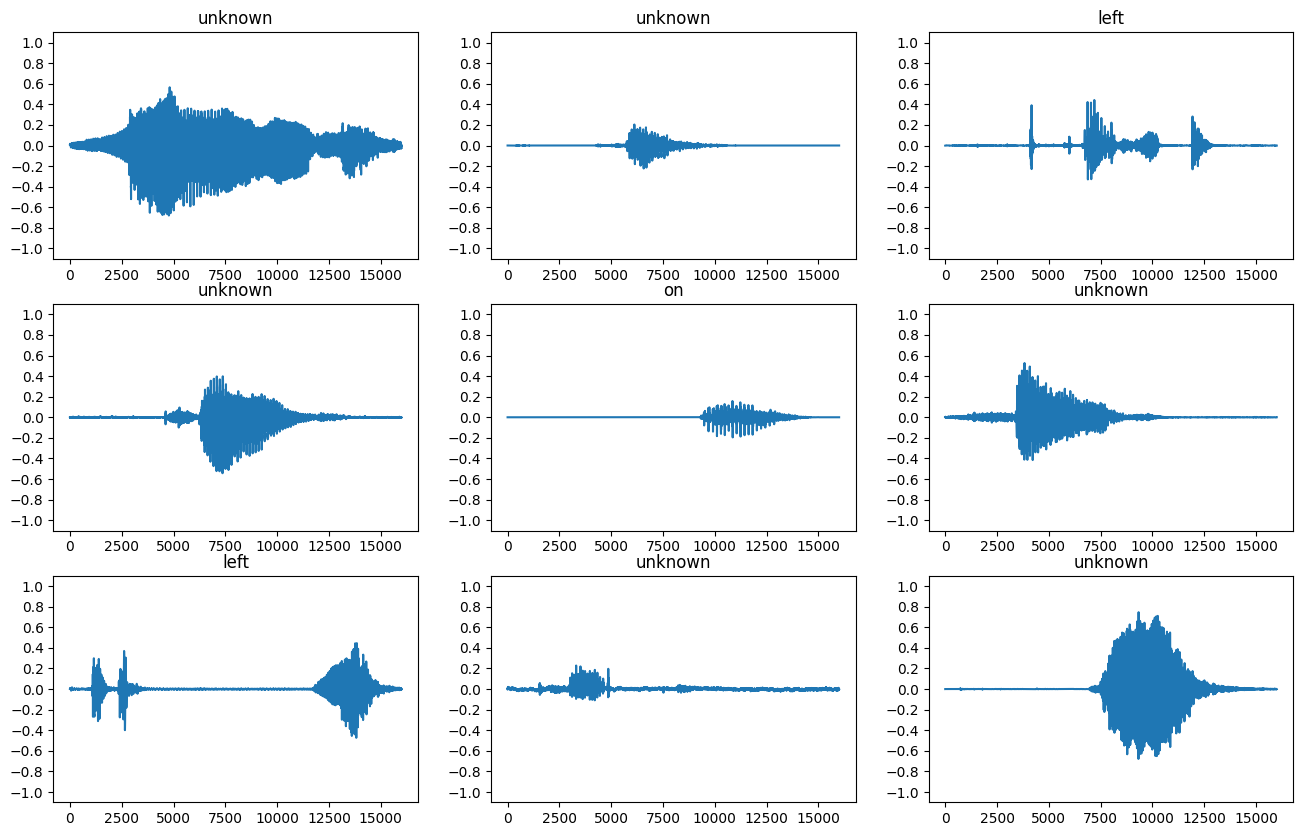

In [68]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

### Converting waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. We'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images.

In [69]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, to explore the data we print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [70]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: unknown
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: unknown
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, we define a function for displaying a spectrogram:

In [71]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

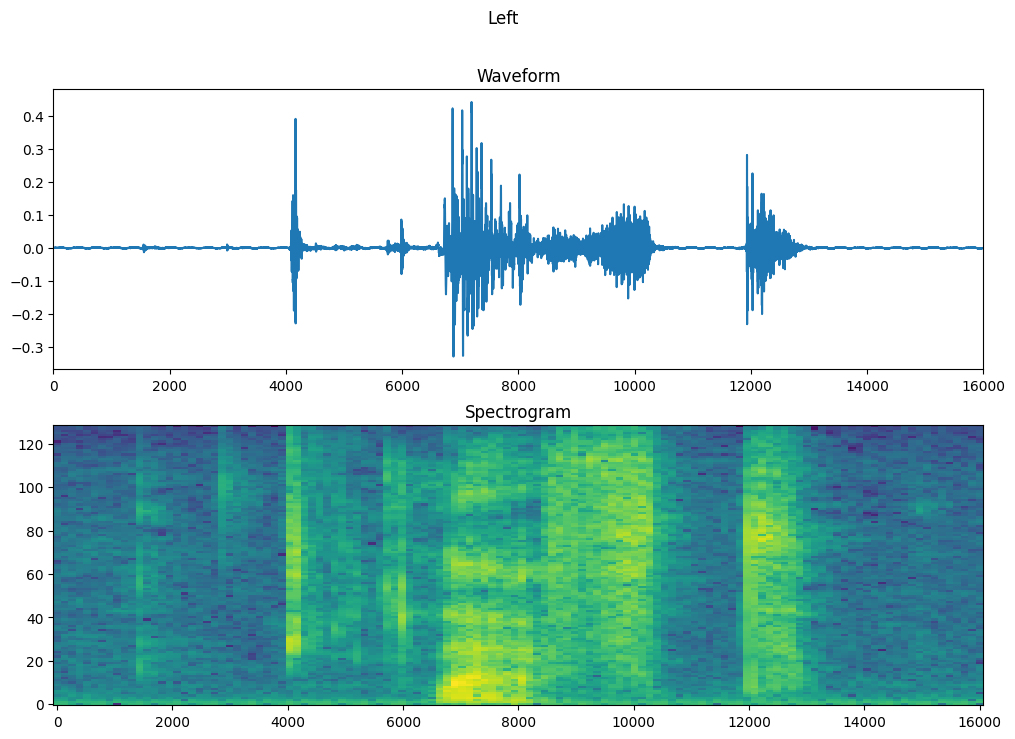

In [72]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Creation of spectrogram datasets from the audio datasets:

In [73]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [74]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
submission_spectrogram_ds = make_spec_ds(submission_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examination of the spectrograms for different examples of the dataset:

In [76]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

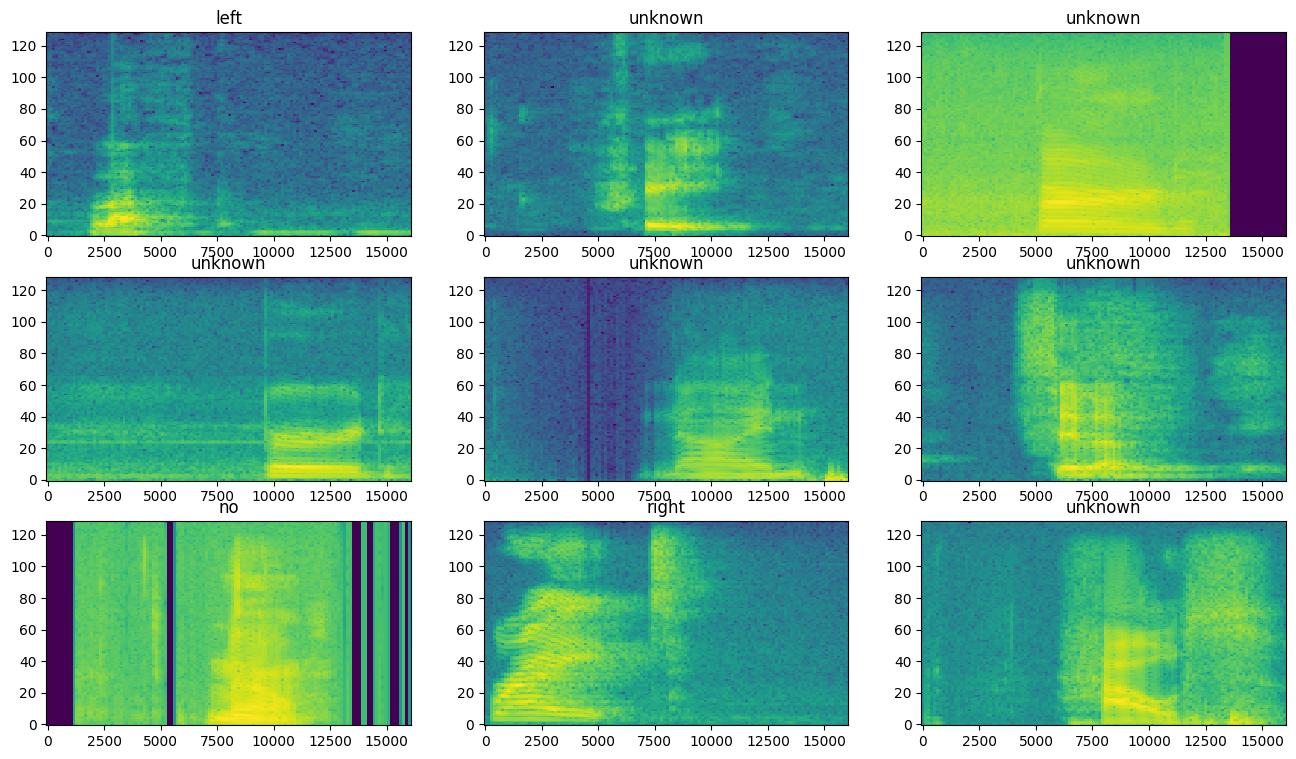

In [77]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Building and training the model

Adding Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:

In [78]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
submission_spectrogram_ds = submission_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
print(f"Dataset length: {len(list(train_spectrogram_ds))}")

Dataset length: 810


Lets, use a simple convolutional neural network (CNN), since we have transformed the audio files into spectrogram images.

Our model will use the following Keras preprocessing layers:
* tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
* tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.

For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [79]:
DROPOUT = 0.25
num_labels = len(label_names)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))
def create_model(dropout_rate):
  model = tf.keras.Sequential([
      layers.Input(shape=input_shape),
      # Downsample the input.
      layers.Resizing(32, 32),
      # Normalize.
      norm_layer,
      layers.Conv2D(32, 3, activation='relu'),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(dropout_rate),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(dropout_rate),
      layers.Dense(num_labels),
  ])
  #model.summary()
  return model

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)


Input shape: (124, 129, 1)
Input shape: (124, 129, 1)


Define a custom wandb callback class to log the trainin data: Training the model over 7 epochs:

In [80]:
class CustomWandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({
            "train_loss": logs.get("loss"),
            "train_accuracy": logs.get("accuracy"),
            "val_loss": logs.get("val_loss"),
            "val_accuracy": logs.get("val_accuracy")
        })


Declare the lists that will store the histories and models of different iterations:

In [81]:
histories = []
created_models = []

Train the model for different parameters:

Or as one function:

In [86]:
def train():
    with wandb.init() as run:
        config = wandb.config
        run.name = f"dp_{config.dropout_rate}_lr_{config.learning_rate}_epochs_{config.epochs}"  # Example: "dp_0.50_lr_0.003_epochs_5"
        run.save()  # Ensure the name is saved in the WandB dashboard

        model = create_model(config.dropout_rate)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        history = model.fit(
            train_spectrogram_ds,
            validation_data=val_spectrogram_ds,
            epochs=config.epochs,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
                CustomWandbCallback()  # Add this to log metrics to WandB
            ],
        )
        histories.append(history)
        created_models.append(model)


wandb.agent(sweep_id, train)

wandb: Agent Starting Run: ren8on14 with config:
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001


Epoch 1/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.6437 - loss: 1.3327 - val_accuracy: 0.7580 - val_loss: 0.7290
Epoch 2/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.7337 - loss: 0.8122 - val_accuracy: 0.8213 - val_loss: 0.5318
Epoch 3/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - accuracy: 0.7825 - loss: 0.6470 - val_accuracy: 0.8448 - val_loss: 0.4762
Epoch 4/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - accuracy: 0.8110 - loss: 0.5680 - val_accuracy: 0.8666 - val_loss: 0.4198
Epoch 5/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.8275 - loss: 0.5200 - val_accuracy: 0.8738 - val_loss: 0.4018


wandb: Agent Starting Run: 86nofcyh with config:
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 7
wandb: 	learning_rate: 0.001


Epoch 1/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6343 - loss: 1.3591 - val_accuracy: 0.7361 - val_loss: 0.7575
Epoch 2/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7282 - loss: 0.8236 - val_accuracy: 0.8181 - val_loss: 0.5497
Epoch 3/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7763 - loss: 0.6637 - val_accuracy: 0.8529 - val_loss: 0.4671
Epoch 4/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8087 - loss: 0.5771 - val_accuracy: 0.8586 - val_loss: 0.4376
Epoch 5/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.8235 - loss: 0.5296 - val_accuracy: 0.8810 - val_loss: 0.3842
Epoch 6/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.8354 - loss: 0.4907 - val_accuracy: 0.8877 - val_loss: 0.3649
Epoch 7/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.8437 - loss: 0.4670 - val_accuracy: 0.8959 - val_loss: 0.3502


wandb: Agent Starting Run: irrmt0il with config:
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001


Epoch 1/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.6385 - loss: 1.3275 - val_accuracy: 0.7597 - val_loss: 0.7138
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.7392 - loss: 0.7863 - val_accuracy: 0.8213 - val_loss: 0.5383
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.7879 - loss: 0.6305 - val_accuracy: 0.8496 - val_loss: 0.4528
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.8122 - loss: 0.5603 - val_accuracy: 0.8657 - val_loss: 0.4271
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.8286 - loss: 0.5094 - val_accuracy: 0.8803 - val_loss: 0.3859
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8401 - loss: 0.4785 - val_accuracy: 0.8885 - val_loss: 0.3628
Epoch 7/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8516 - loss: 0.4443 - val_accuracy: 0.8936 - val_loss: 0.3375
Epoch 8/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8621 - loss: 0.4096 - 

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Plotting the training and validation loss curves to check how model has improved during training:

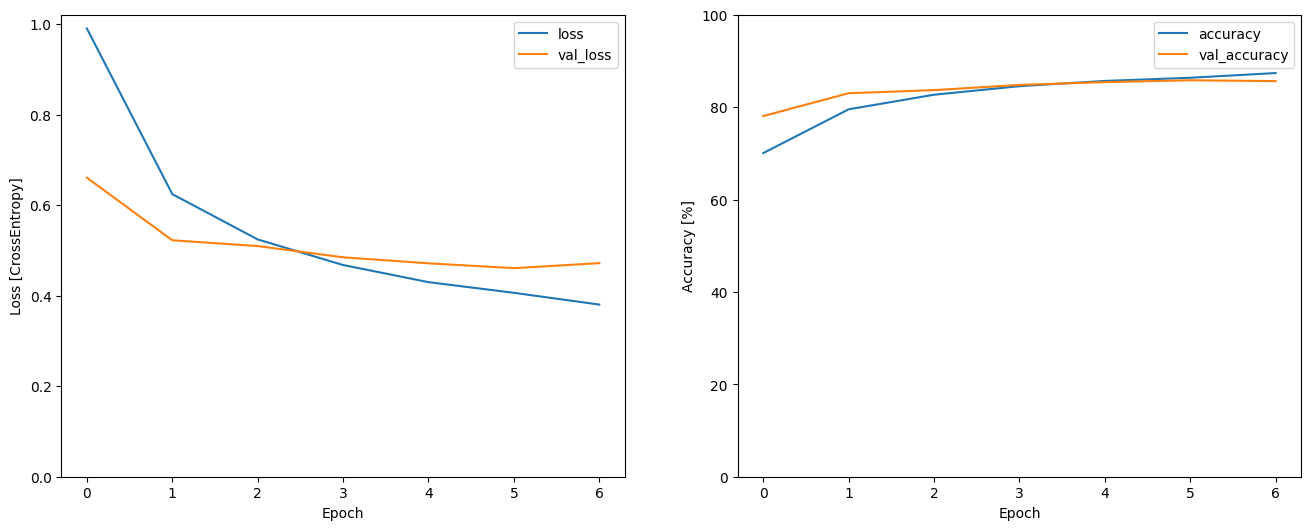

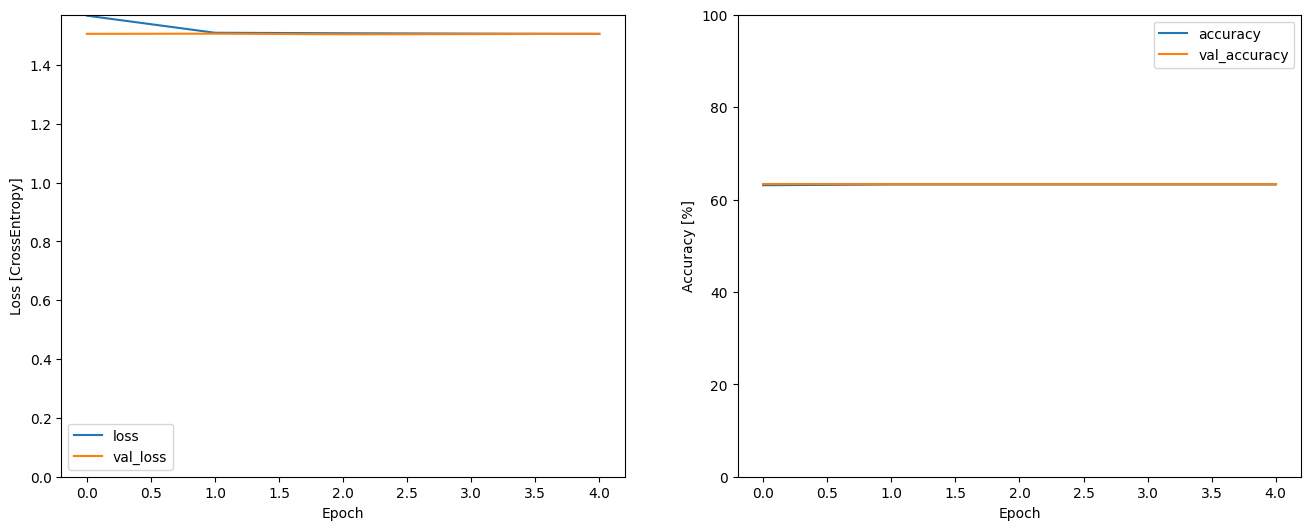

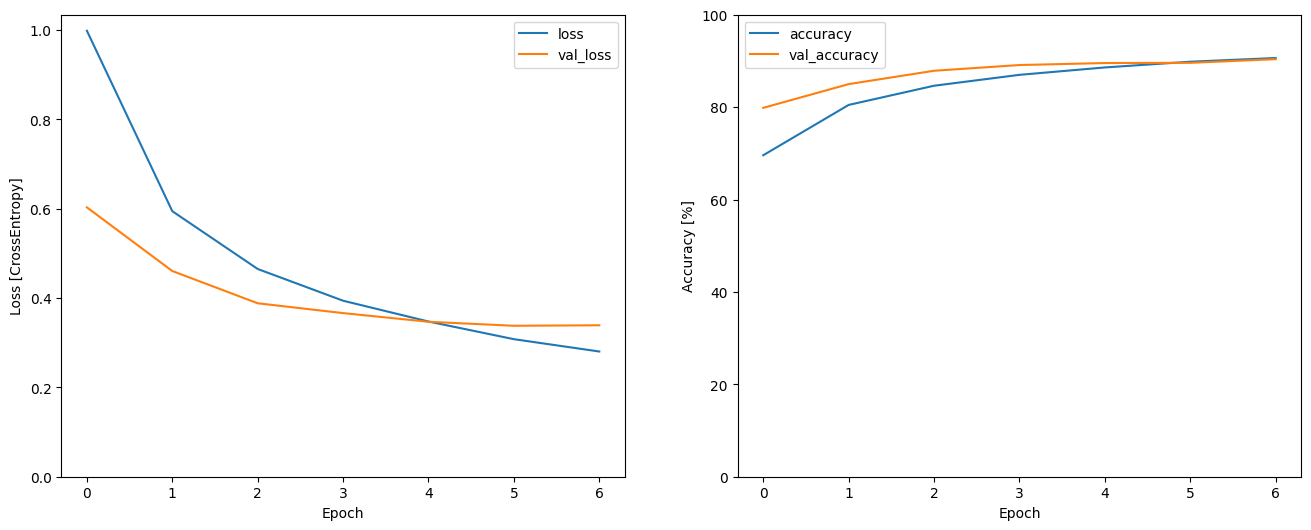

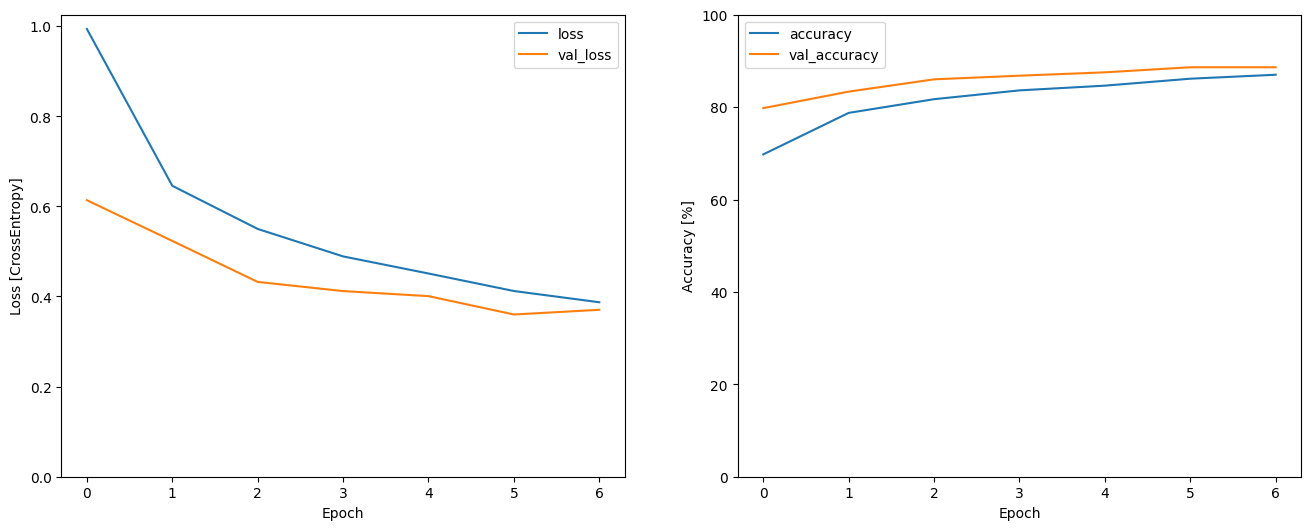

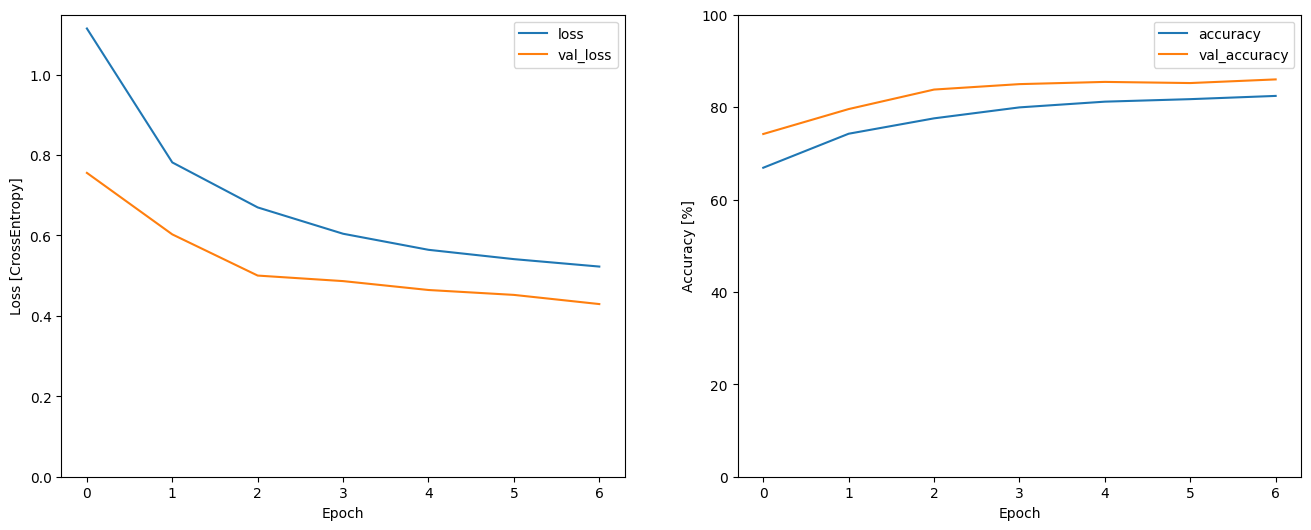

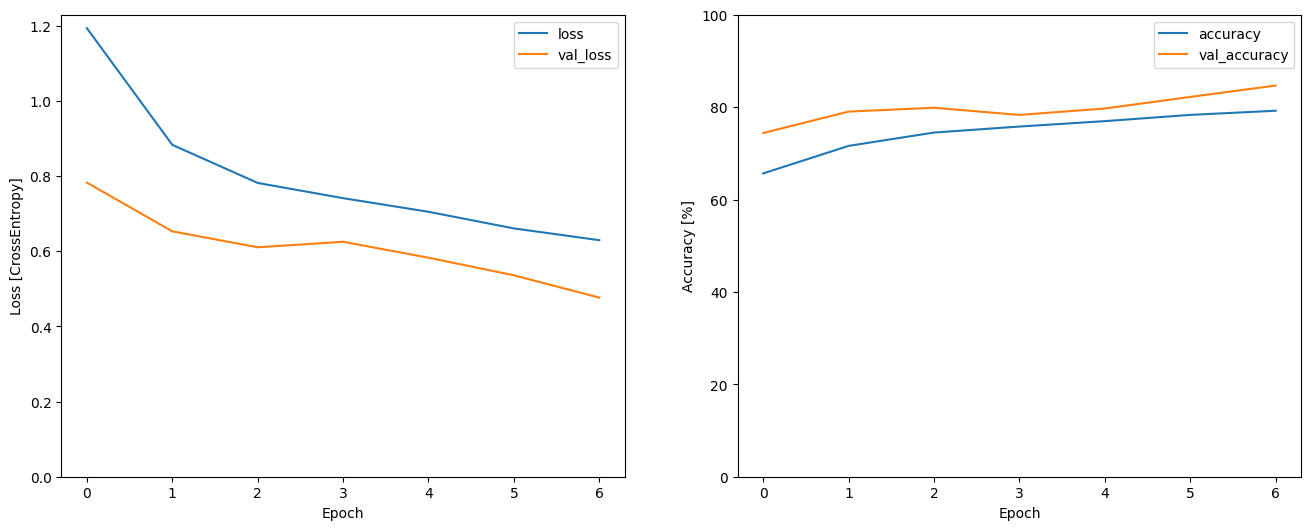

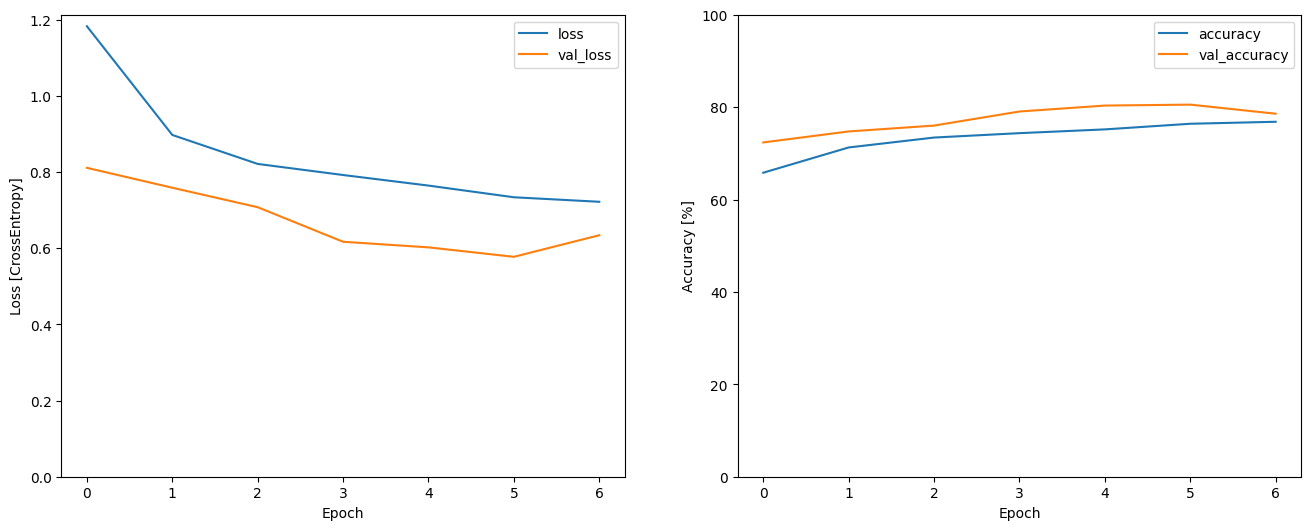

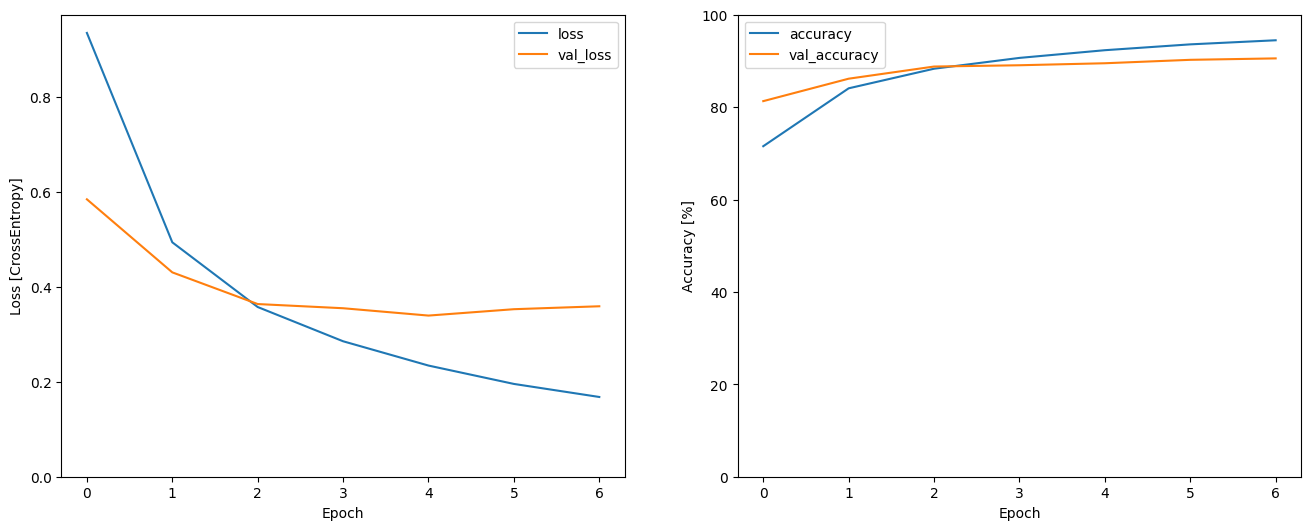

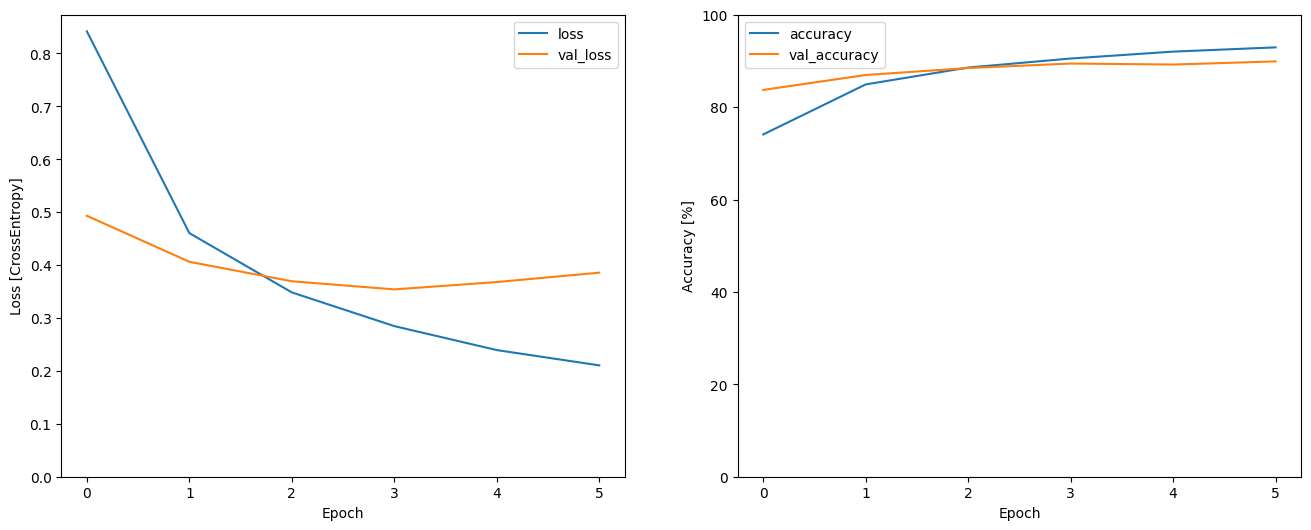

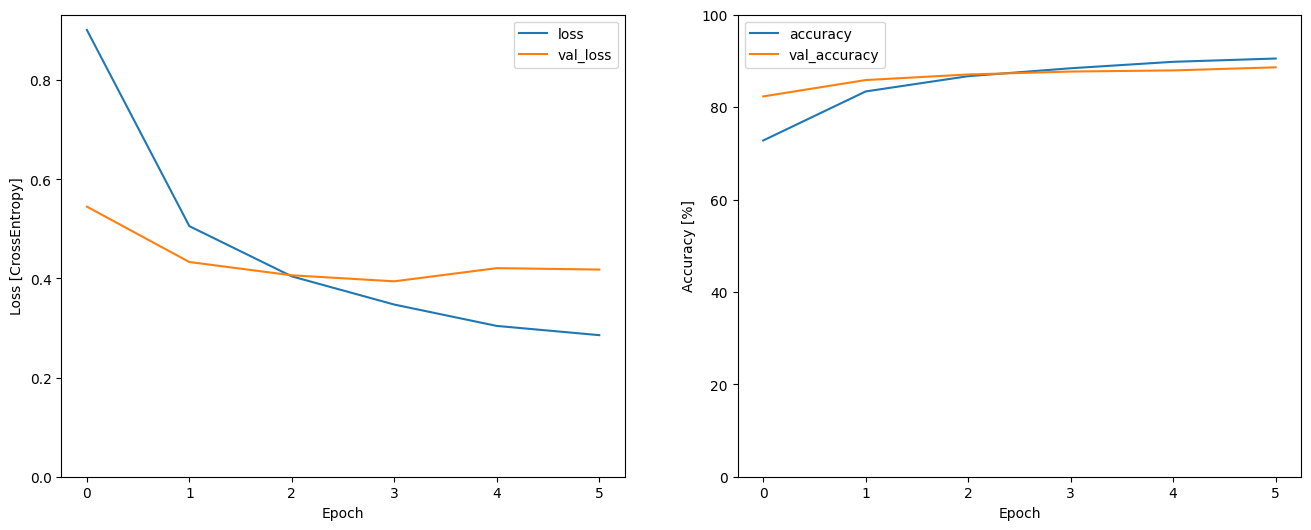

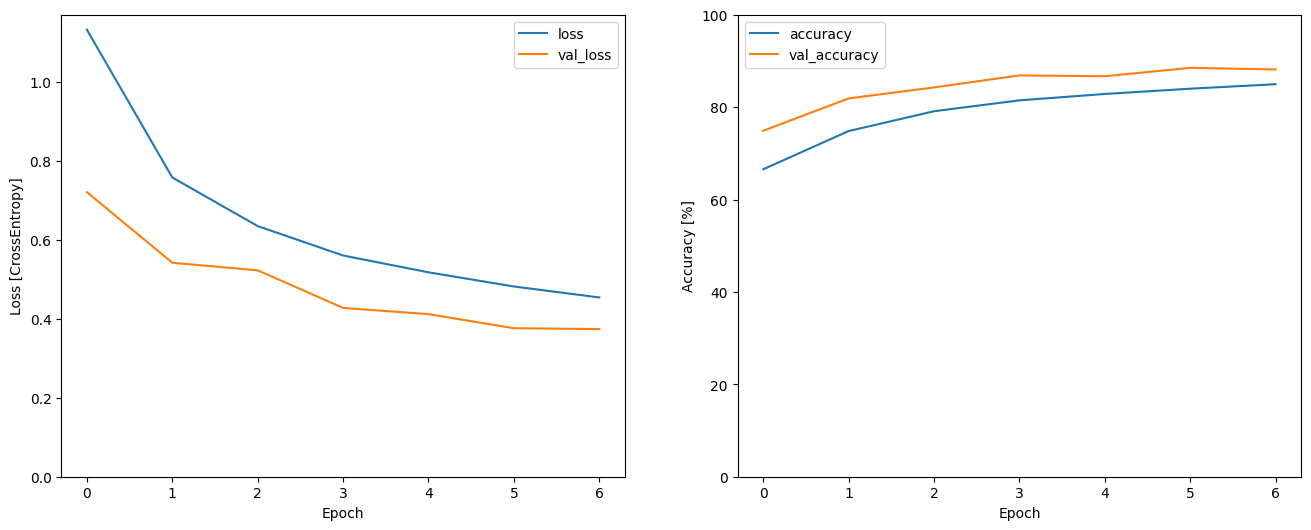

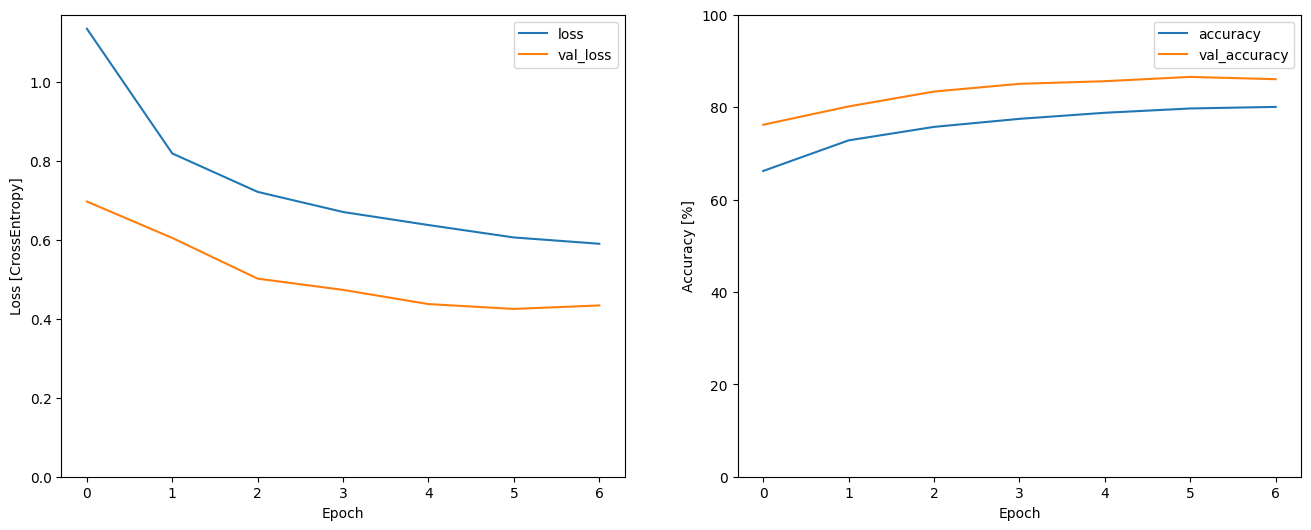

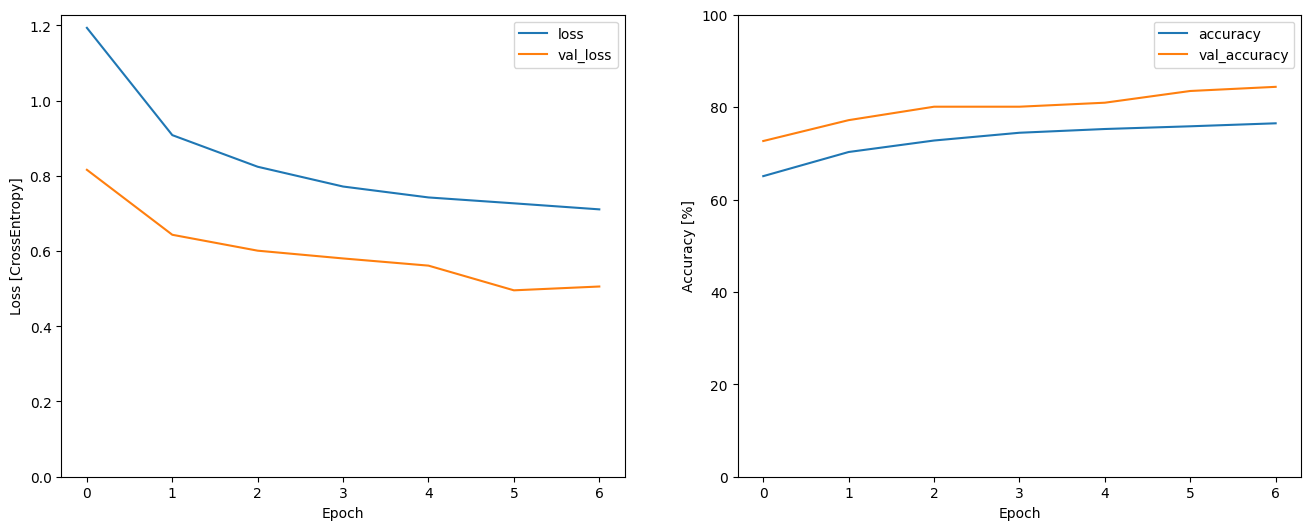

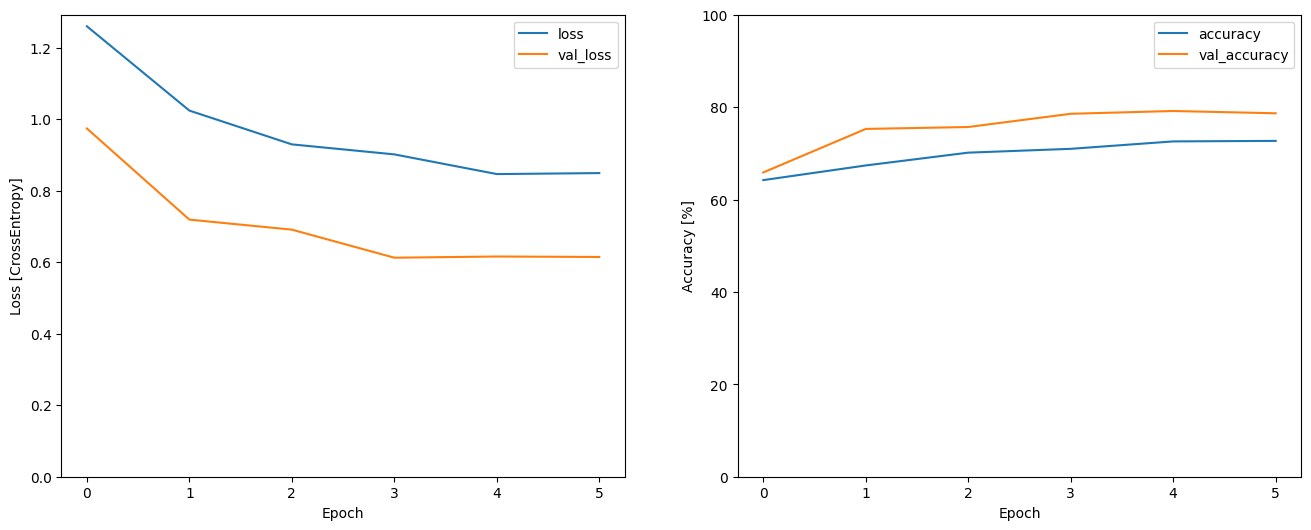

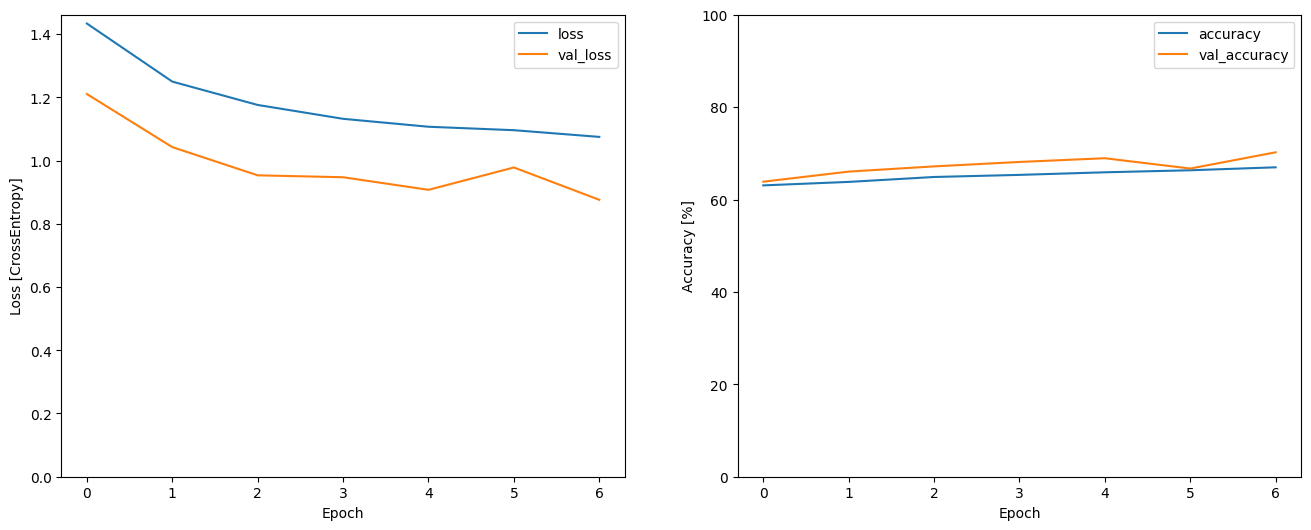

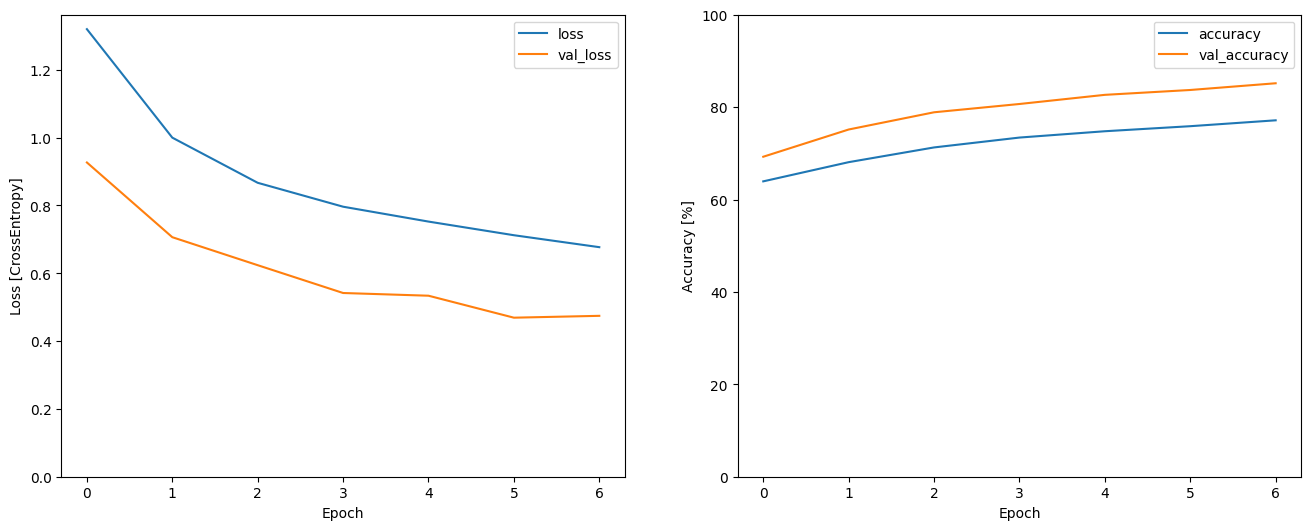

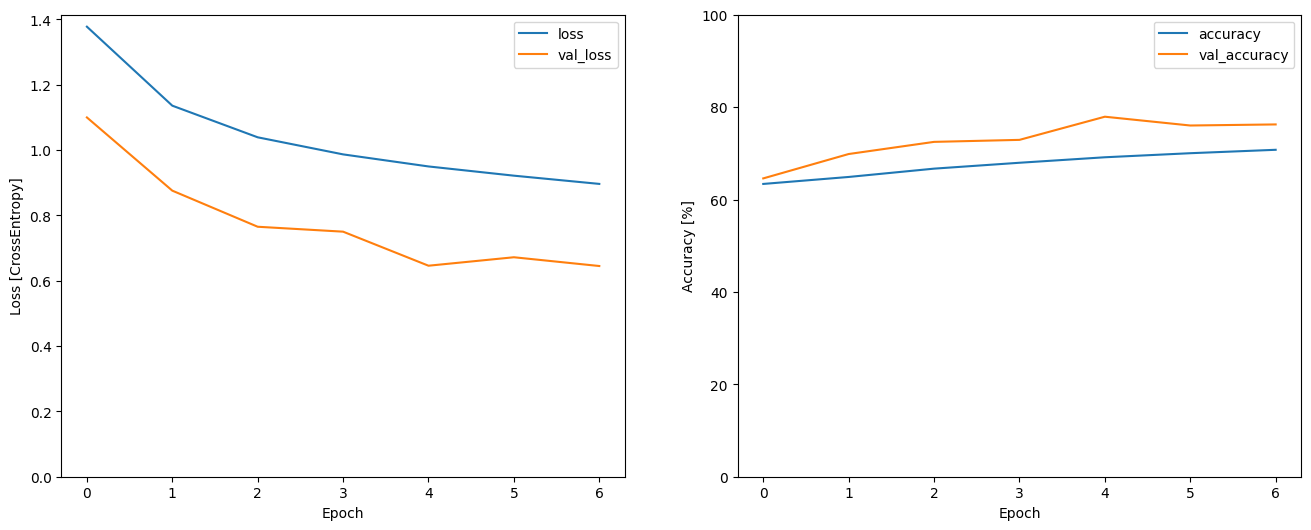

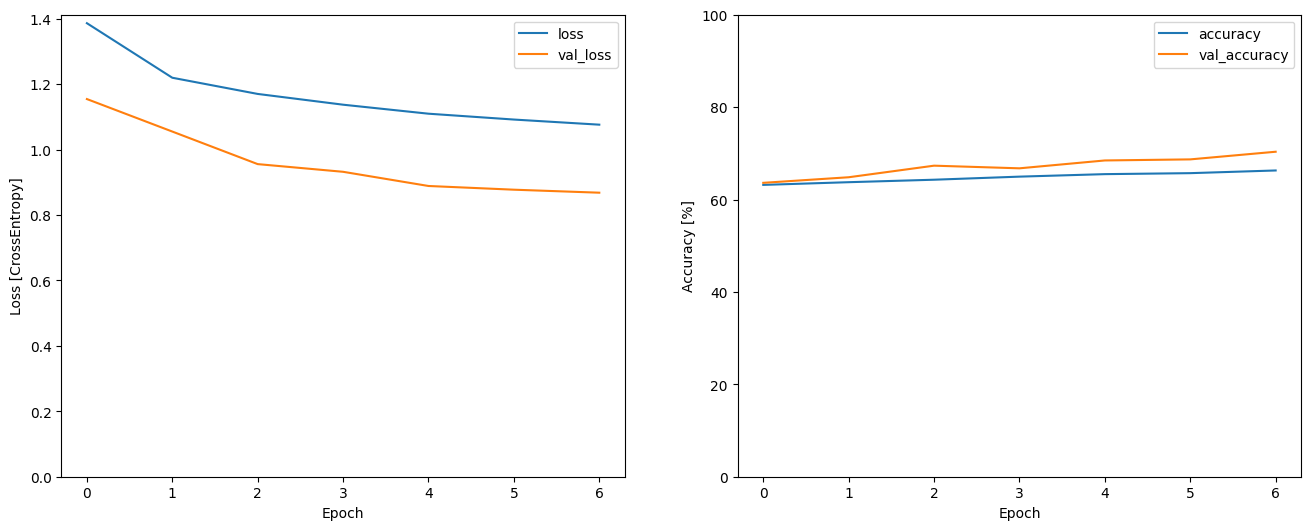

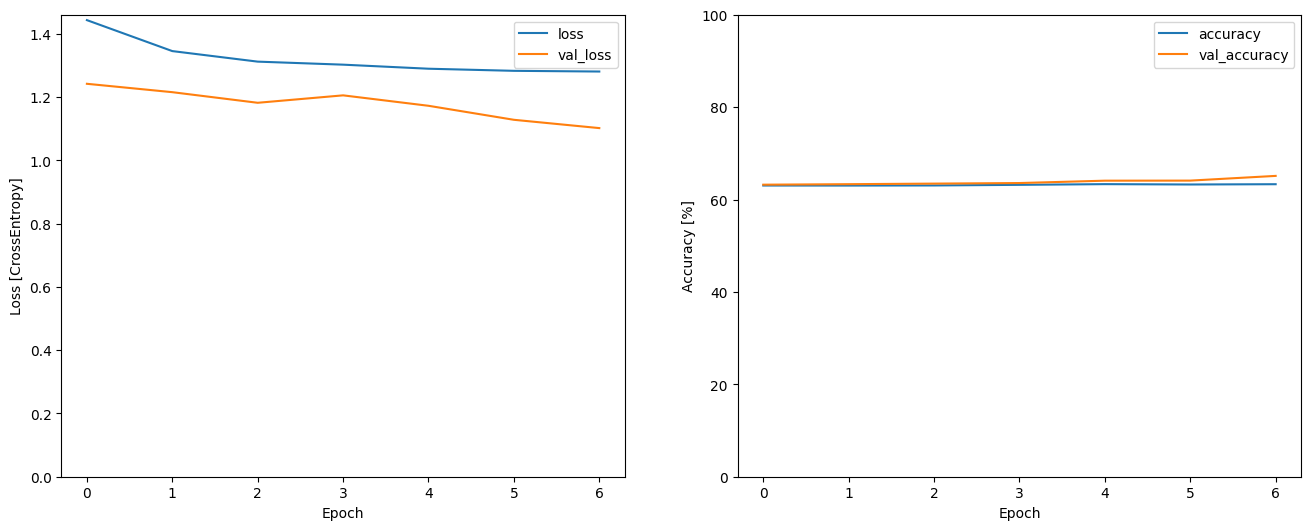

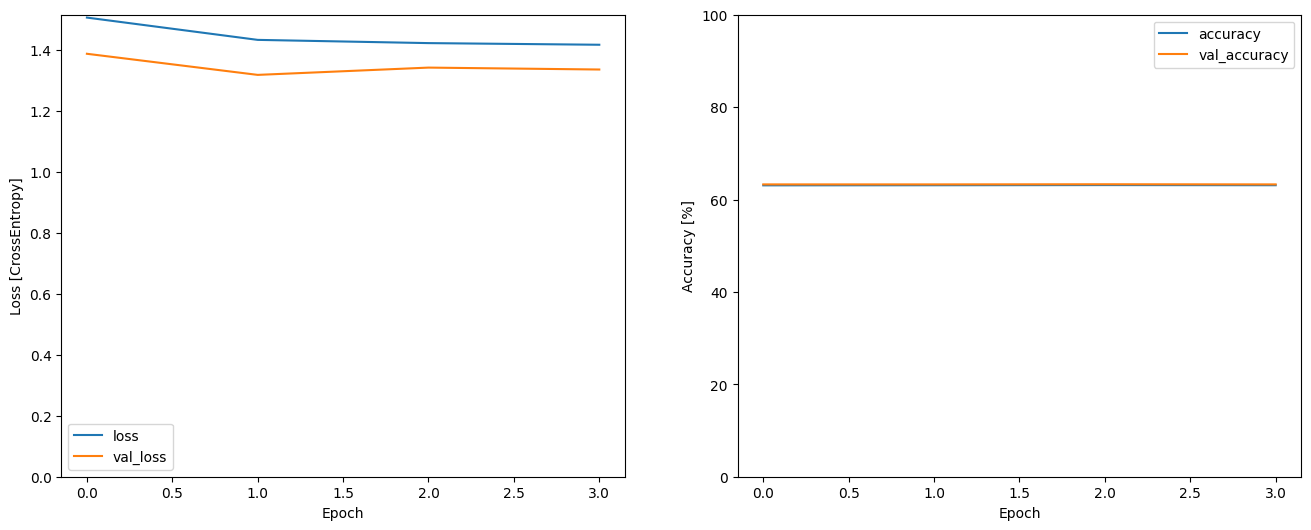

In [34]:
for history in histories:
    metrics = history.history

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1,2,2)
    plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')

## Evaluating the model performance

In [36]:
for model in created_models:
    model.evaluate(test_spectrogram_ds, return_dict=True)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8647 - loss: 0.4277
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6475 - loss: 1.4659
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9132 - loss: 0.3072
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8936 - loss: 0.3412
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8630 - loss: 0.4096
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8506 - loss: 0.4511
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8052 - loss: 0.5812
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9075 - loss: 0.3472
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8922 - loss: 0.3717
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8899 - loss: 0.4203
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8868 - loss: 0.3454
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8702 - loss: 0.4132
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8429 - loss: 0.4802
102/102 ━━━━━━━━━━━━━━━━━

### Displaying a confusion matrix and histogram

We'll use a confusion matrix and histogram to check how well the model did classifying each of the words in the test set:

In [37]:
def display_conf_matrix(model):
    y_pred = model.predict(test_spectrogram_ds)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=label_names,
                yticklabels=label_names,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
    return confusion_mtx

In [38]:
def display_histogram(model):
    y_pred = model.predict(test_spectrogram_ds)
    y_pred = tf.argmax(y_pred, axis=1)
    label_mapping = {index: value for index, value in enumerate(label_names)}
    label_texts = [label_mapping[label] for label in y_pred.numpy()]
    plt.figure(figsize=(15, 8))
    sns.histplot(label_texts)
    plt.xlabel('Label')
    plt.ylabel('# of predictions')
    plt.show()

Now, we'll explore confusion matrix and histogram for all labels but unknown:

In [39]:
def display_conf_matrix_without_unknown(confusion_mtx):
    unknown_index = list(label_names).index("unknown")

    # Remove "unknown" row and column from confusion matrix
    confusion_mtx = np.delete(confusion_mtx, unknown_index, axis=0)  # Remove row
    confusion_mtx = np.delete(confusion_mtx, unknown_index, axis=1)  # Remove column

    # Remove "unknown" from label names
    filtered_labels = np.delete(label_names, unknown_index)

    # Plotting the modified confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=filtered_labels,
                yticklabels=filtered_labels,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()


In [40]:
def display_histogram_without_unknown(model):
    y_pred = model.predict(test_spectrogram_ds)
    y_pred = tf.argmax(y_pred, axis=1)
    # Create a mapping of indices to labels
    label_mapping = {index: value for index, value in enumerate(label_names)}

    # Filter out predictions with the "unknown" label
    unknown_index = list(label_mapping.values()).index("unknown")
    filtered_y_pred = [label for label in y_pred.numpy() if label != unknown_index]

    # Map the filtered predictions to their text labels
    label_texts = [label_mapping[label] for label in filtered_y_pred]

    # Plot the histogram excluding "unknown" predictions
    plt.figure(figsize=(15, 8))
    sns.histplot(label_texts)
    plt.xlabel('Label')
    plt.ylabel('# of predictions')
    plt.show()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


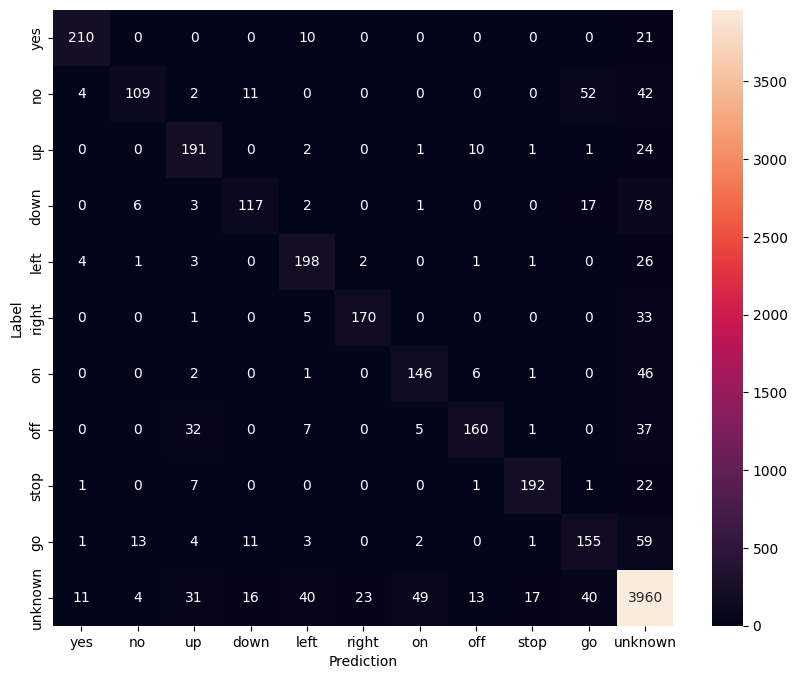

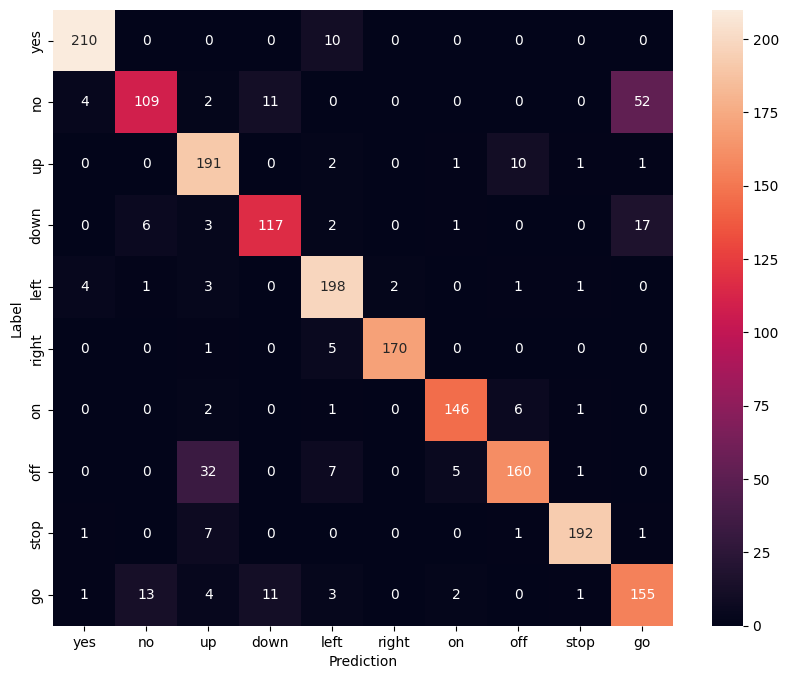

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


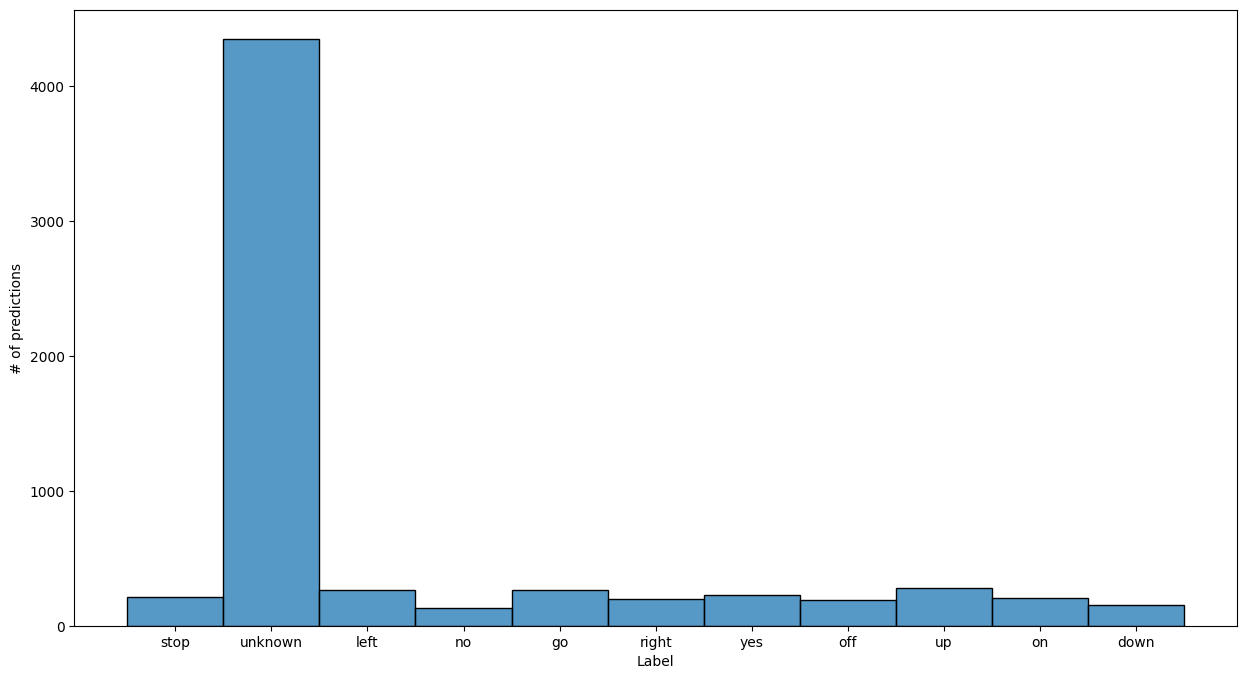

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


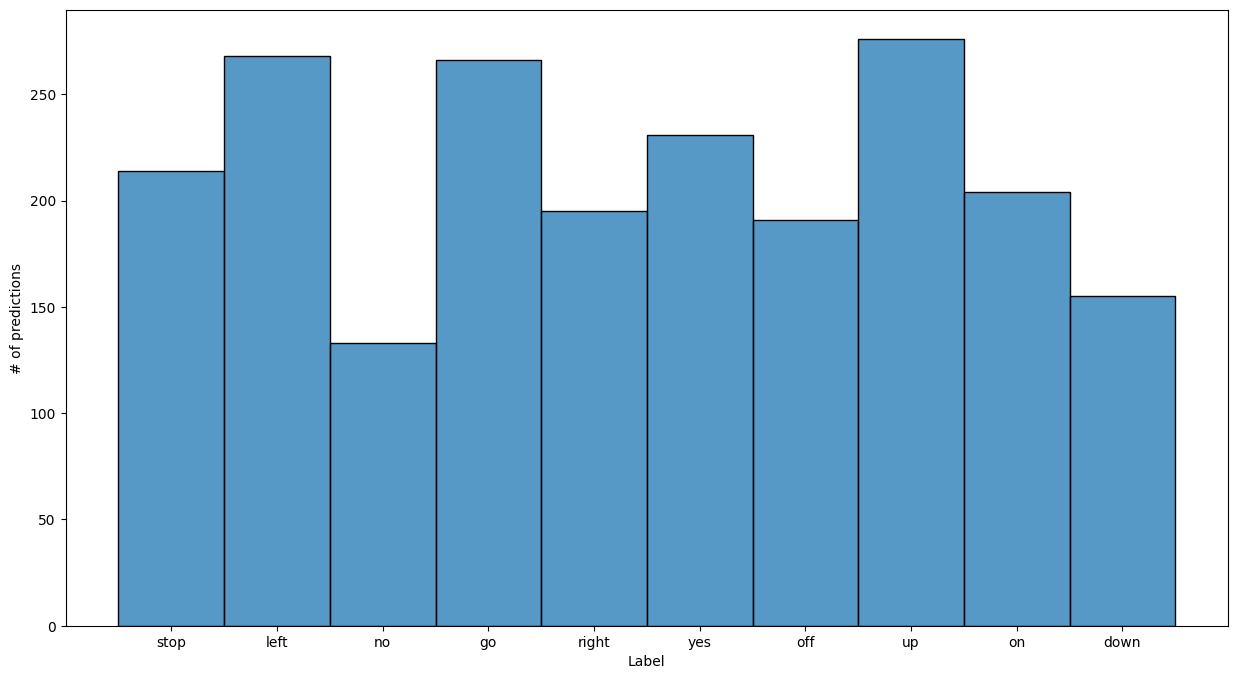

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


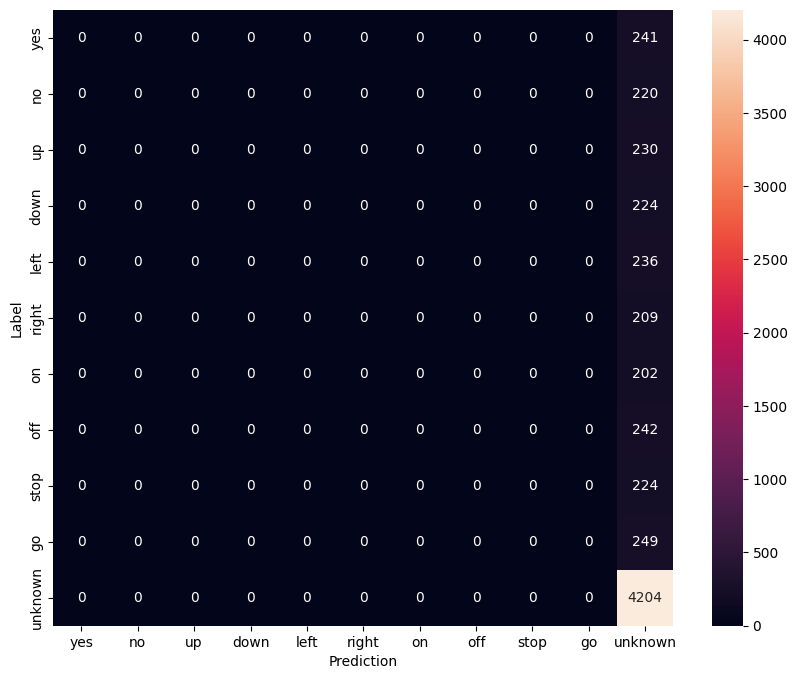

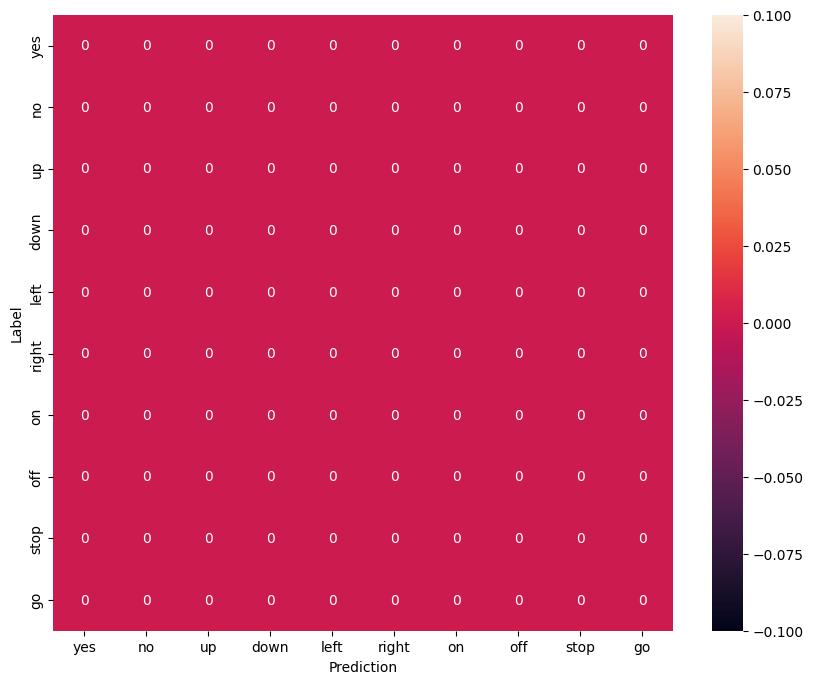

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


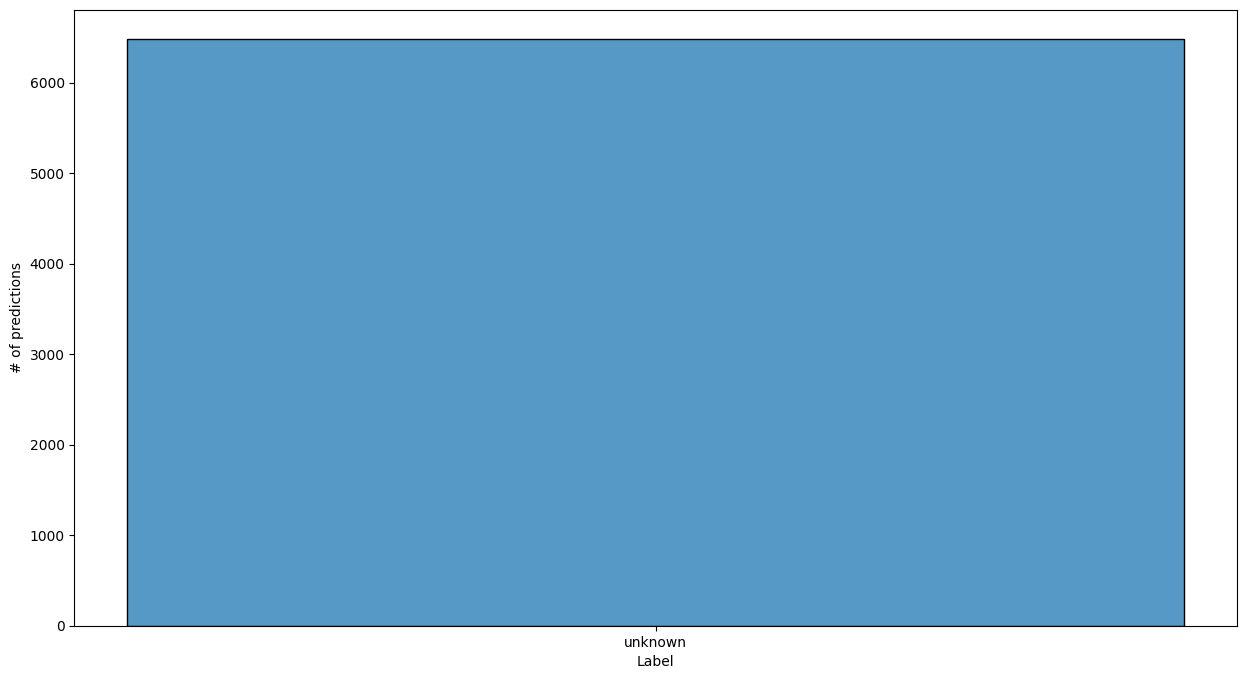

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


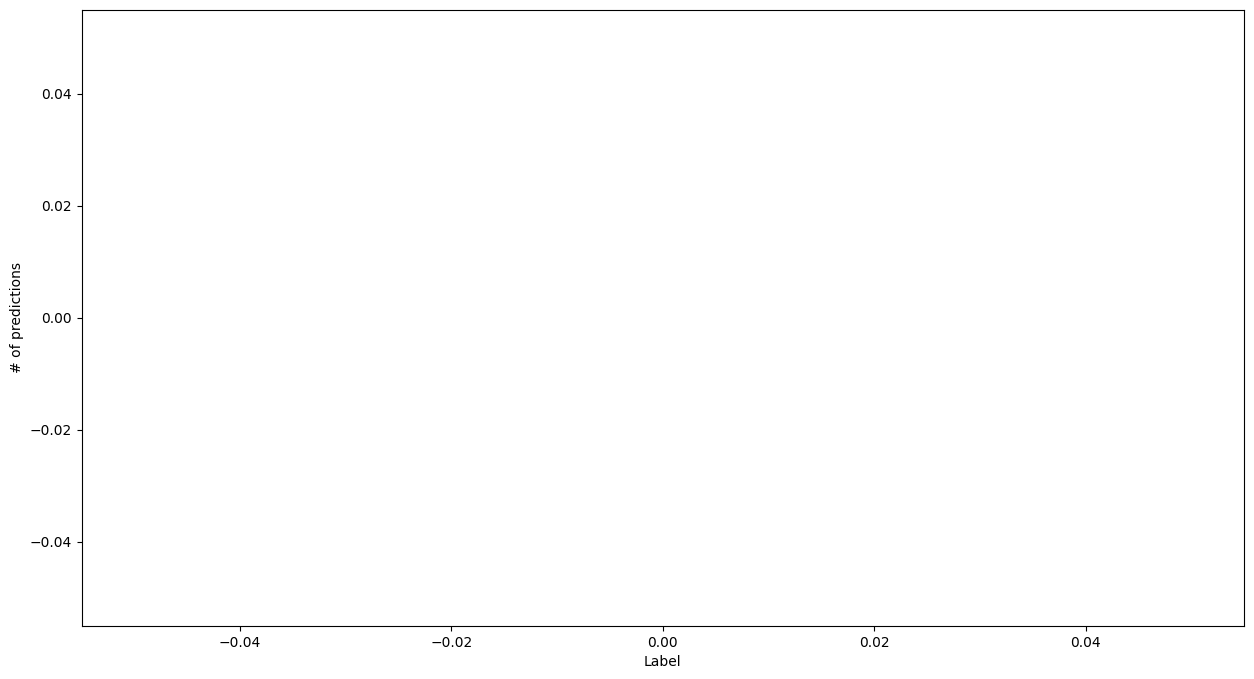

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


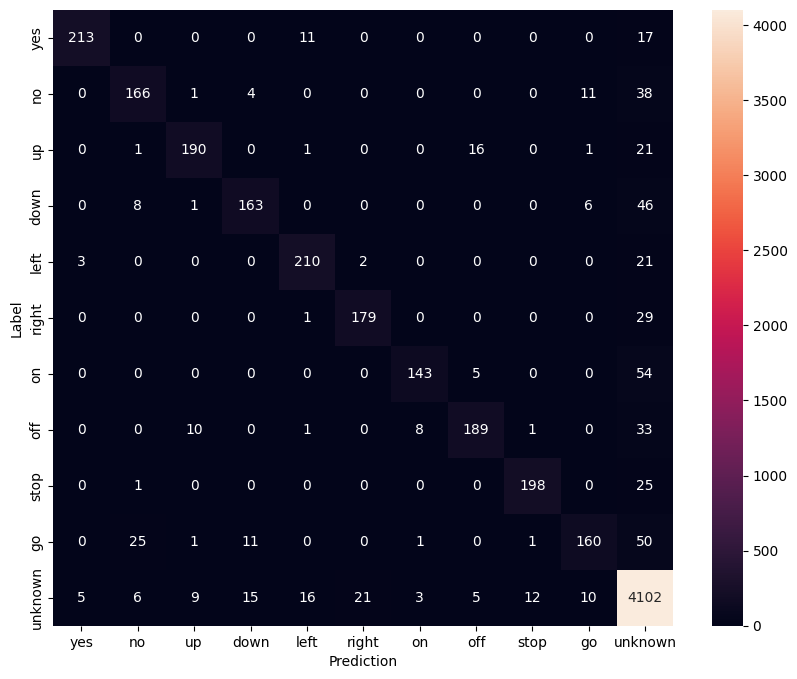

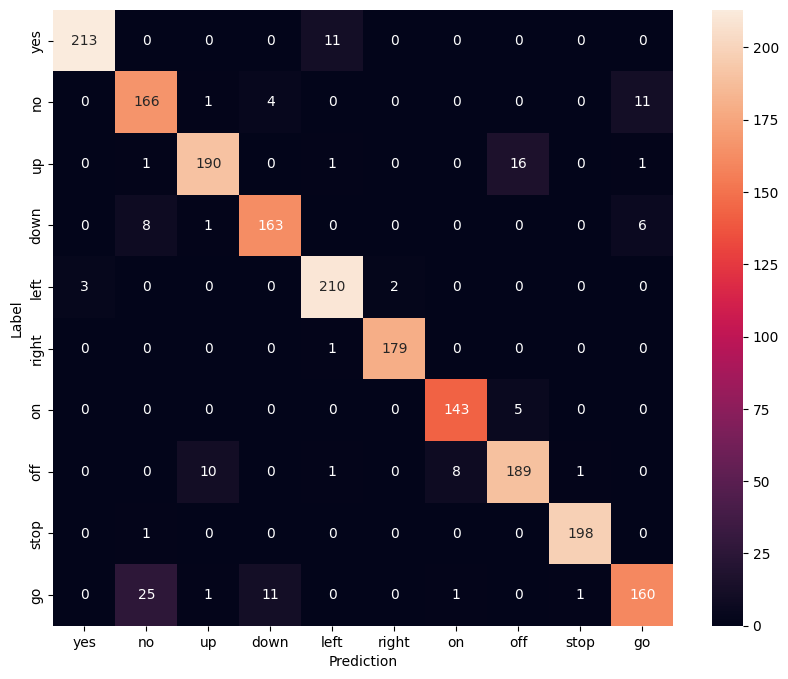

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


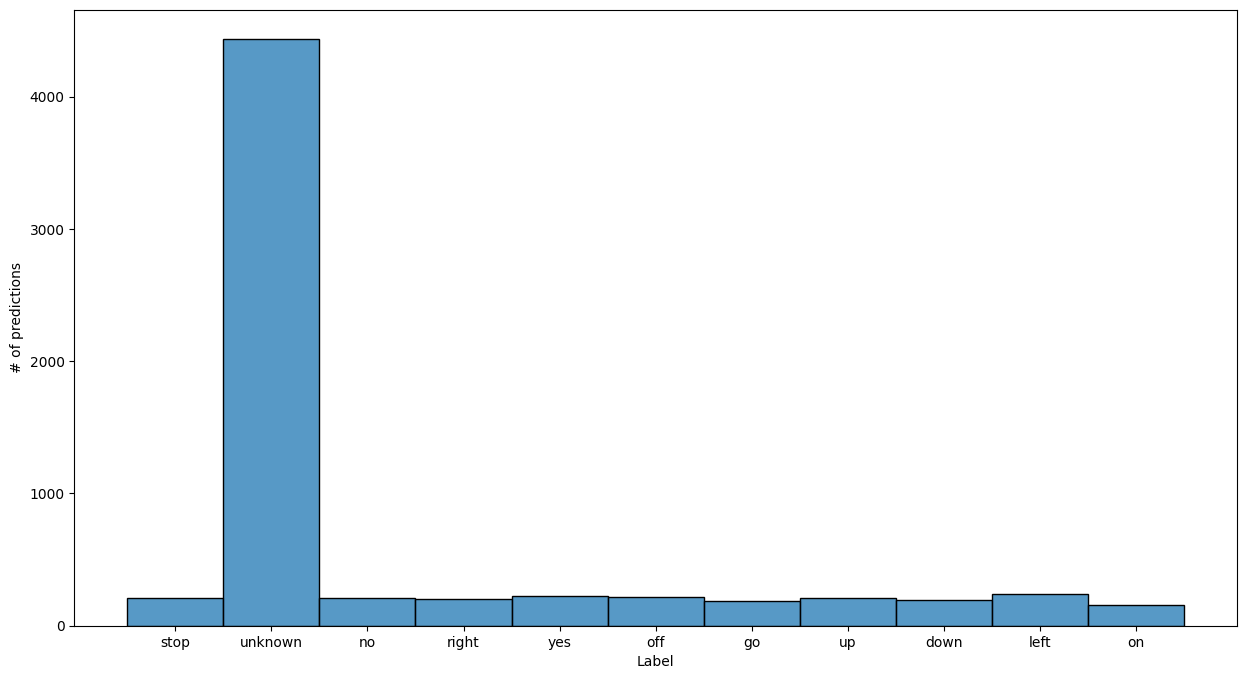

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


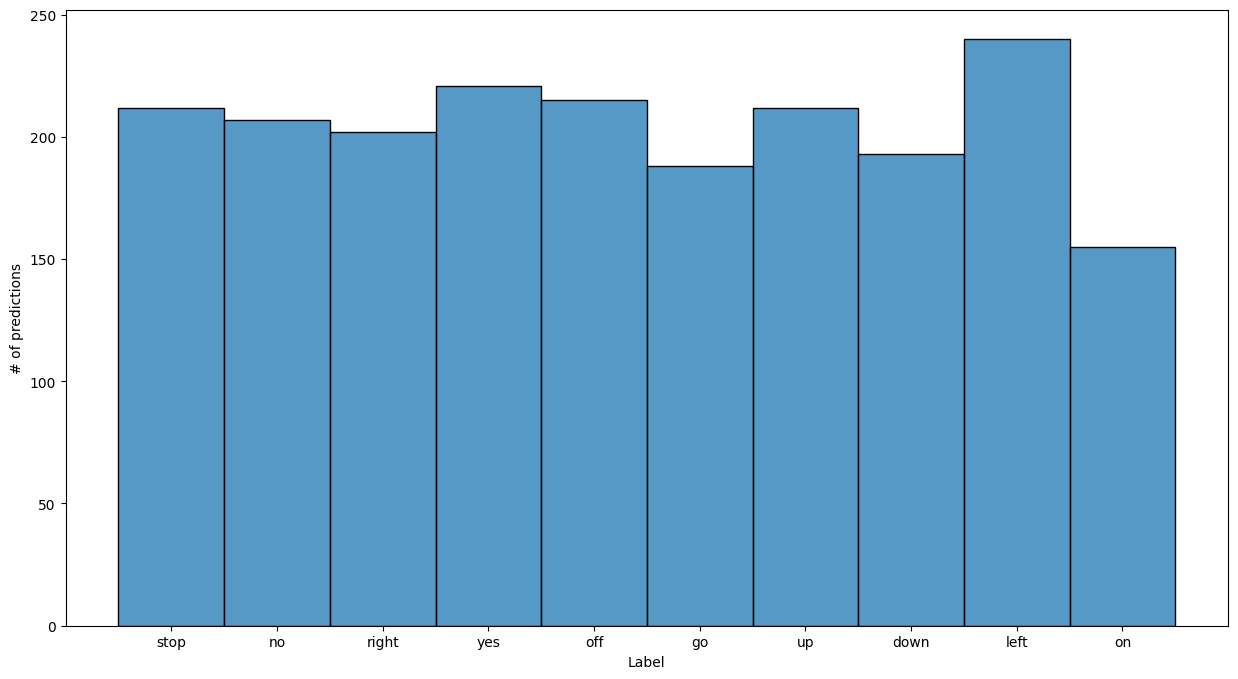

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


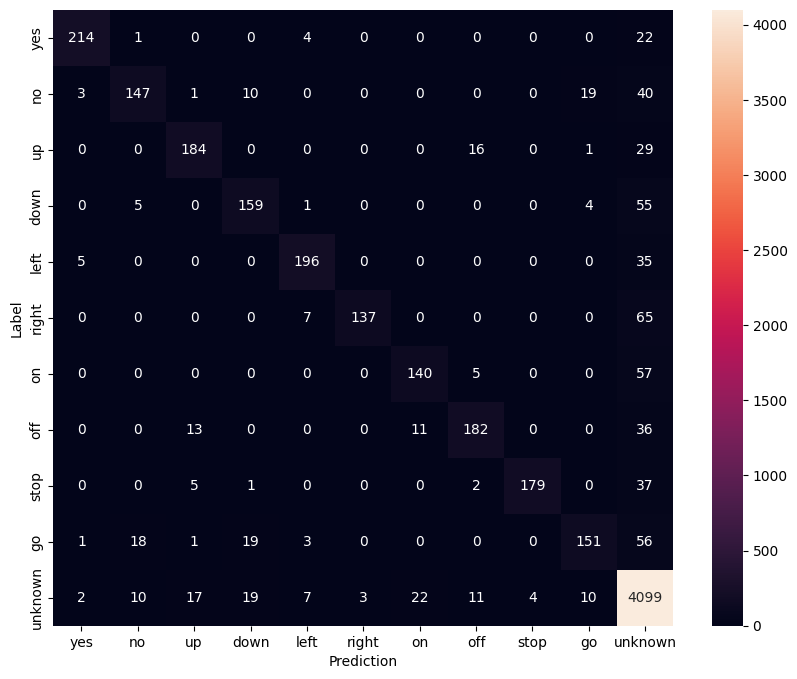

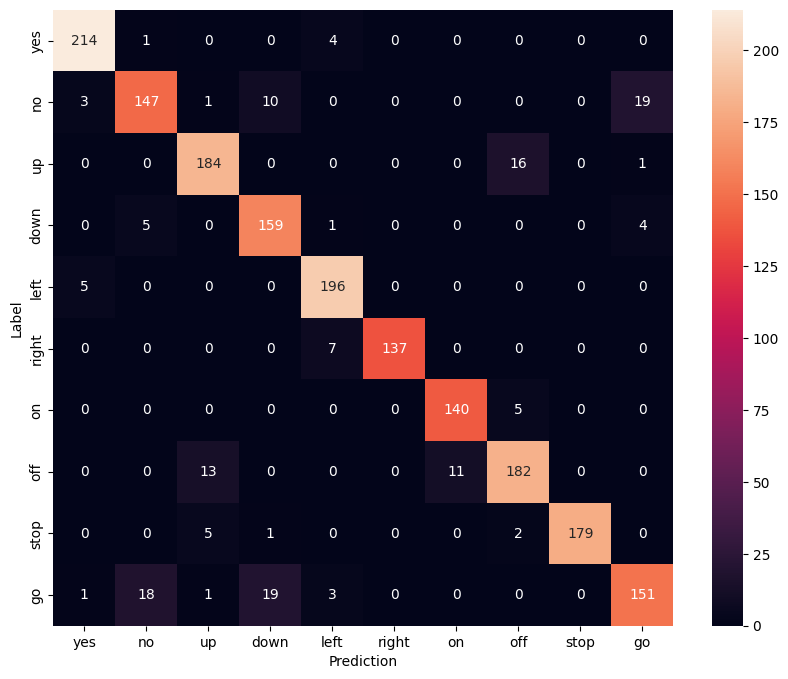

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


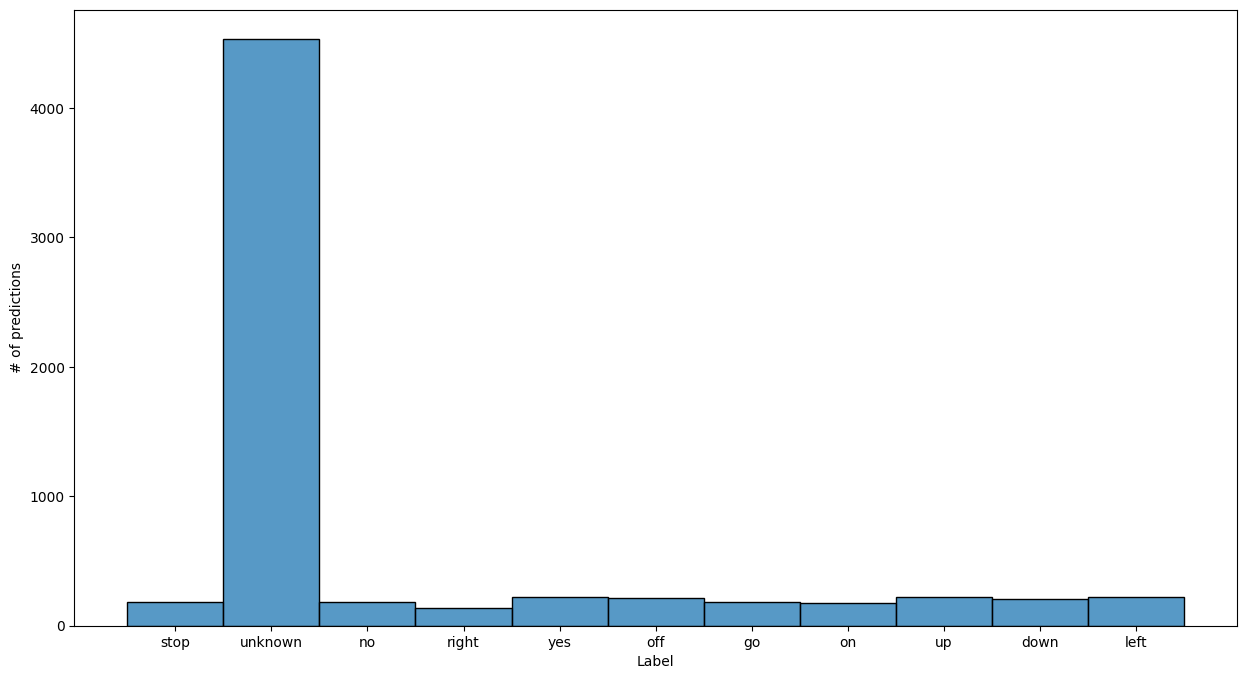

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


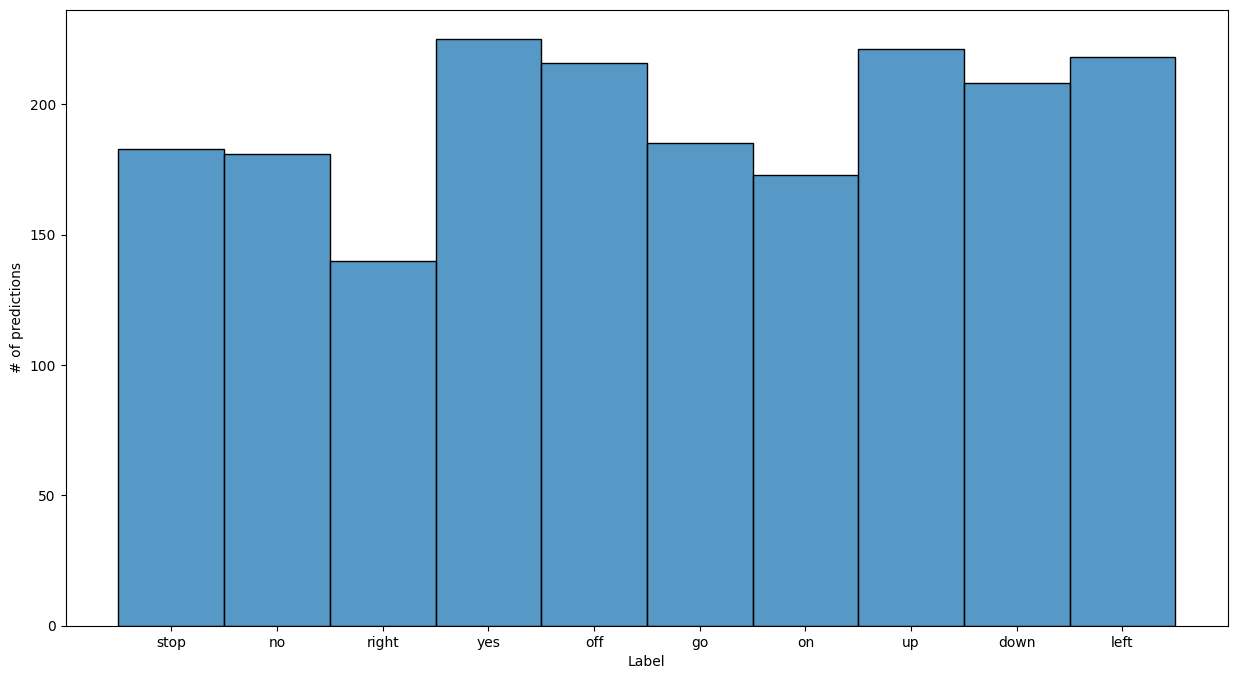

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


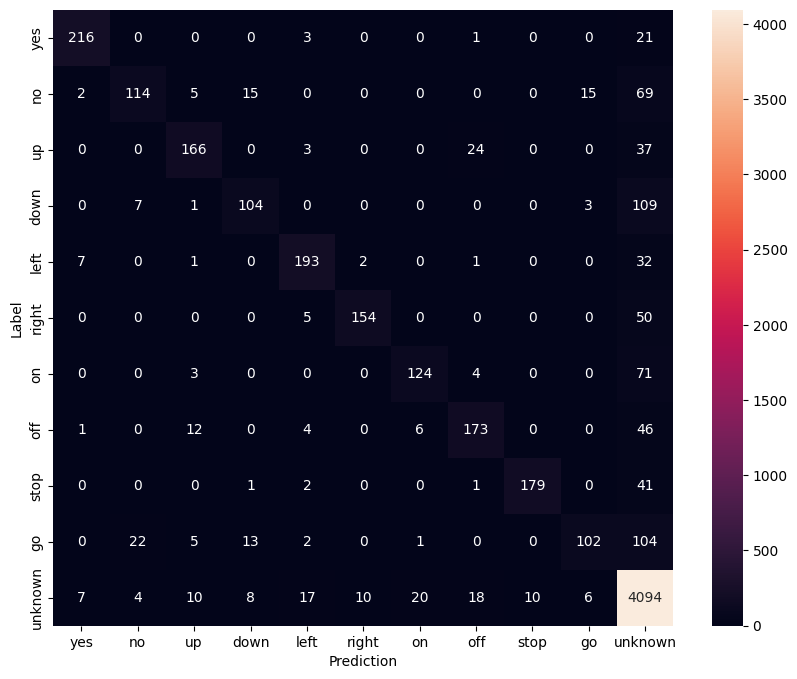

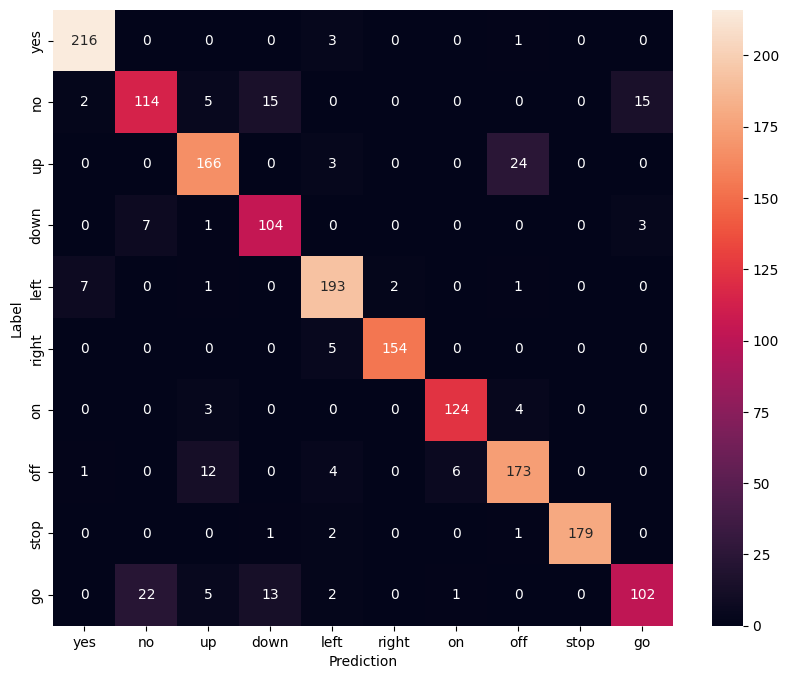

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


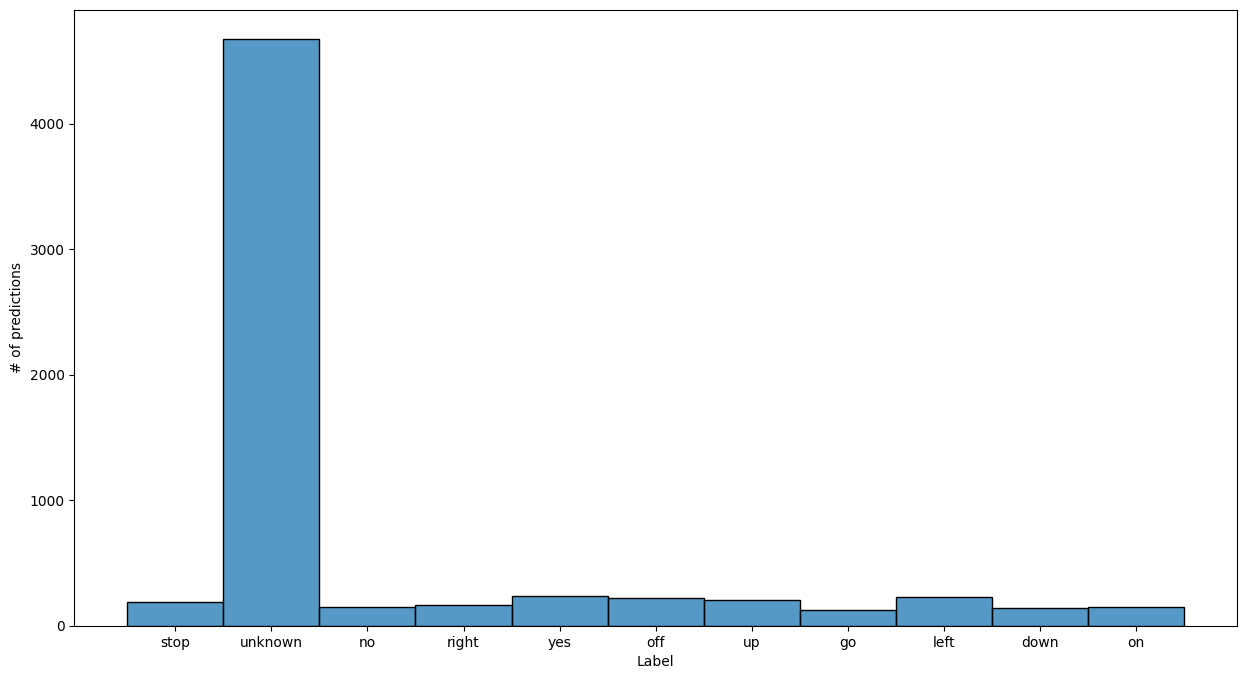

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


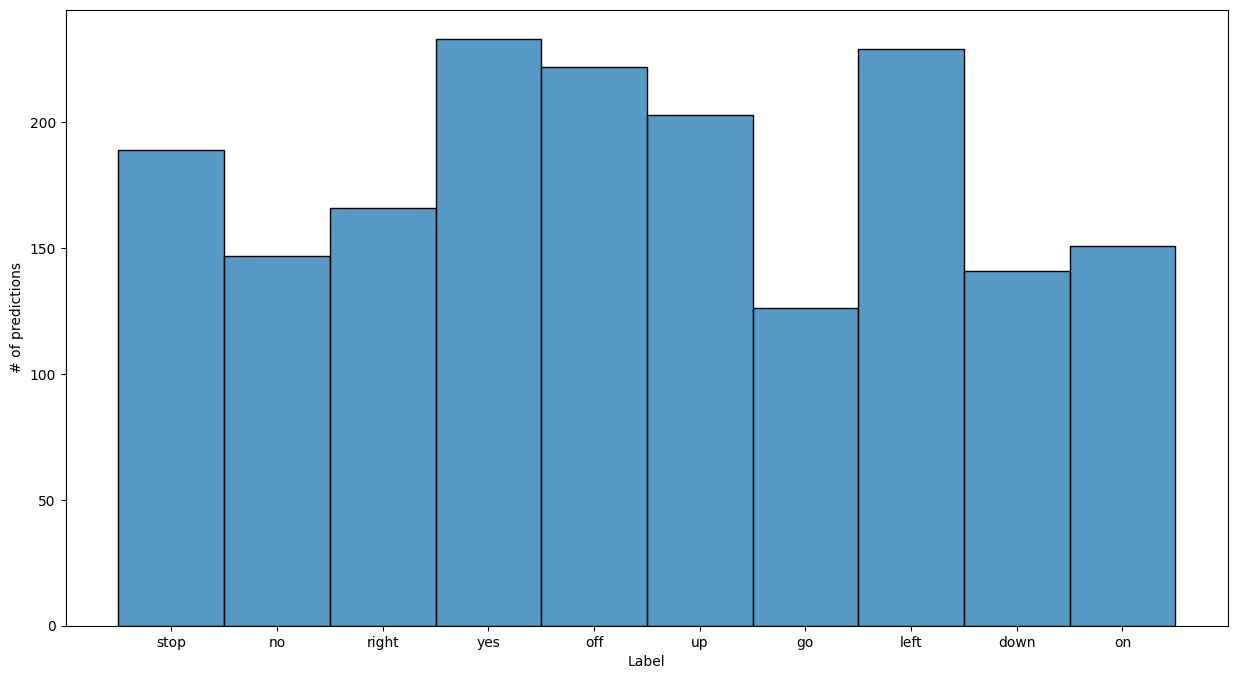

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


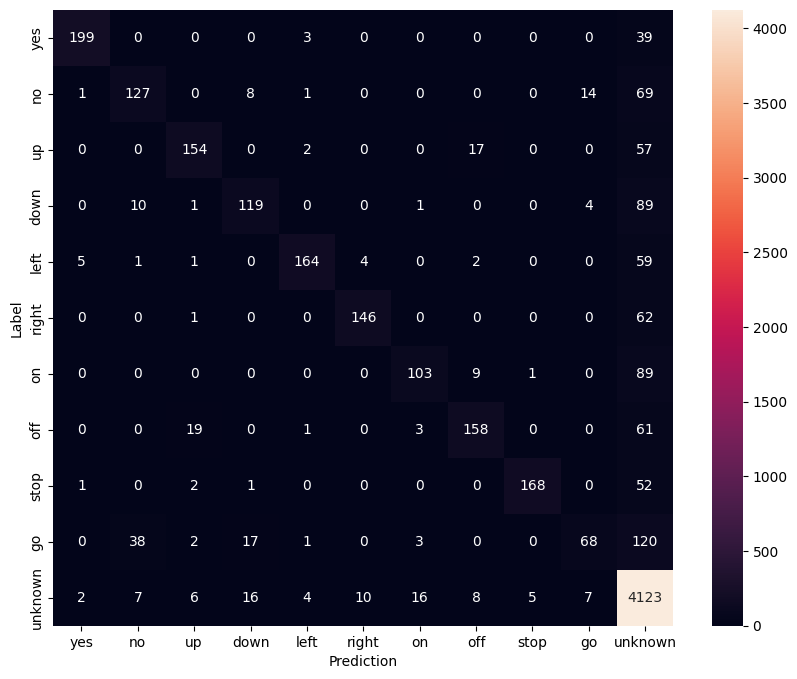

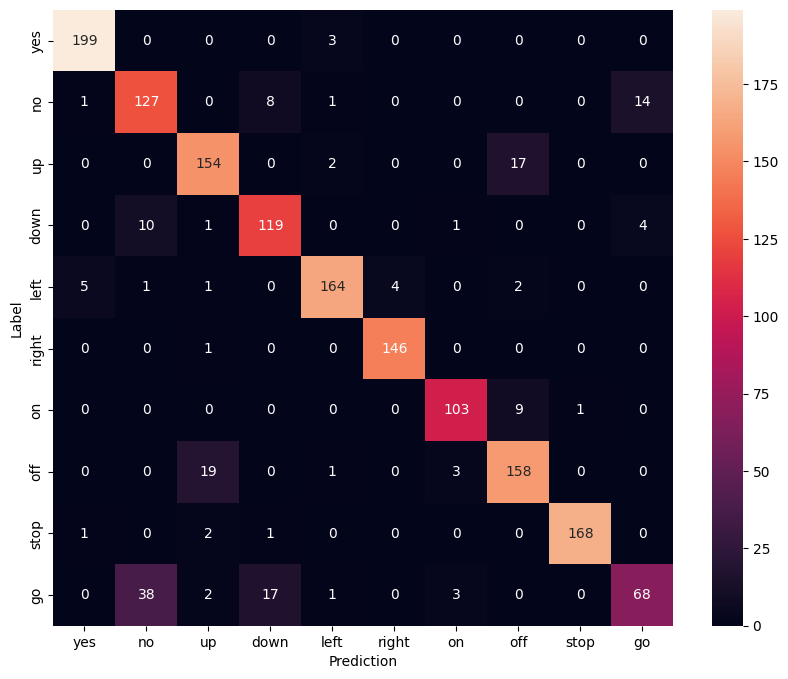

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


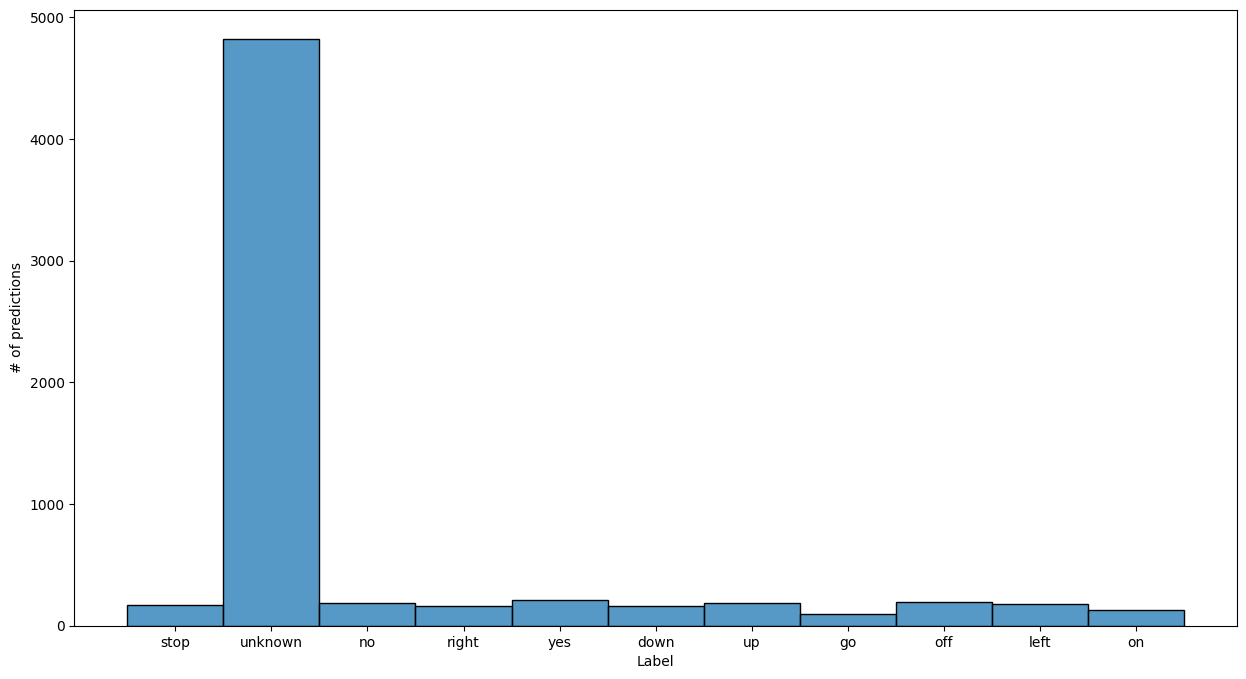

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


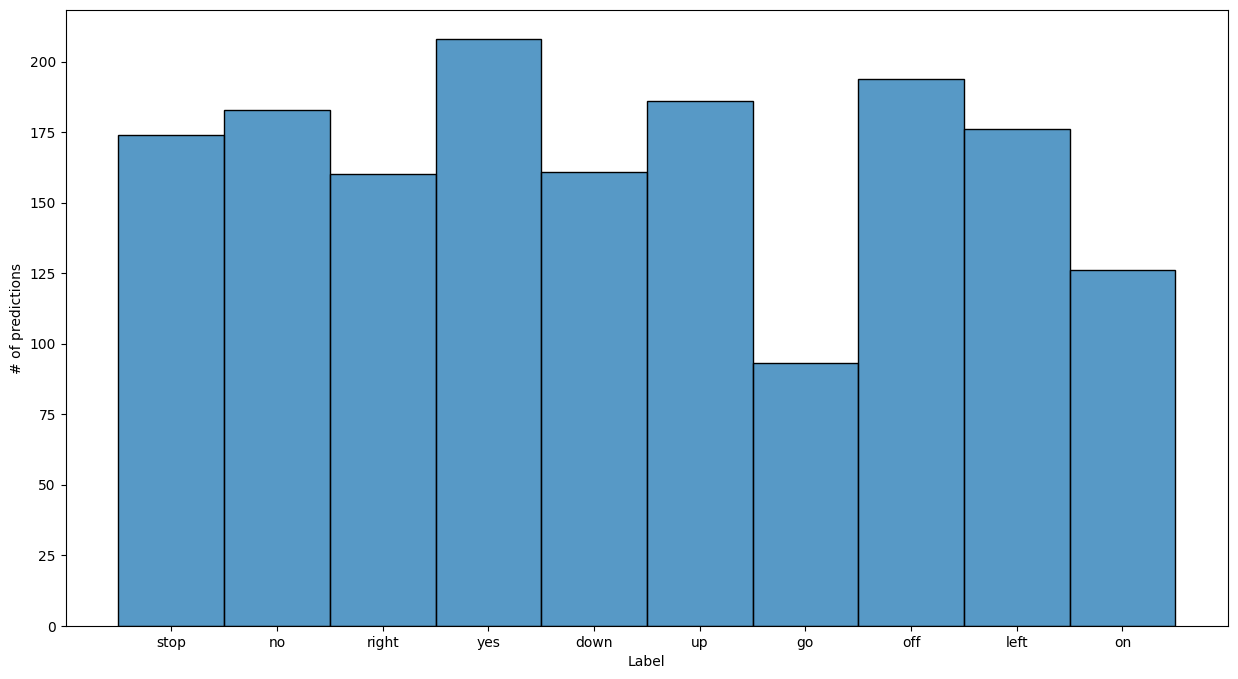

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


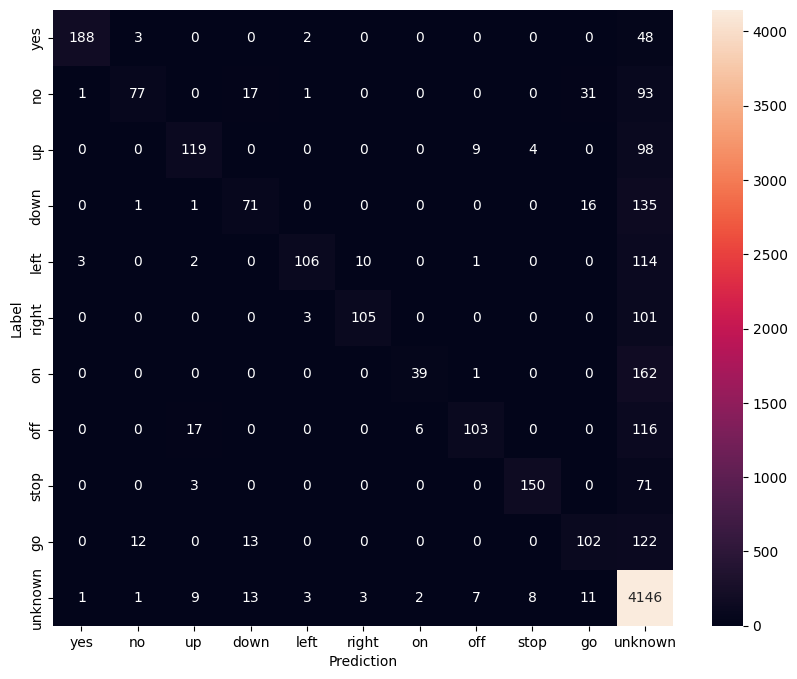

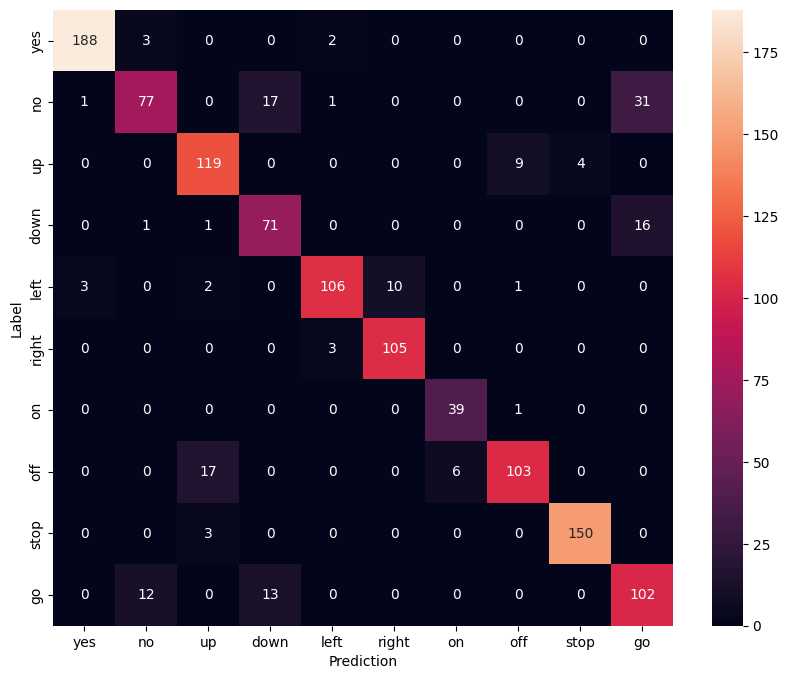

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


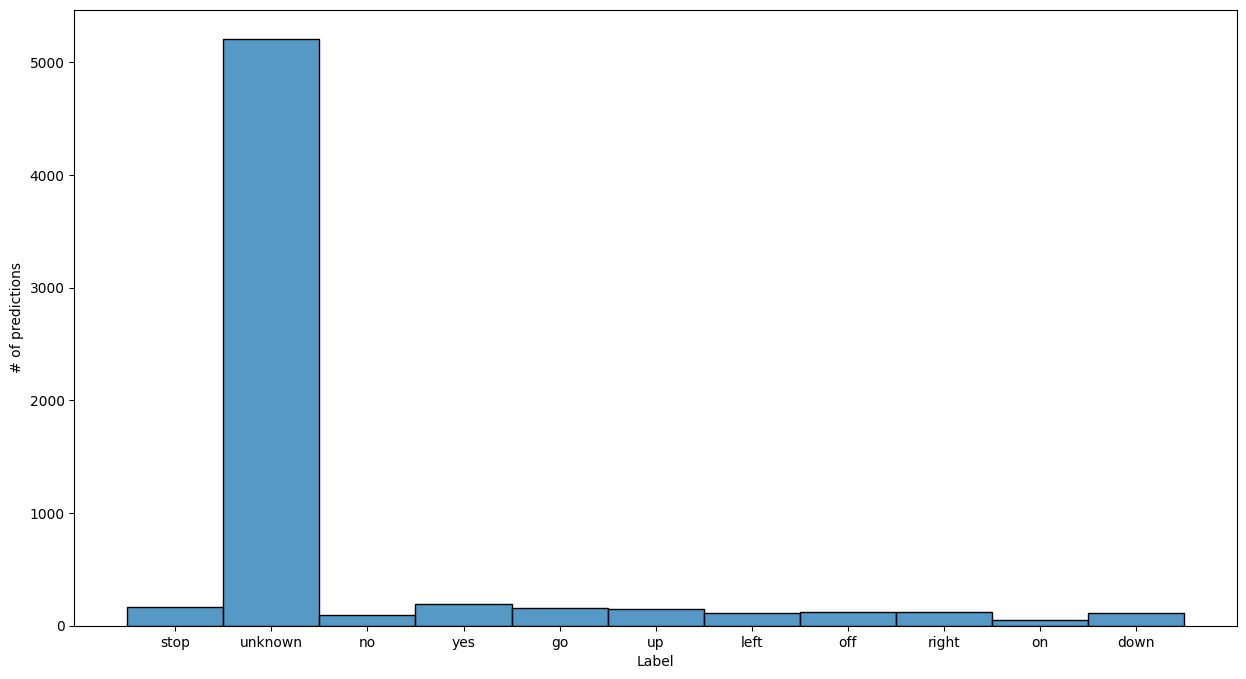

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


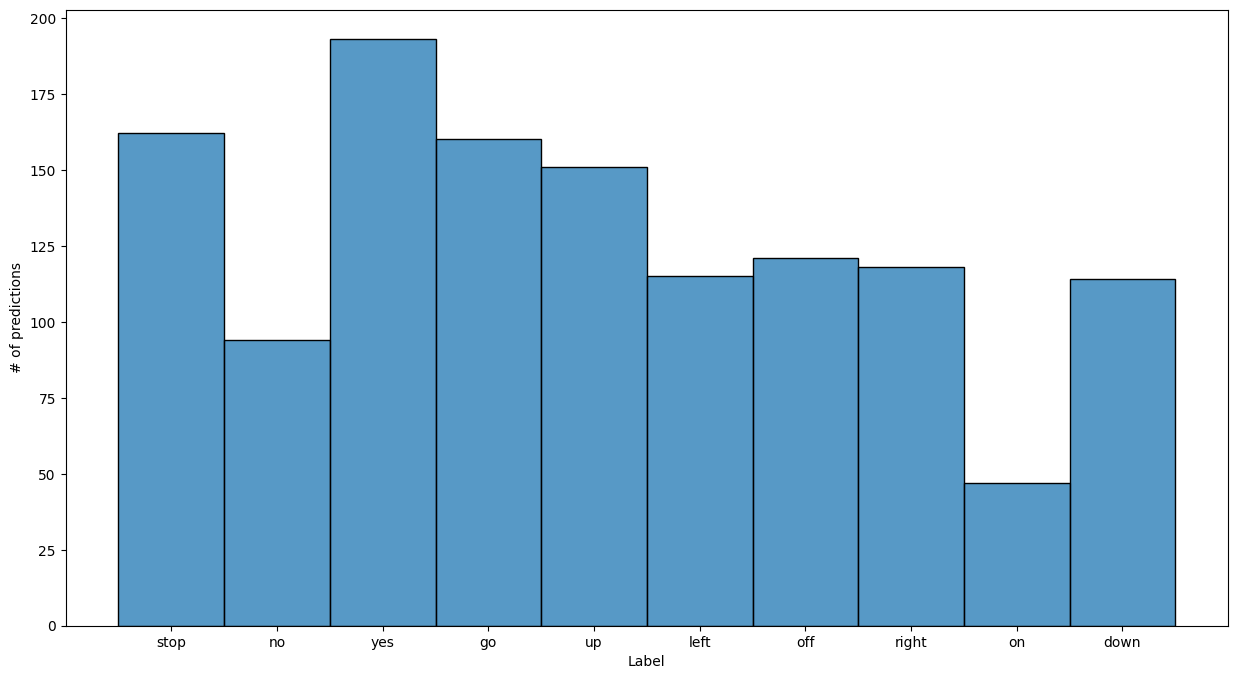

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


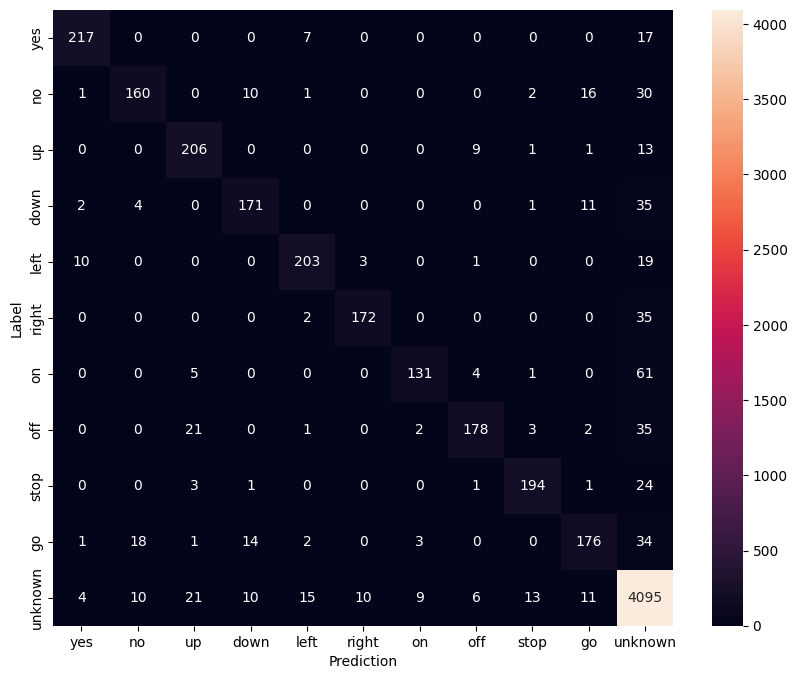

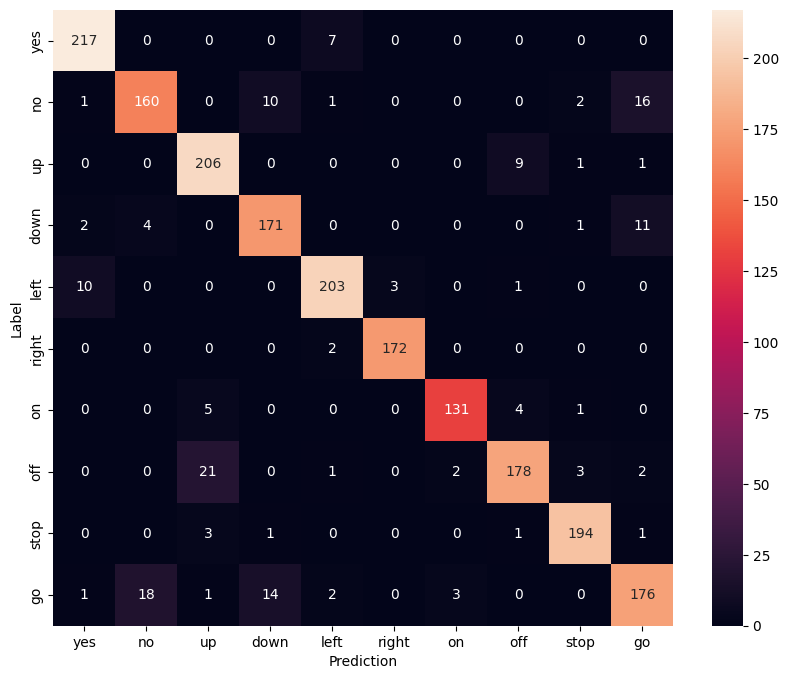

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


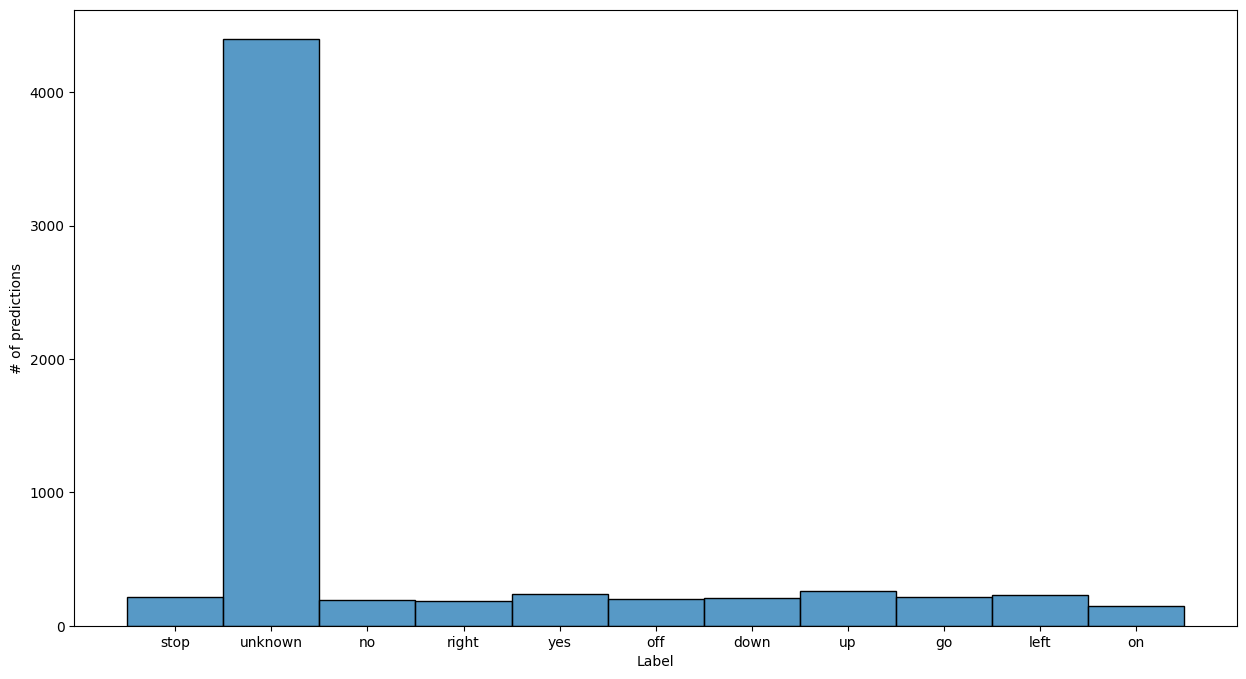

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


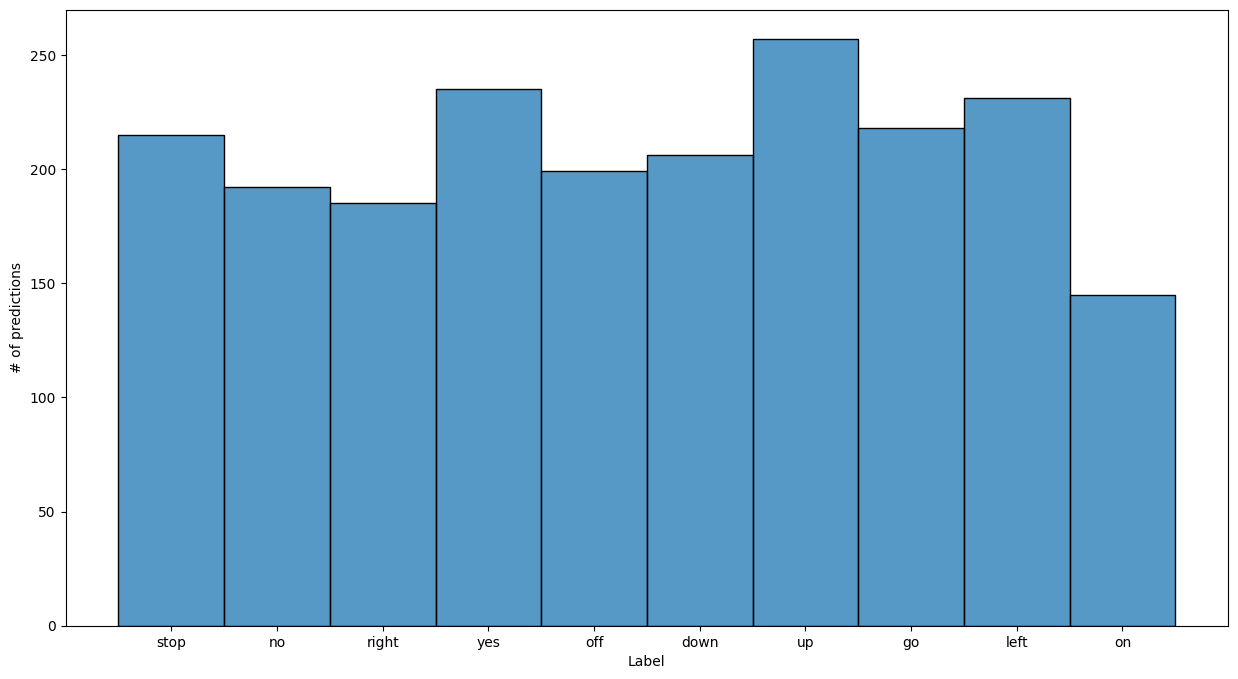

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


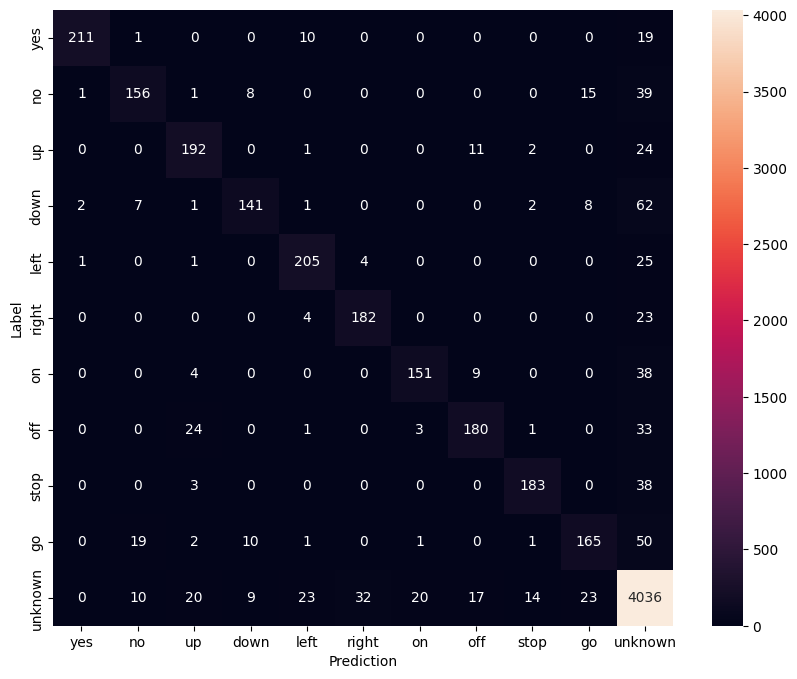

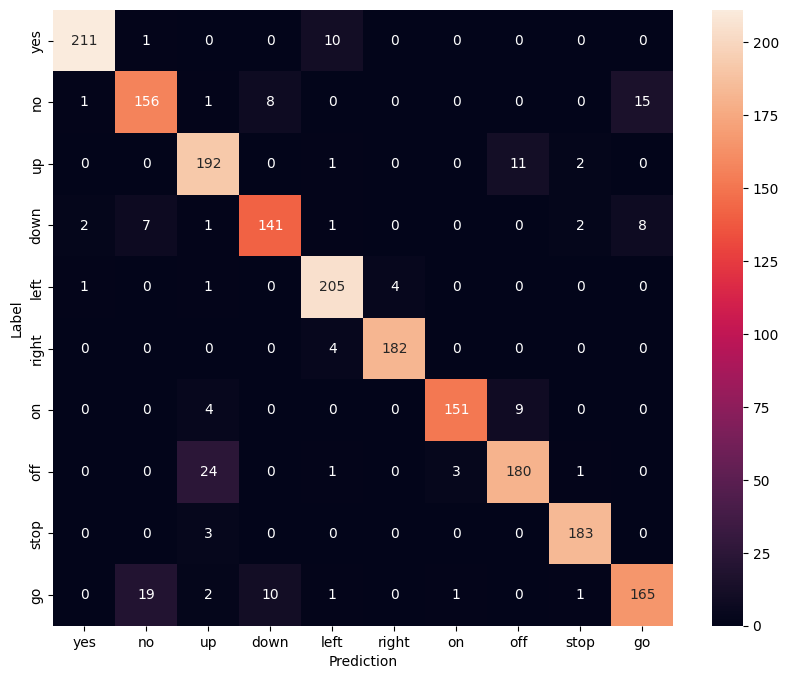

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


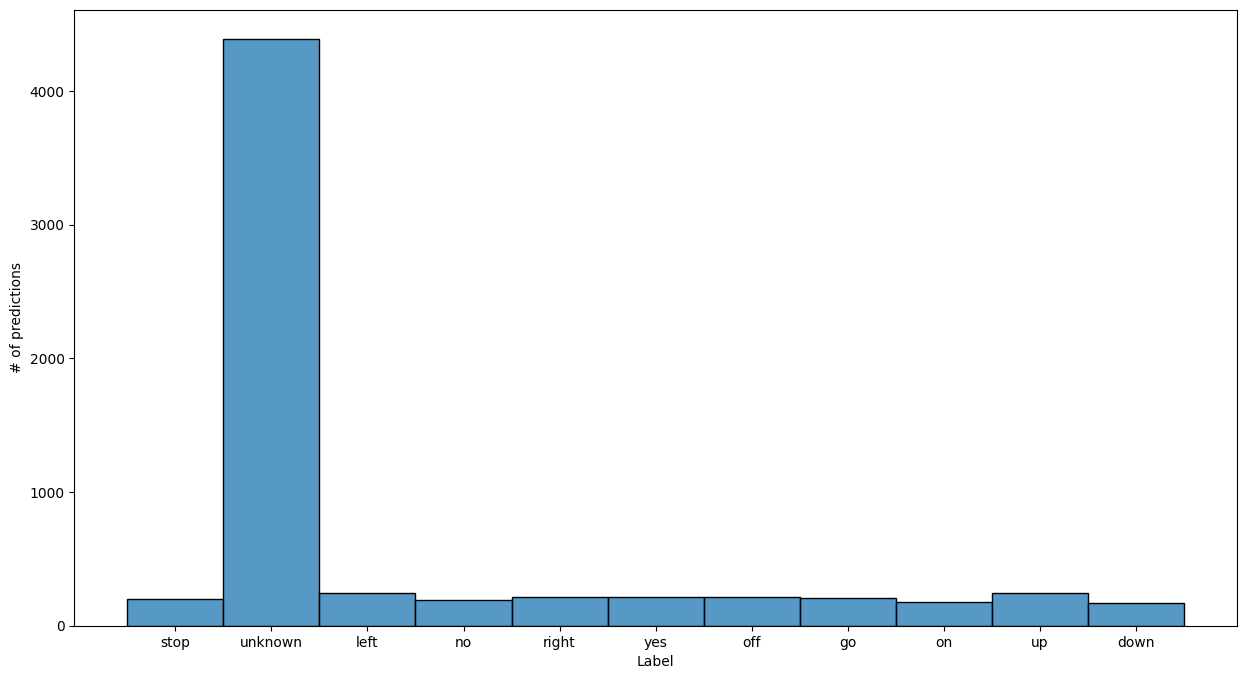

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


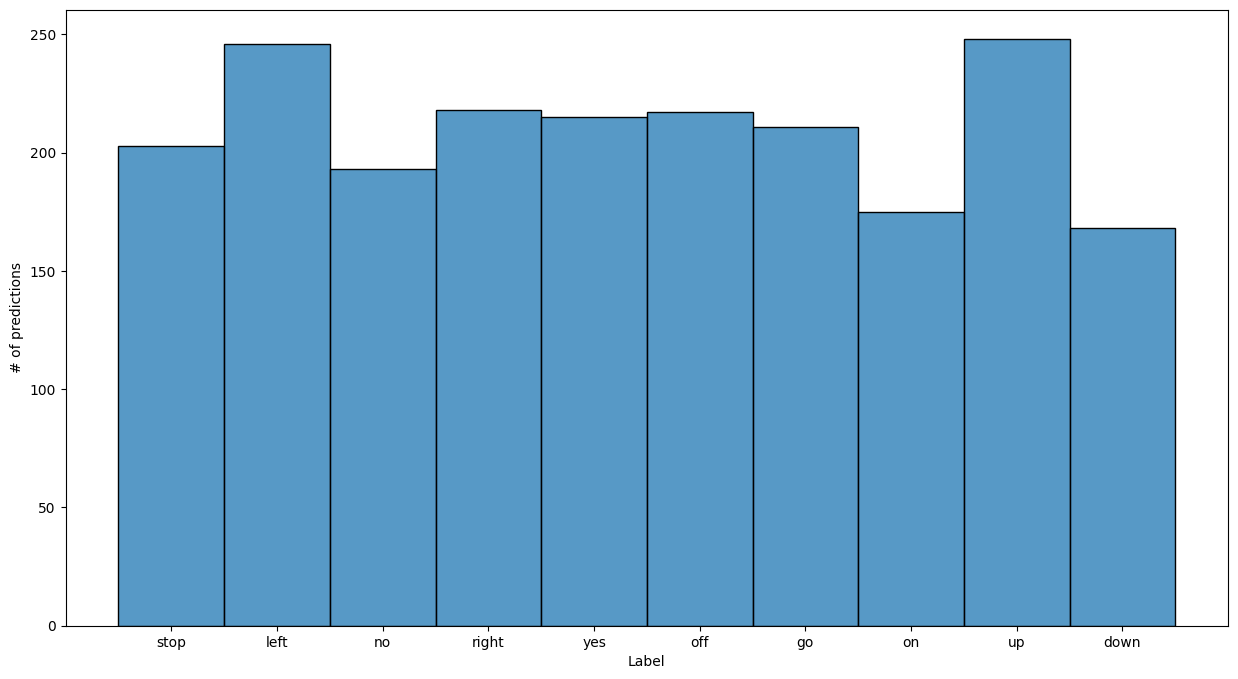

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


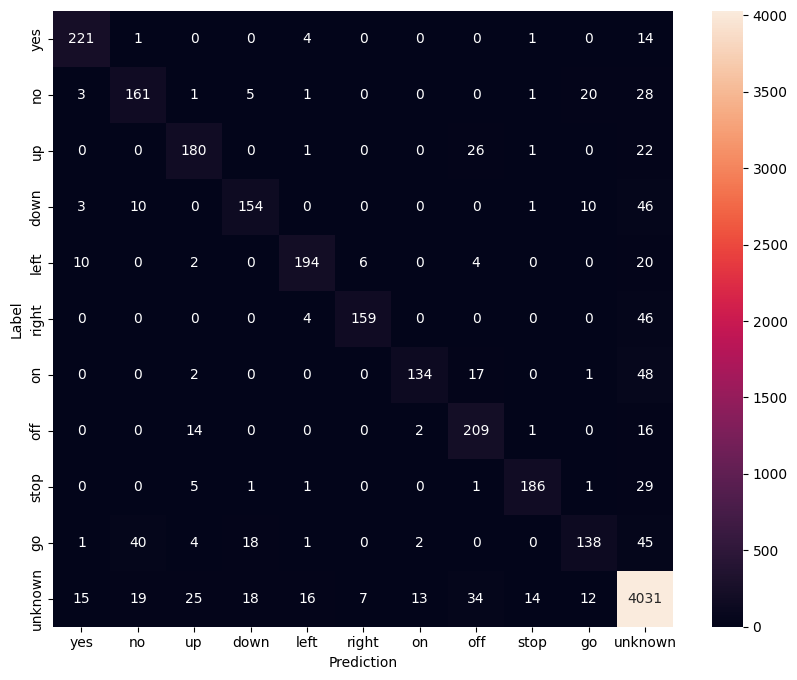

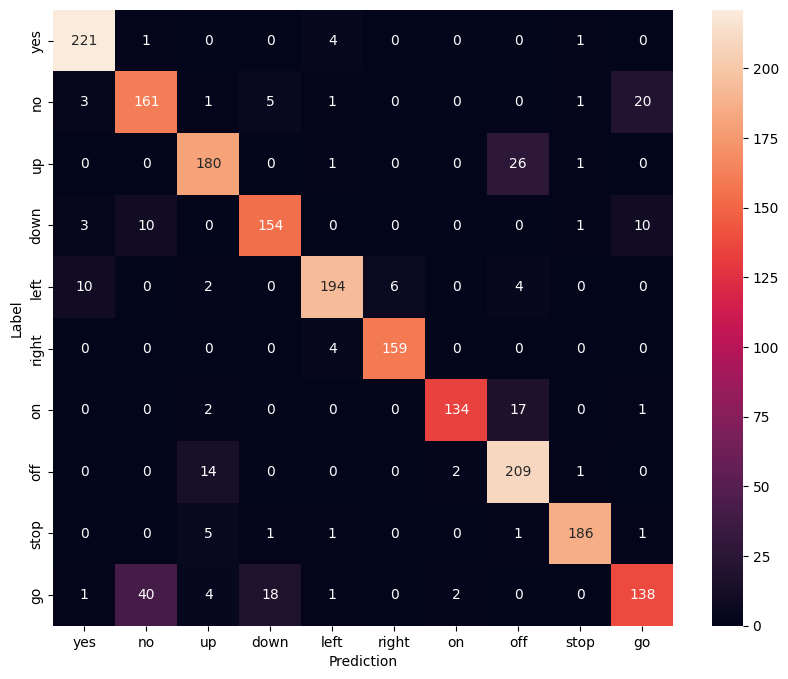

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


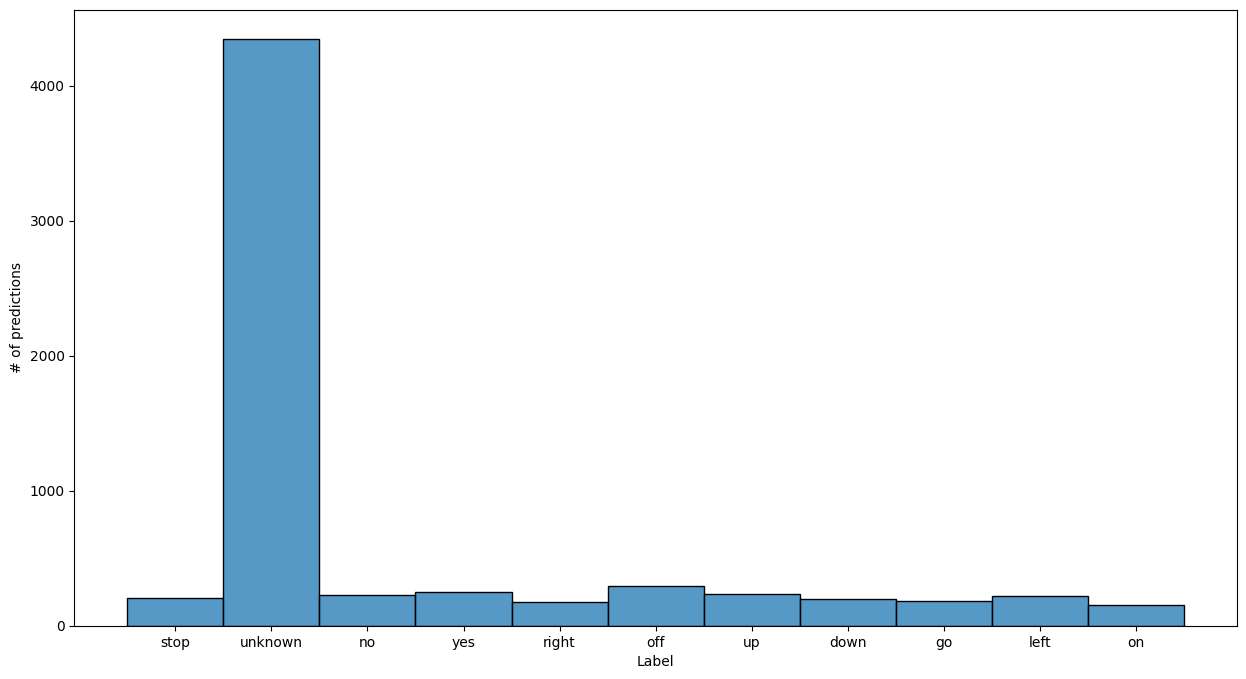

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


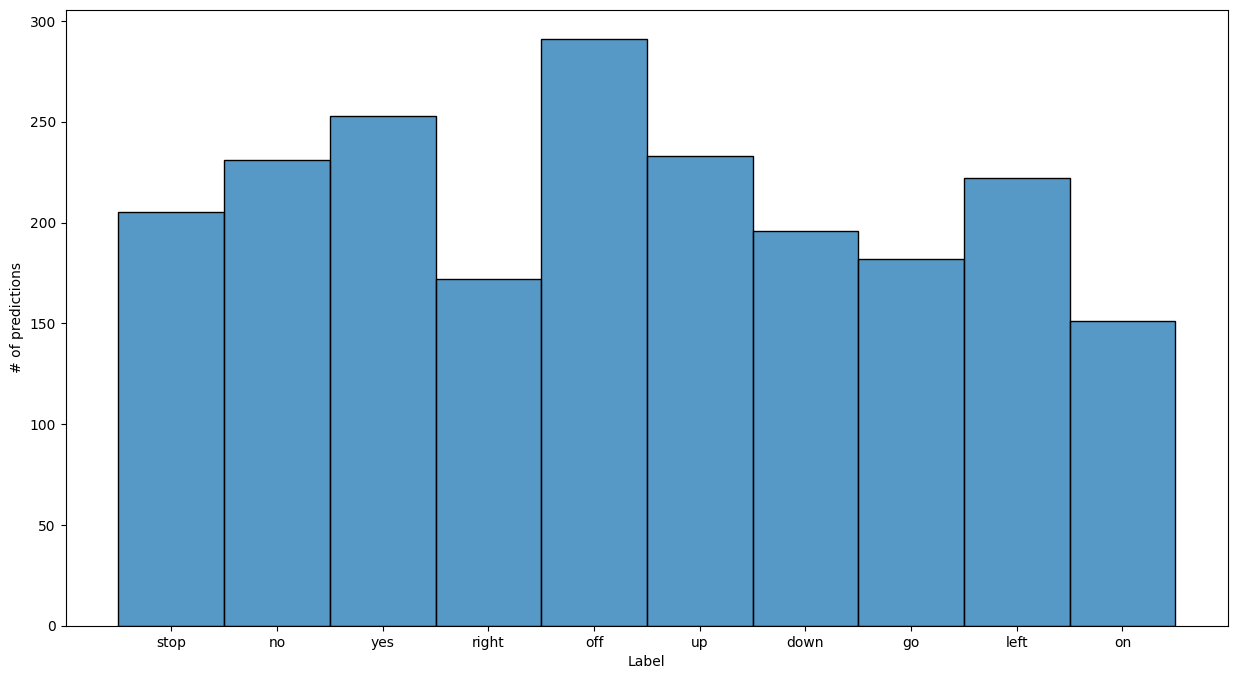

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


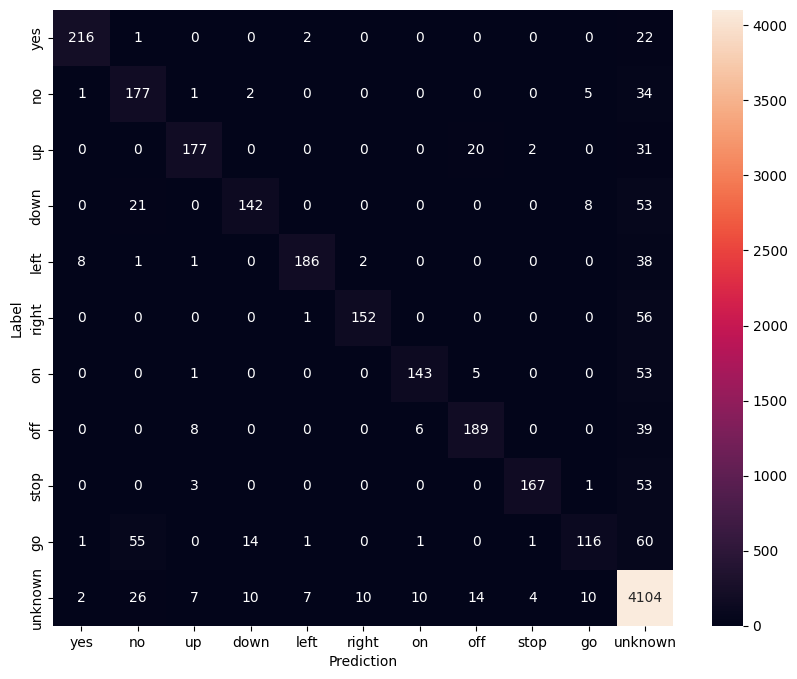

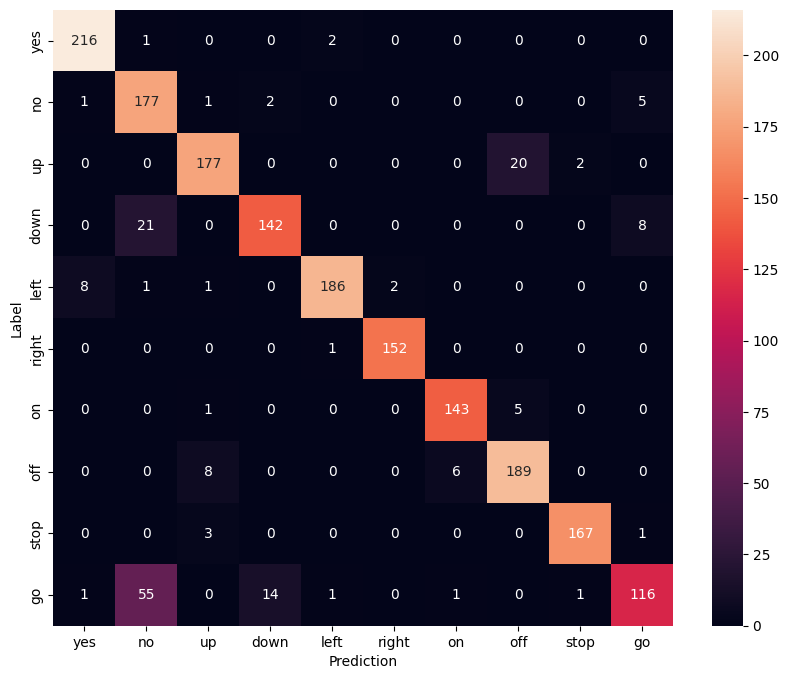

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


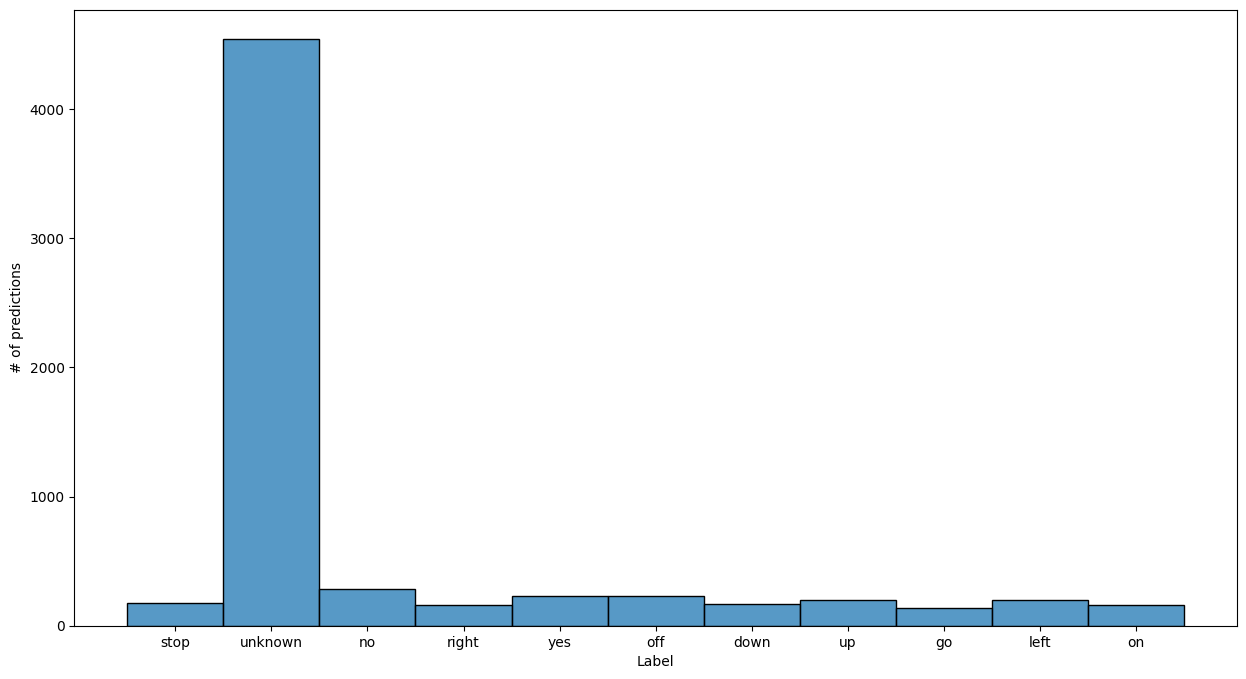

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


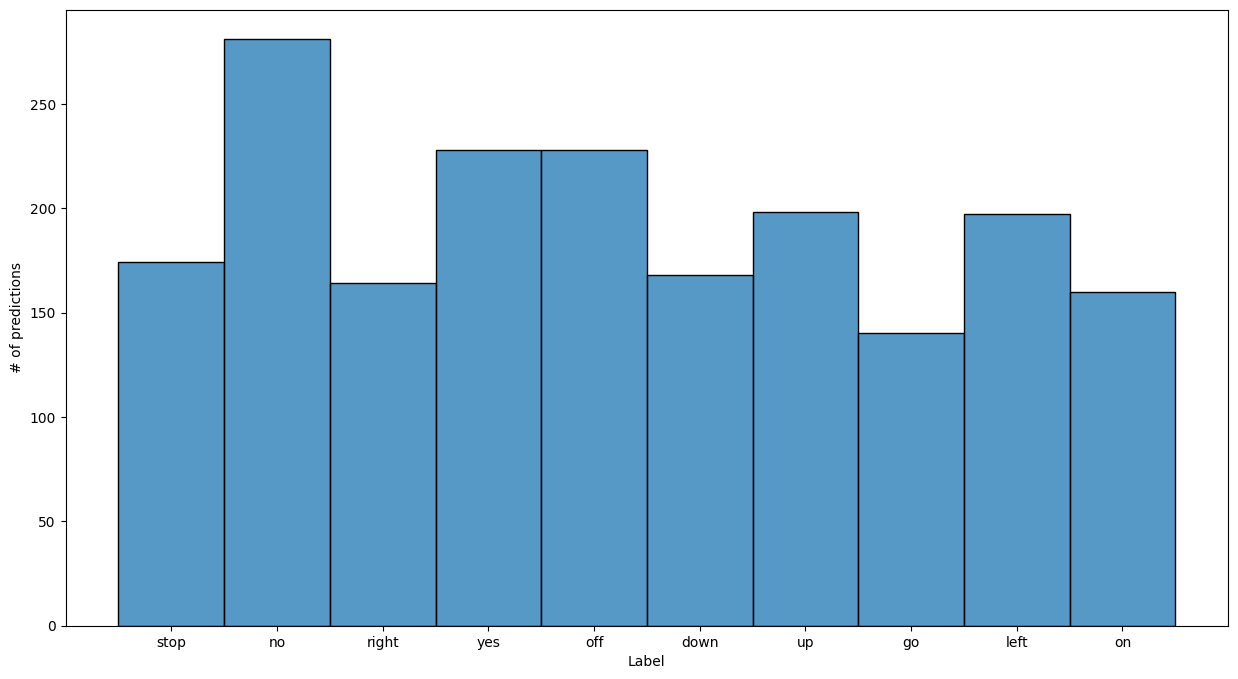

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


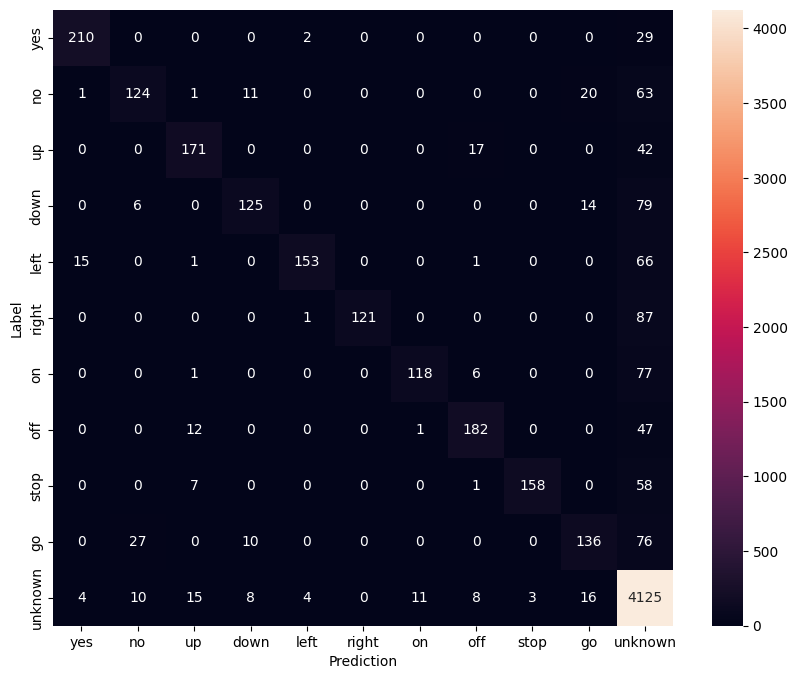

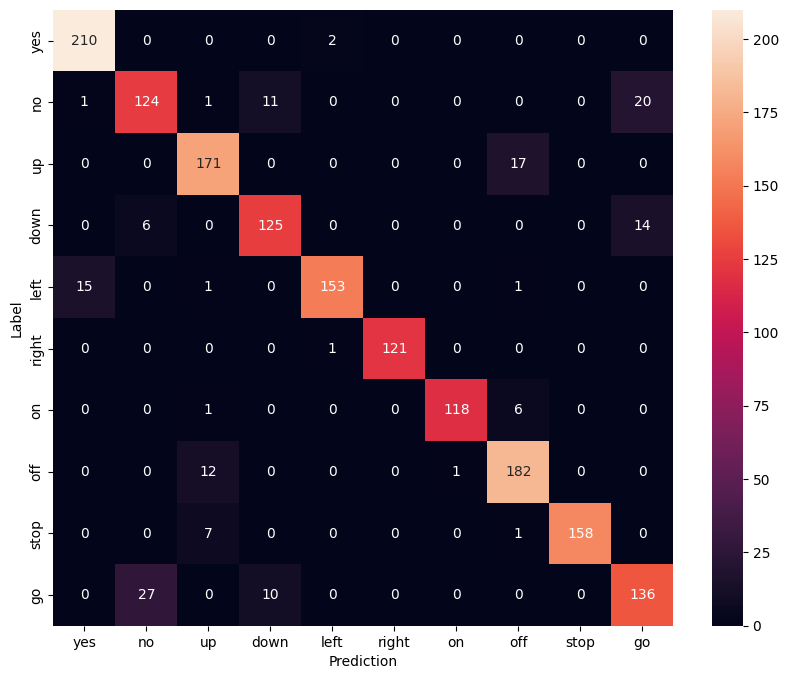

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


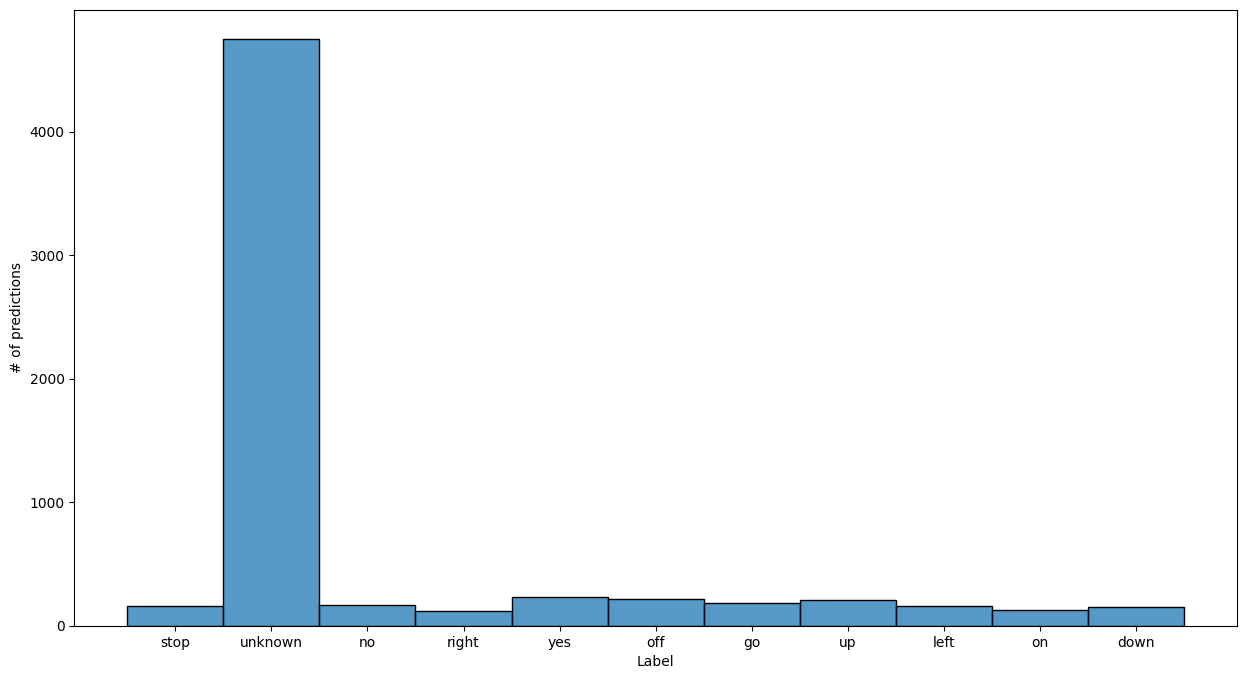

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


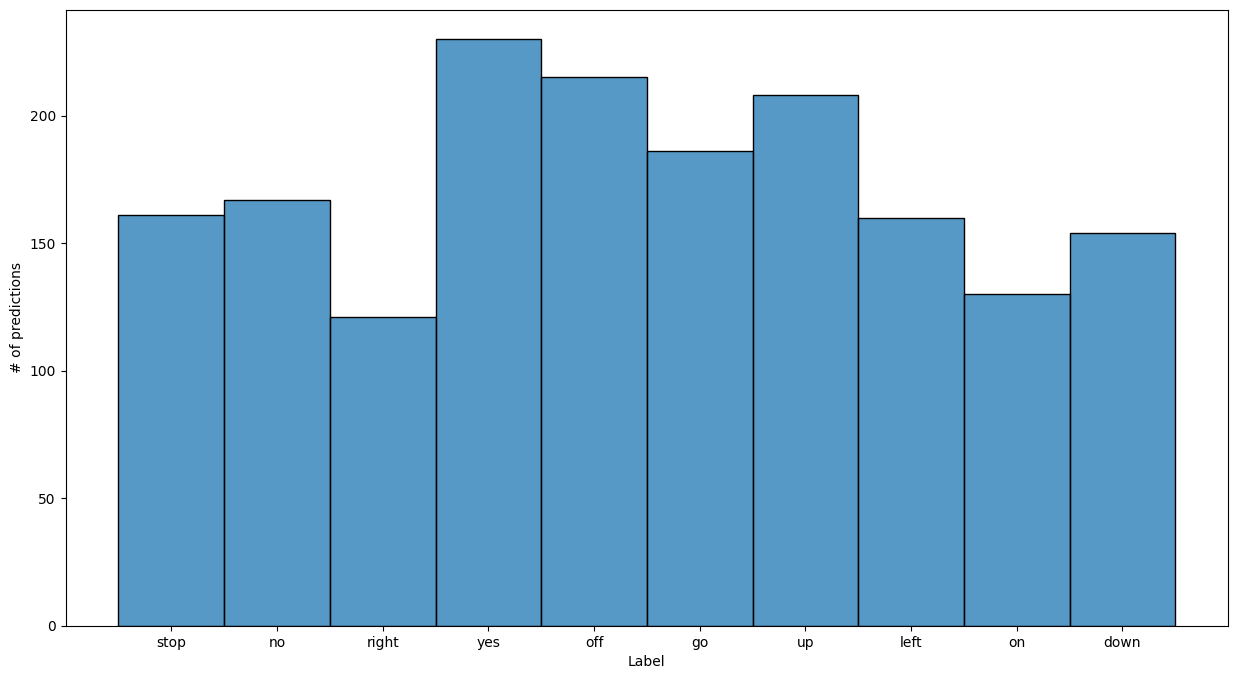

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


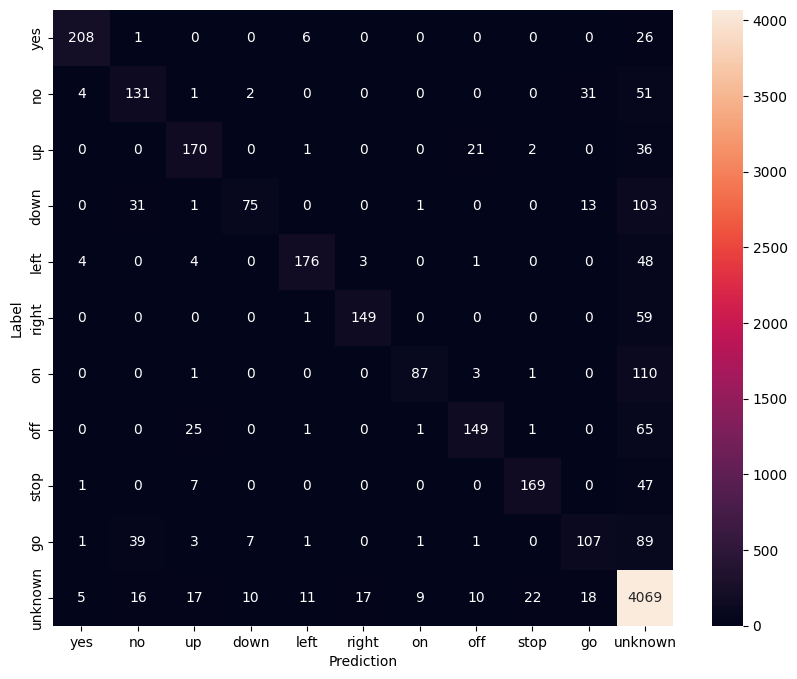

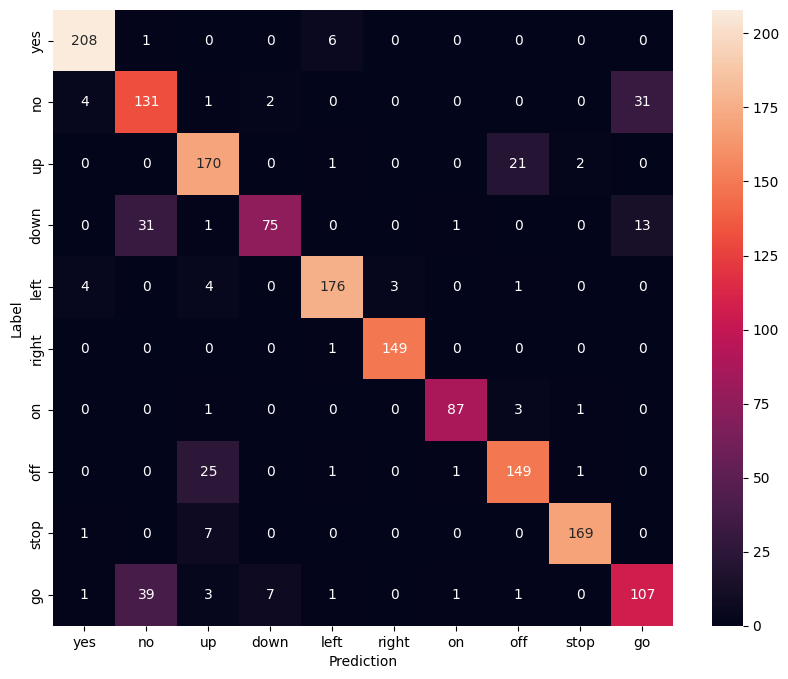

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


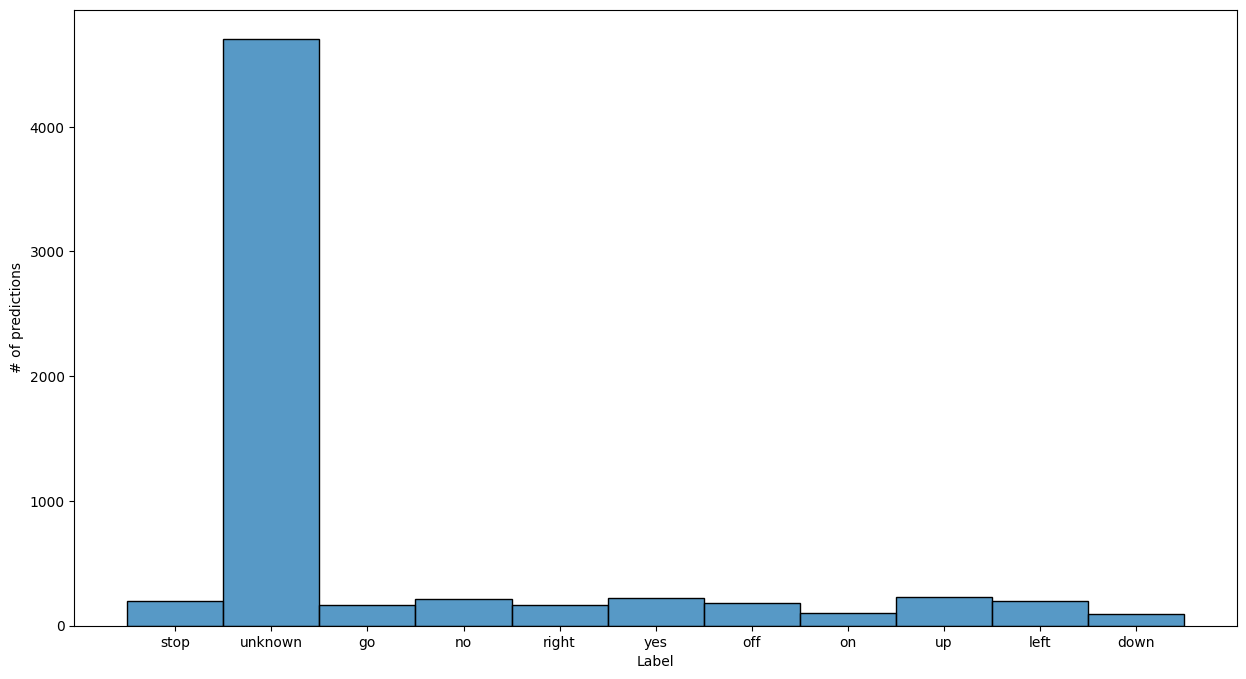

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


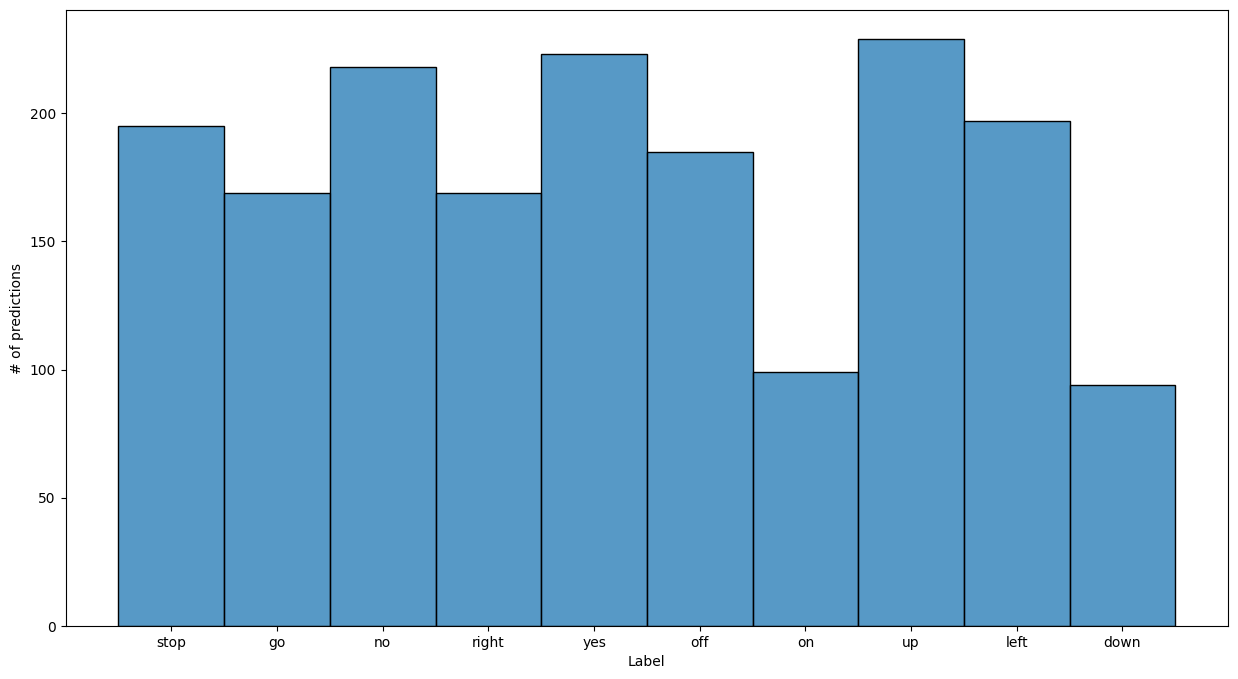

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


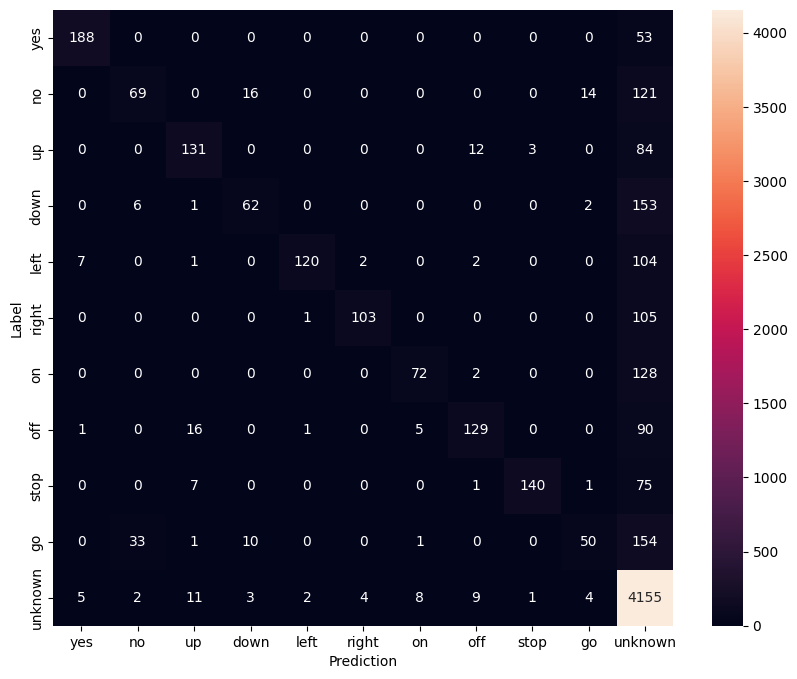

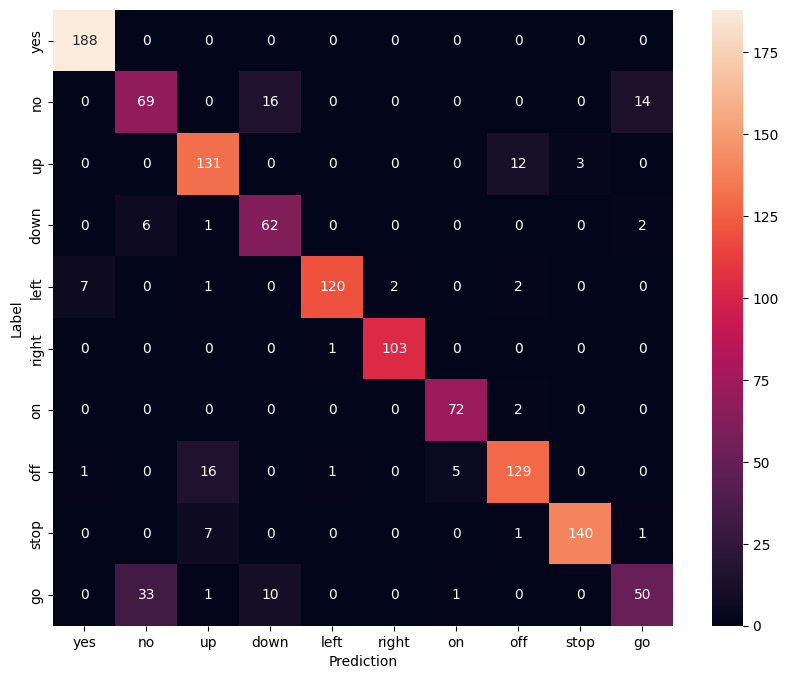

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


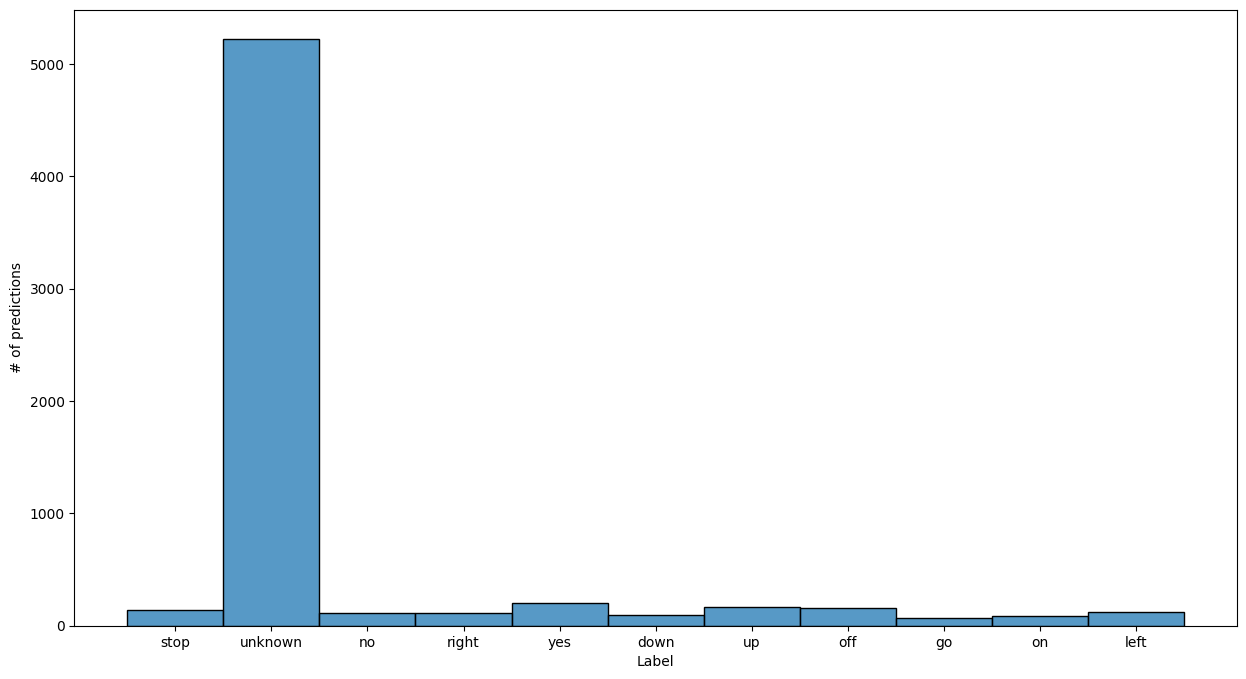

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


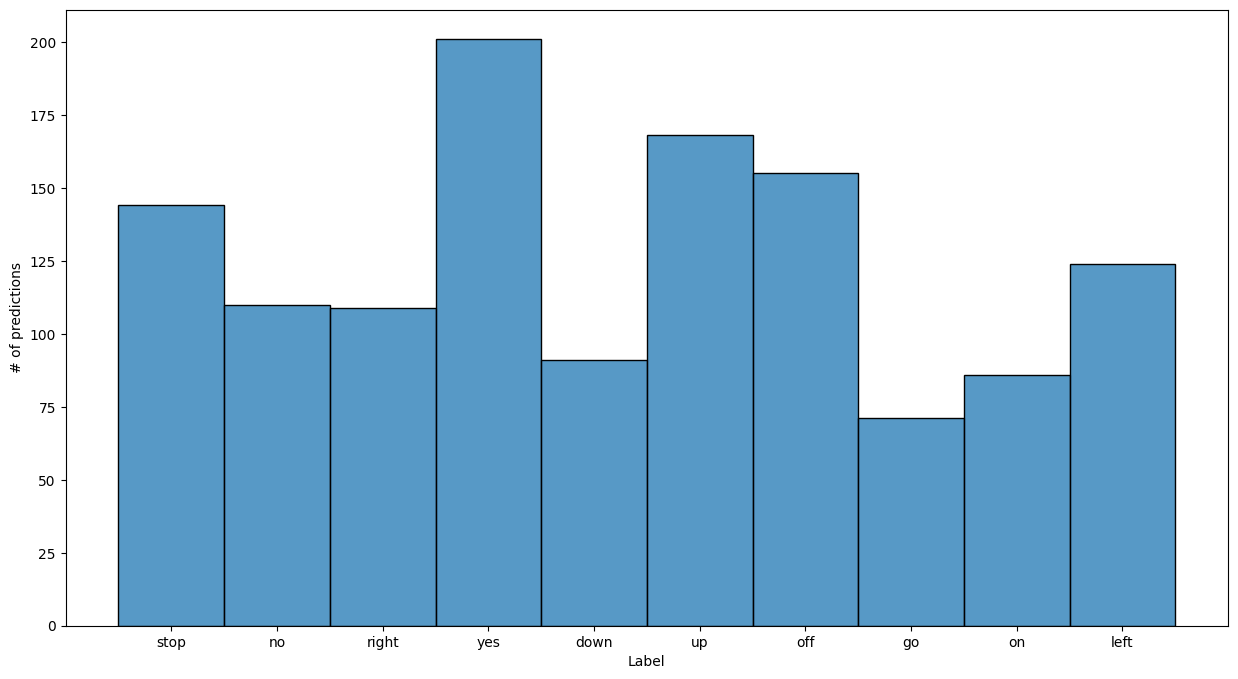

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


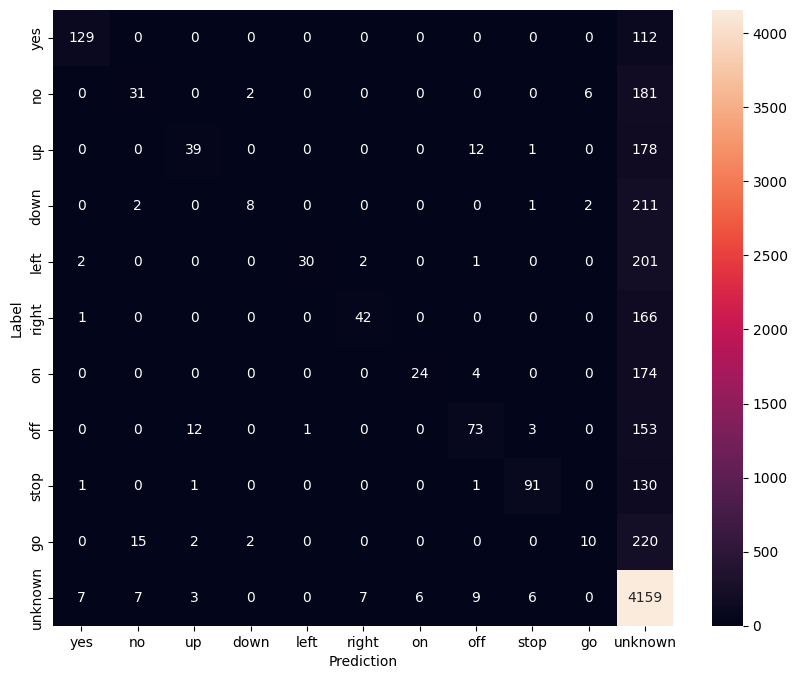

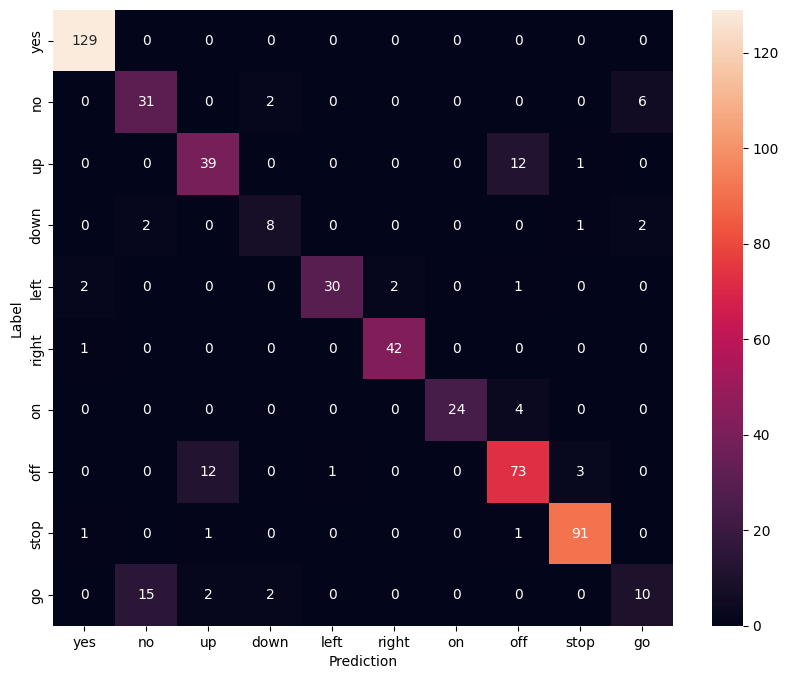

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


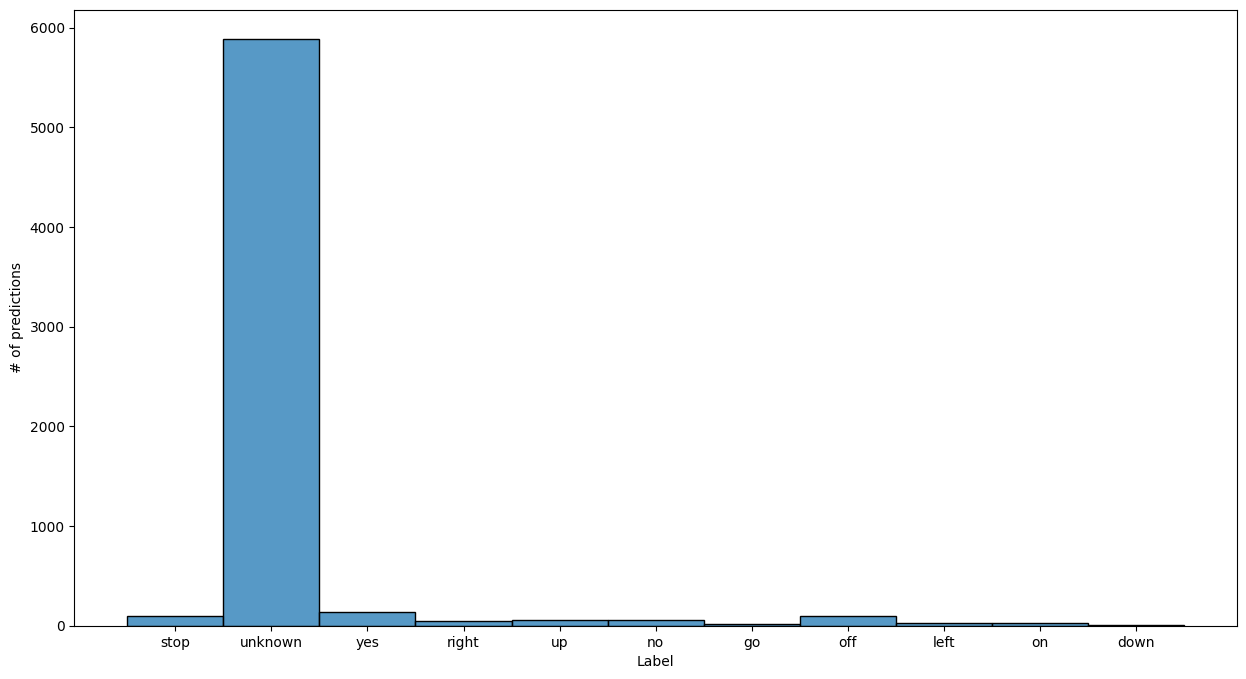

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


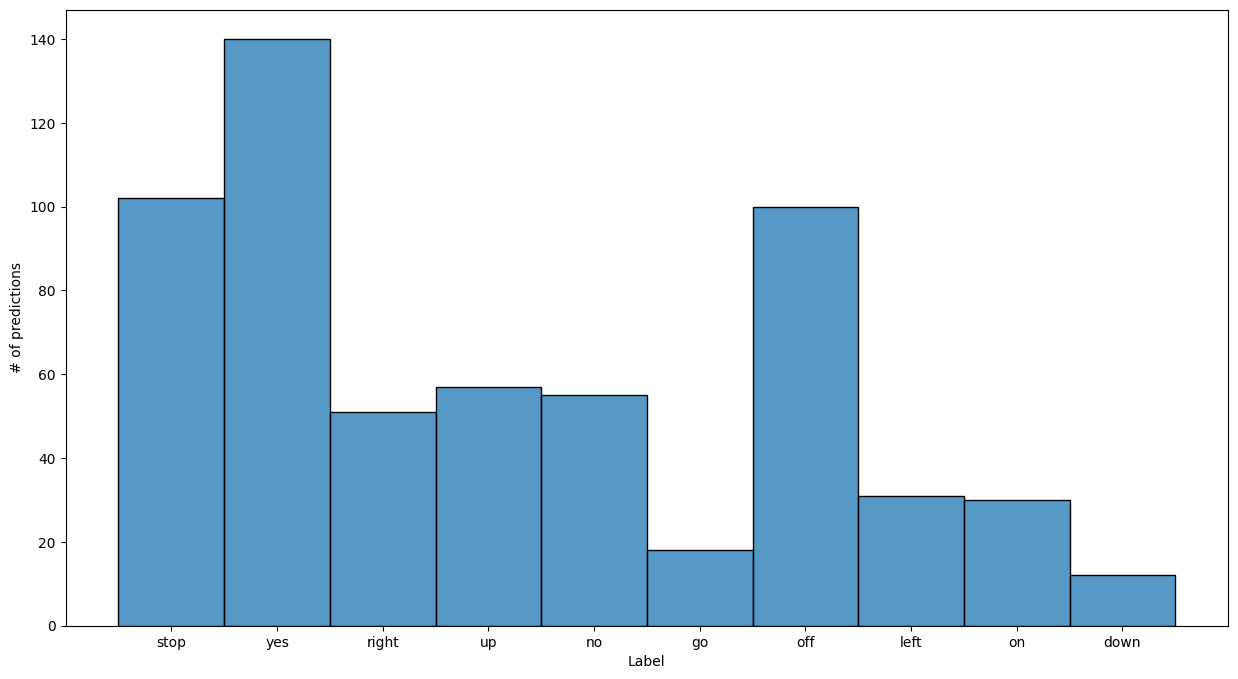

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


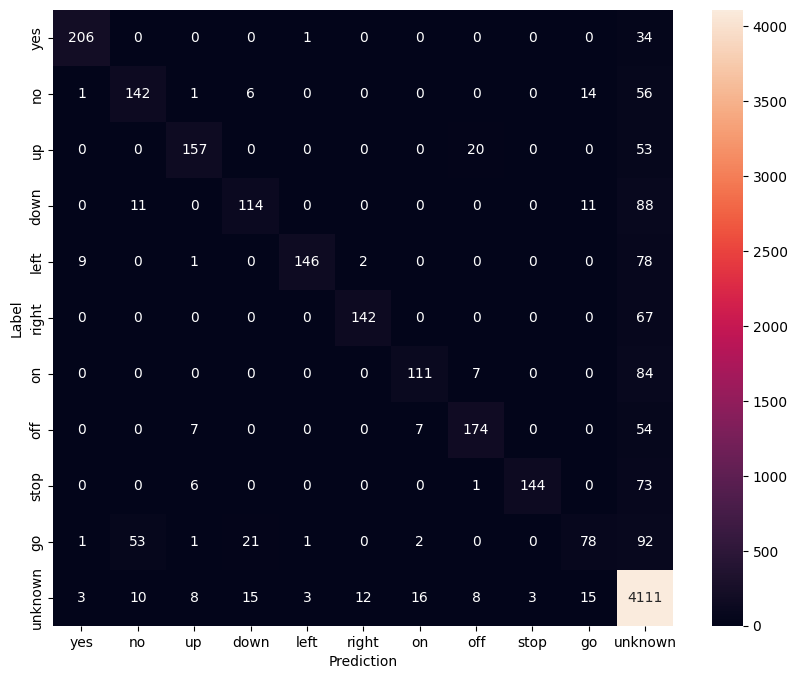

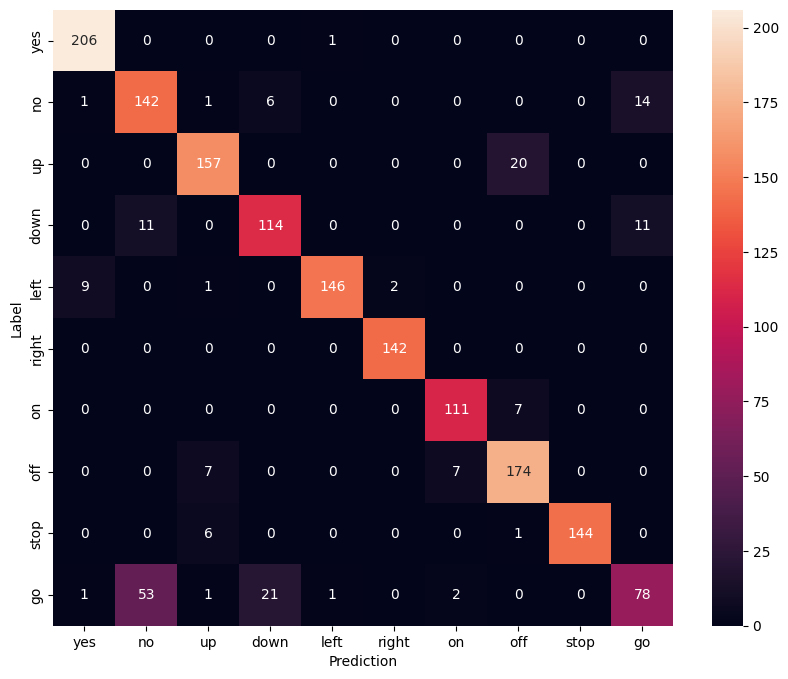

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


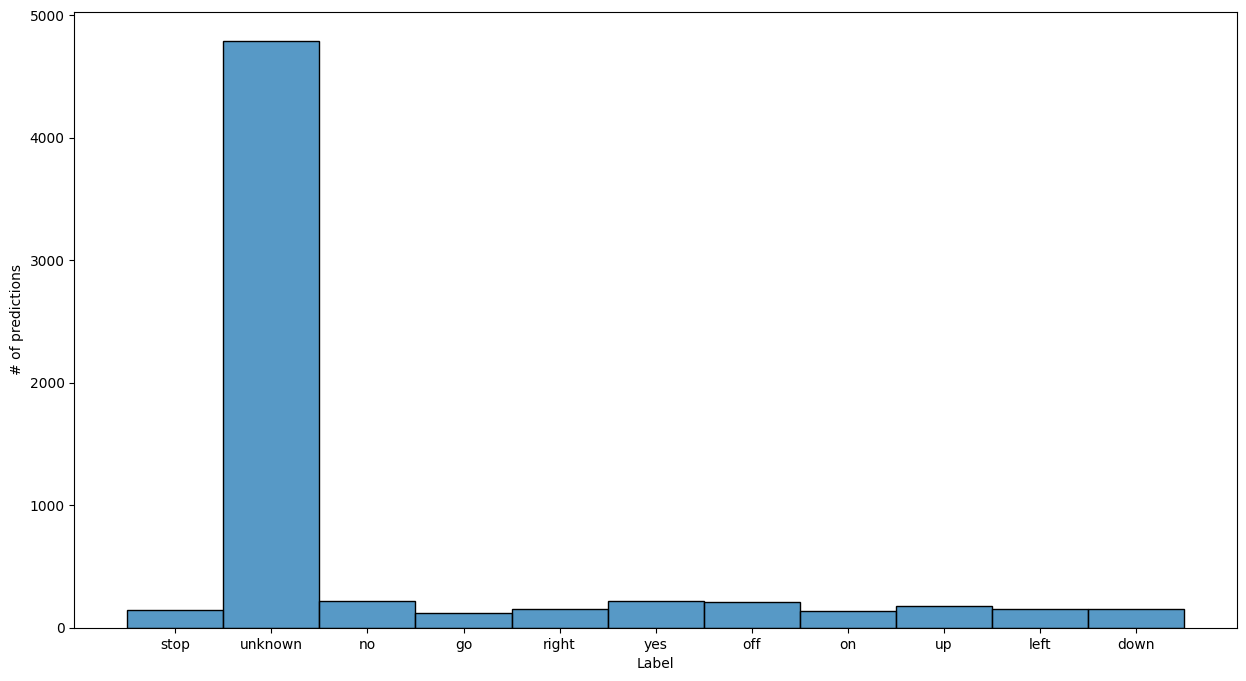

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


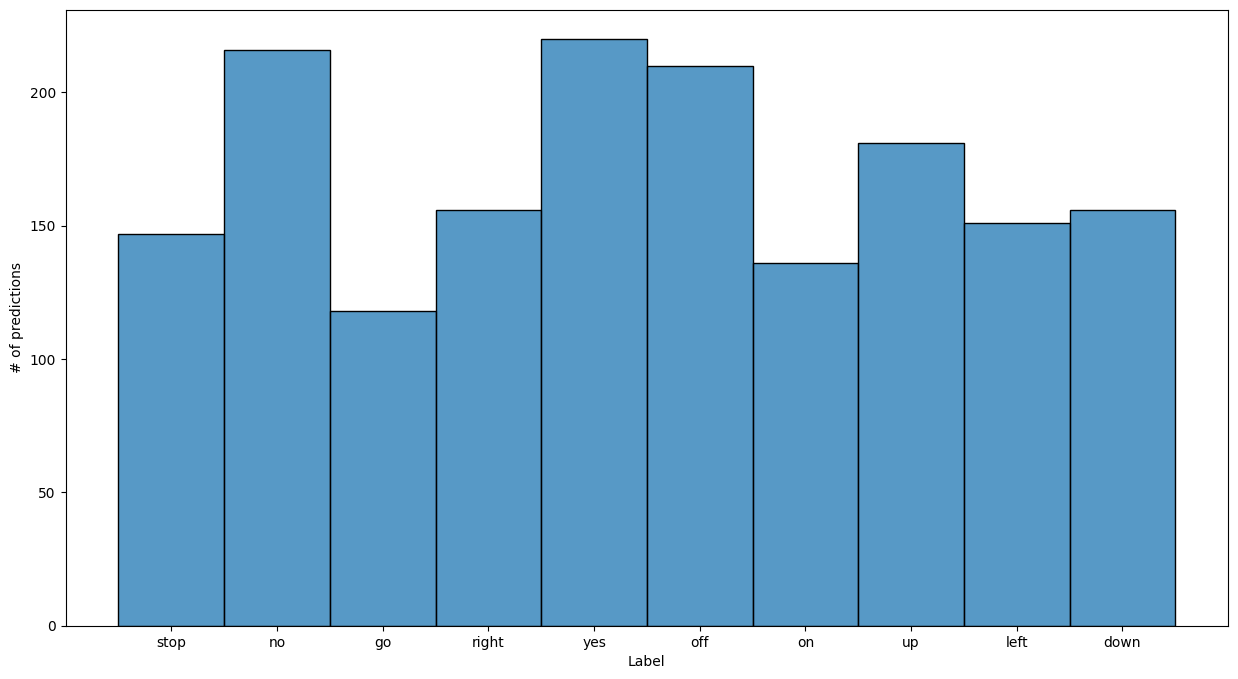

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


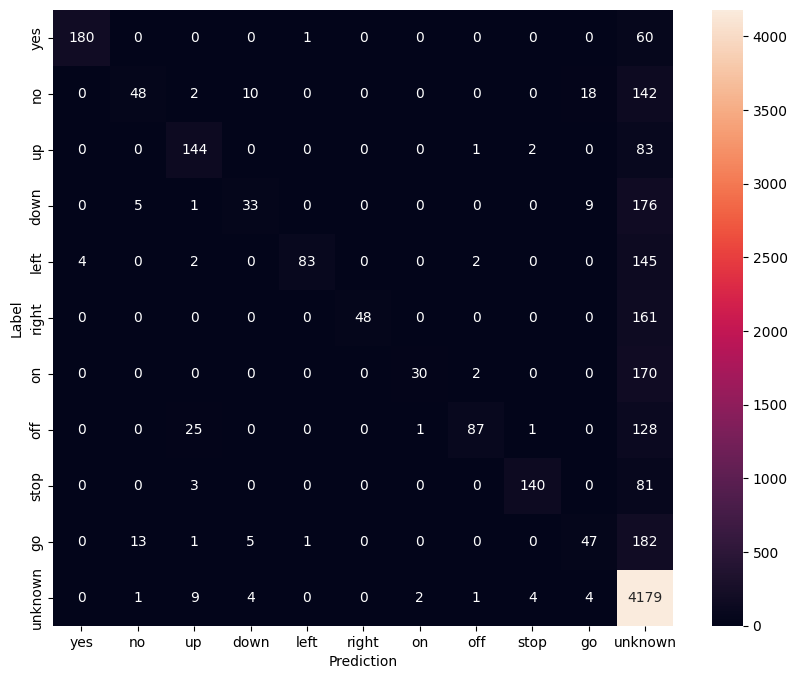

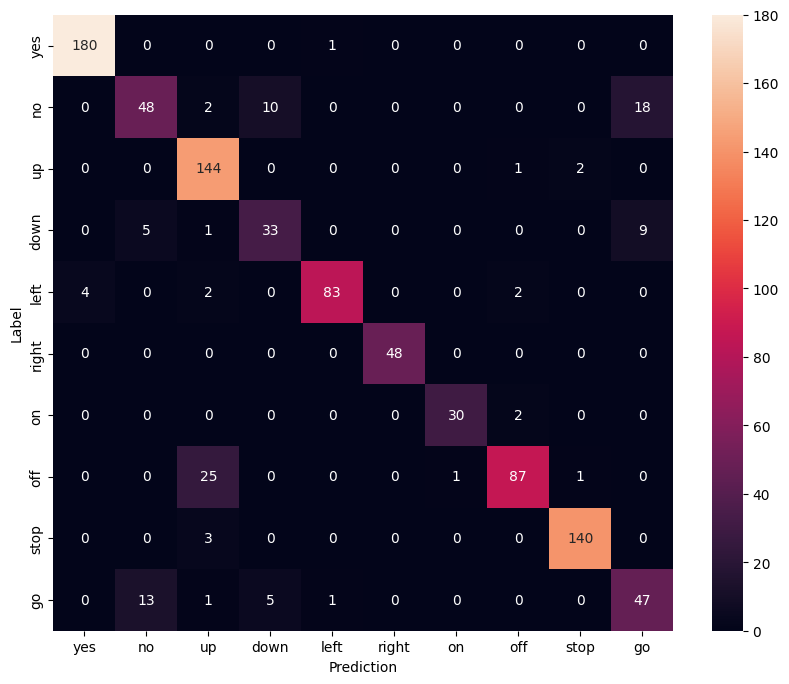

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


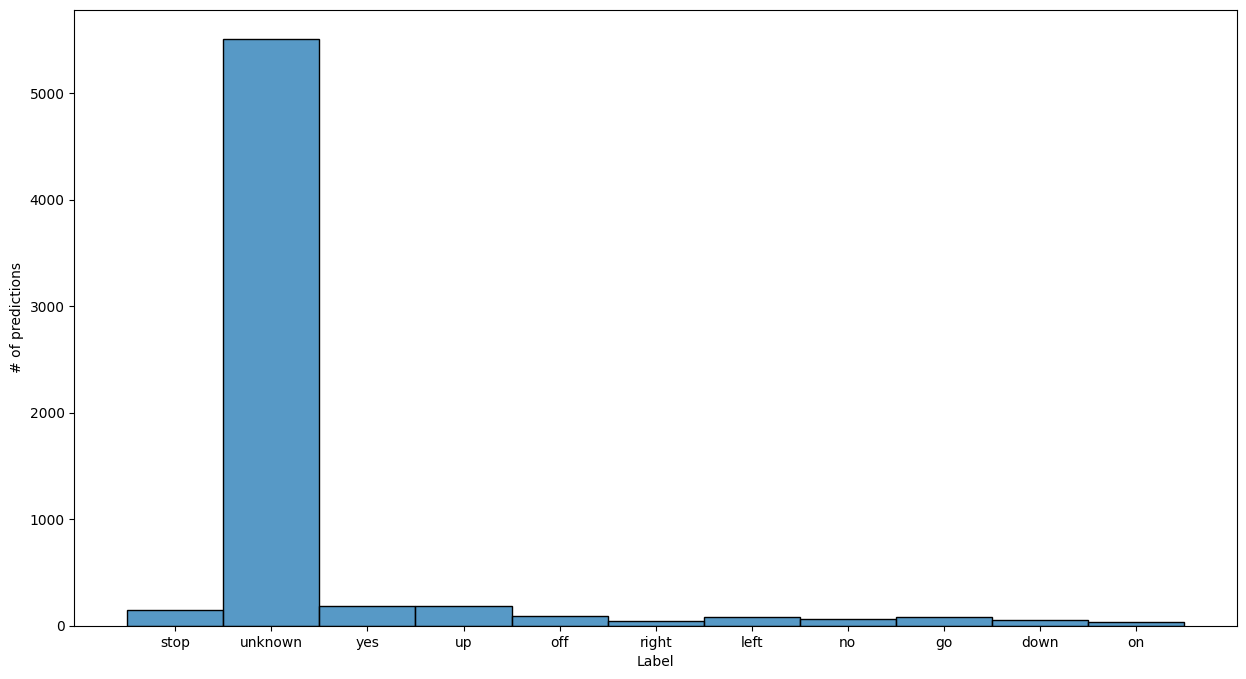

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


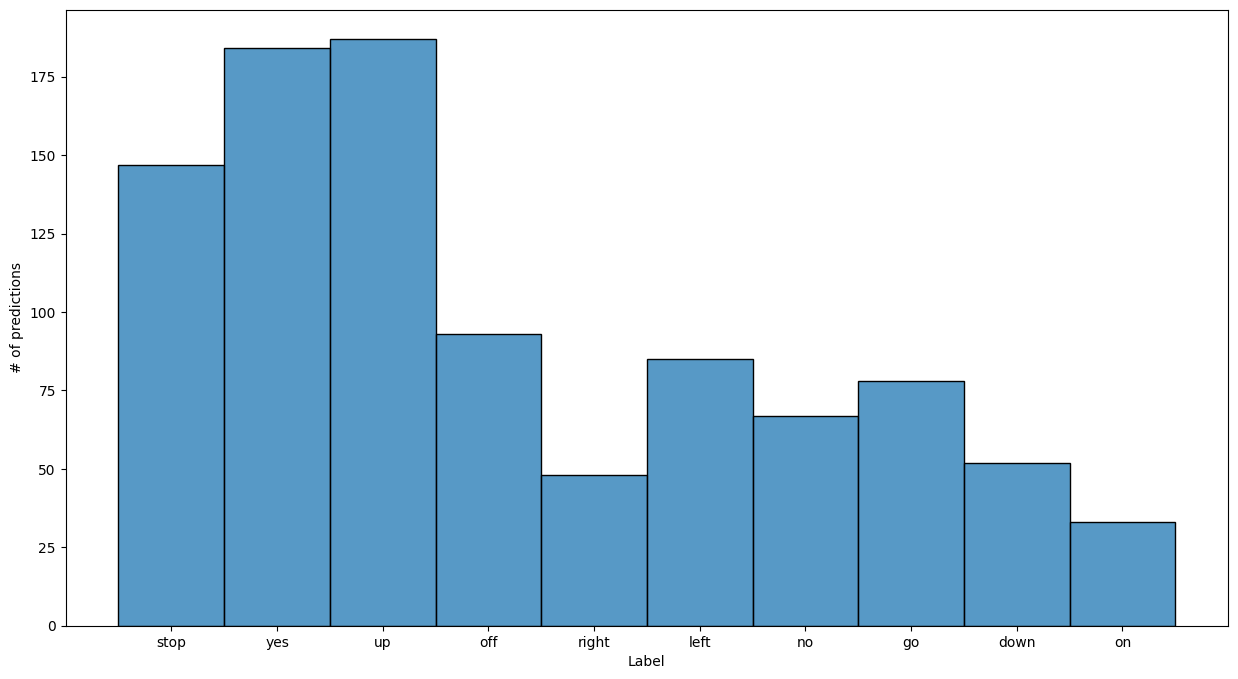

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


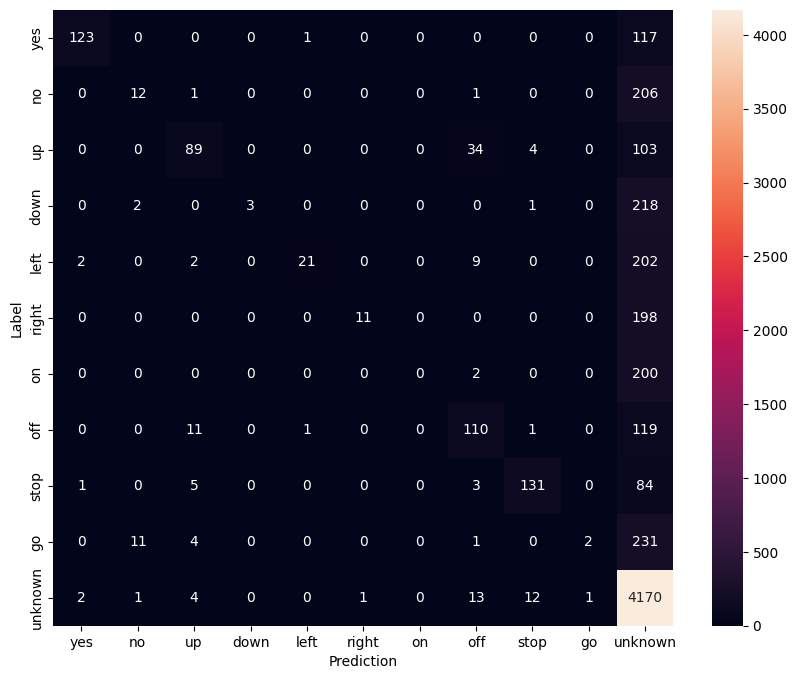

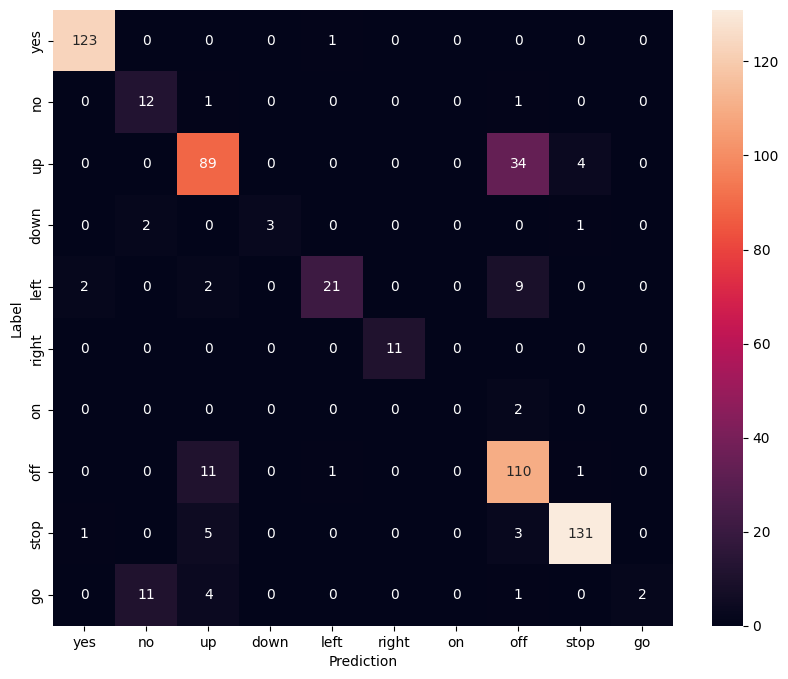

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


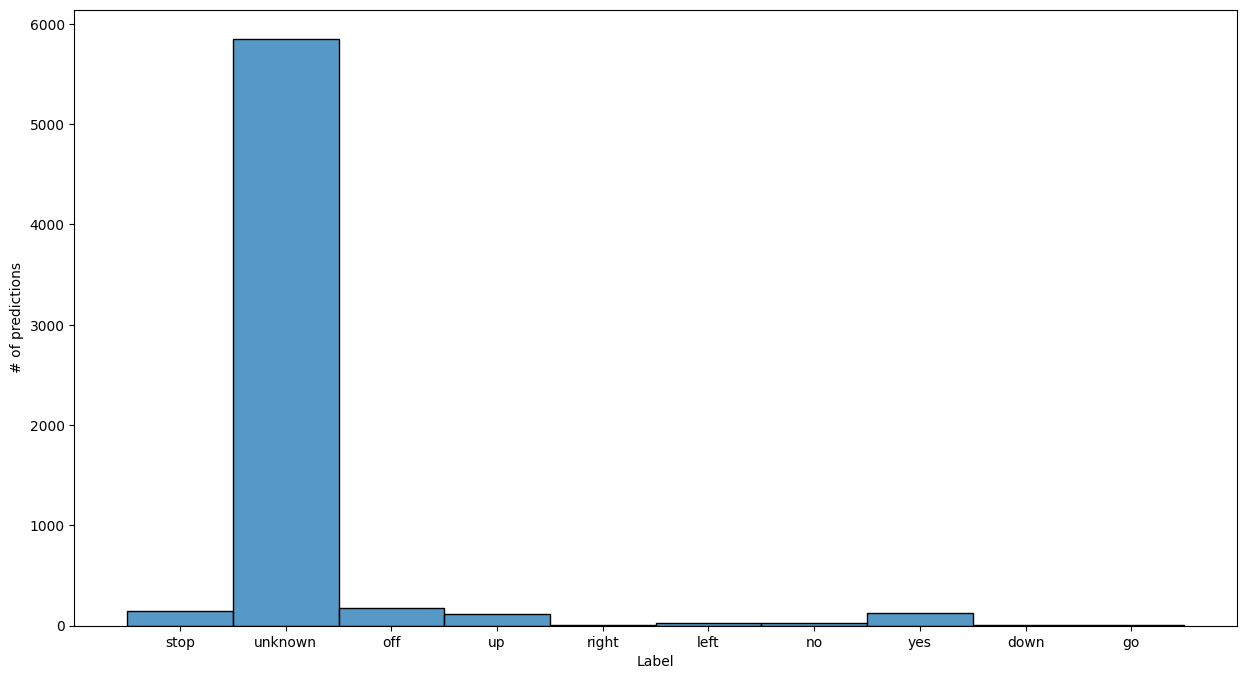

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


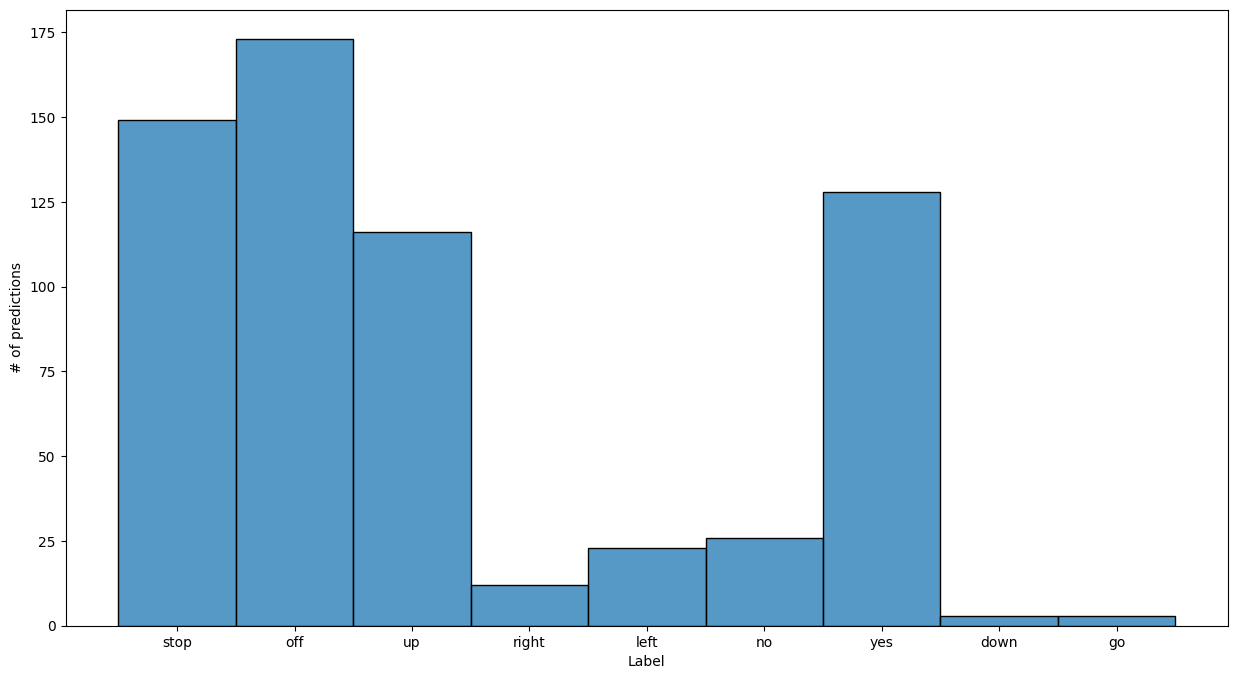

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


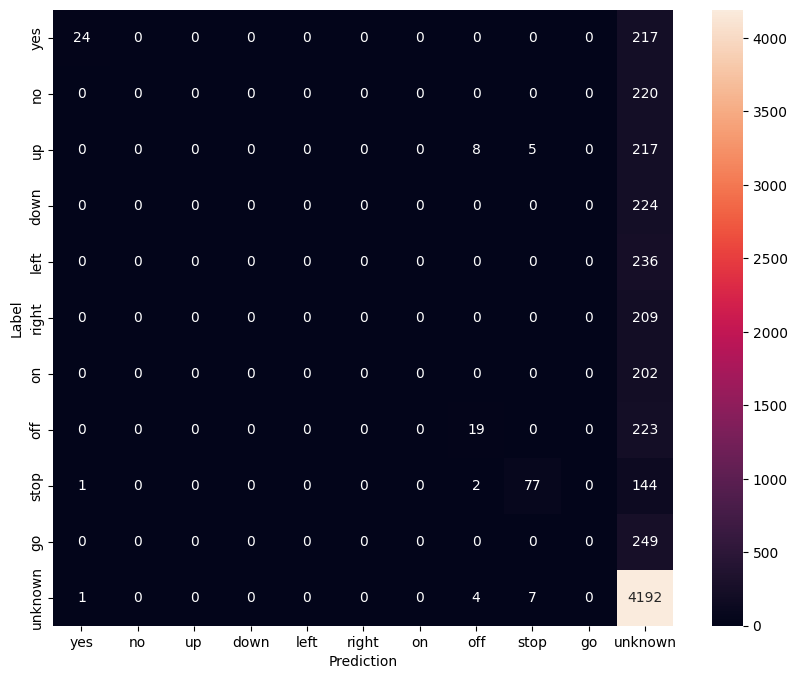

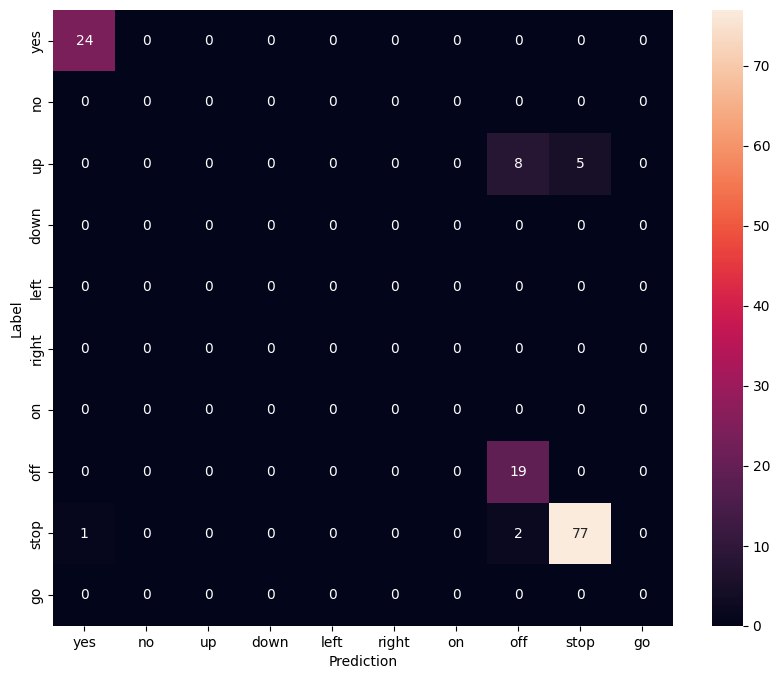

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


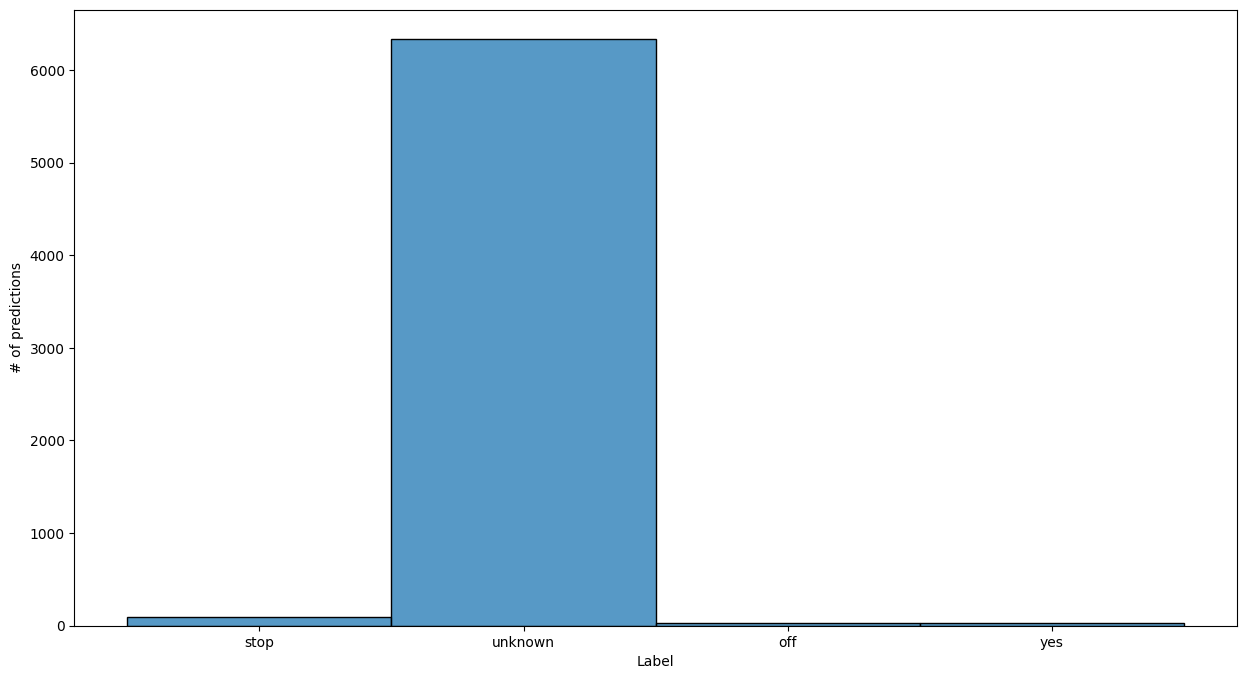

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


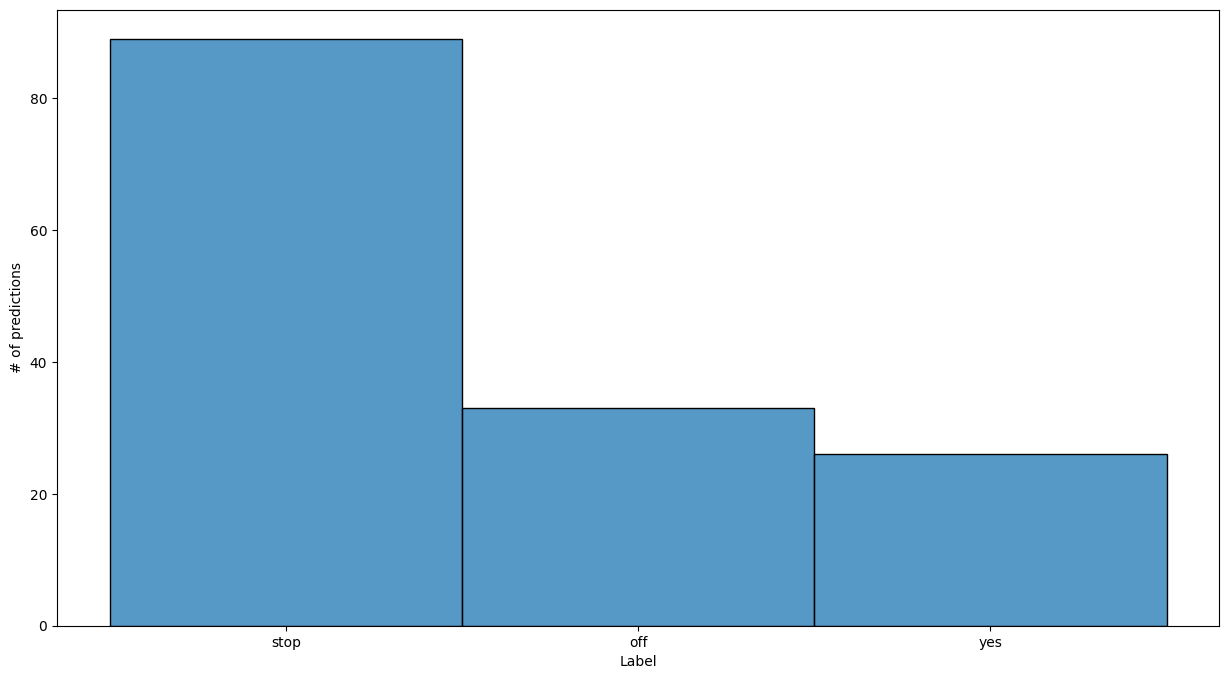

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


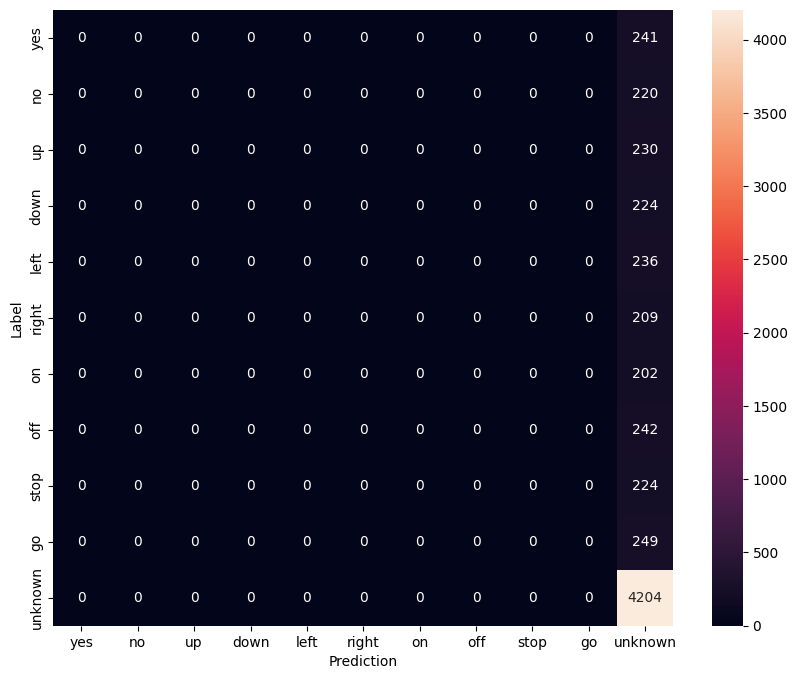

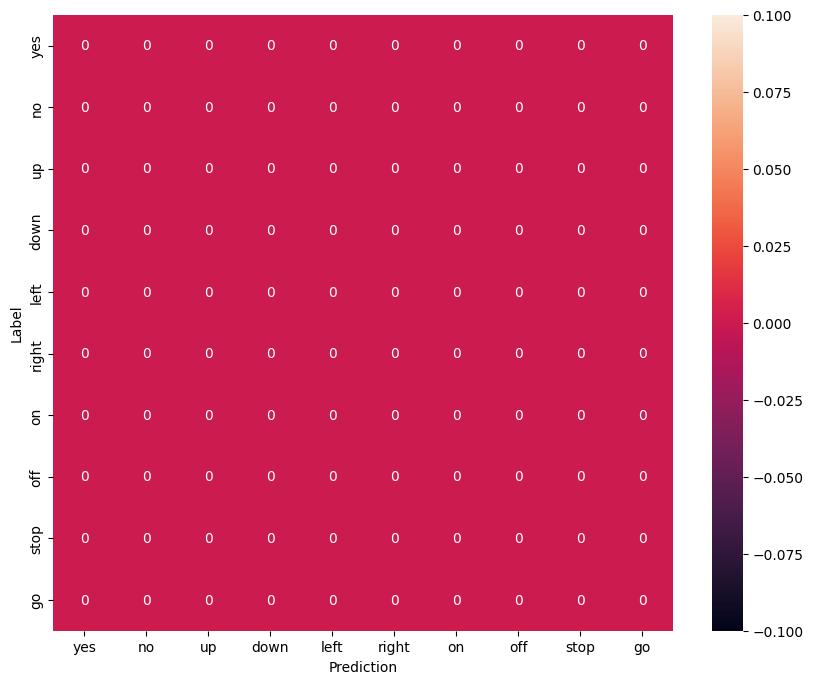

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


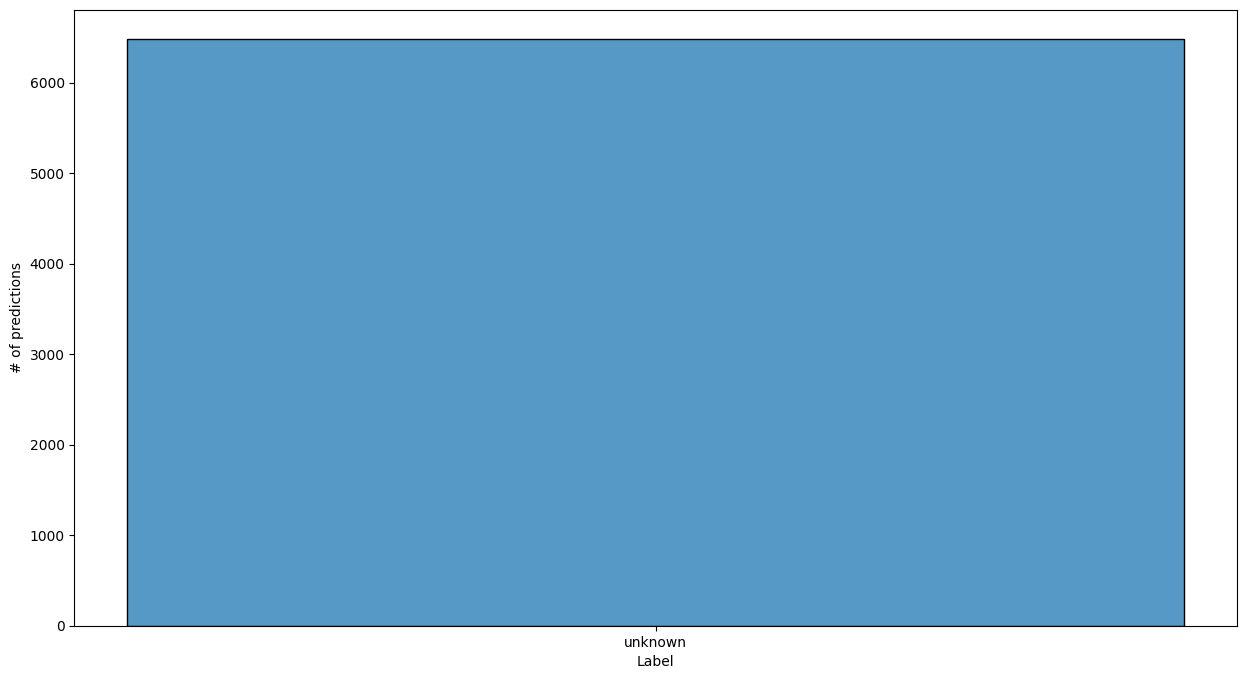

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


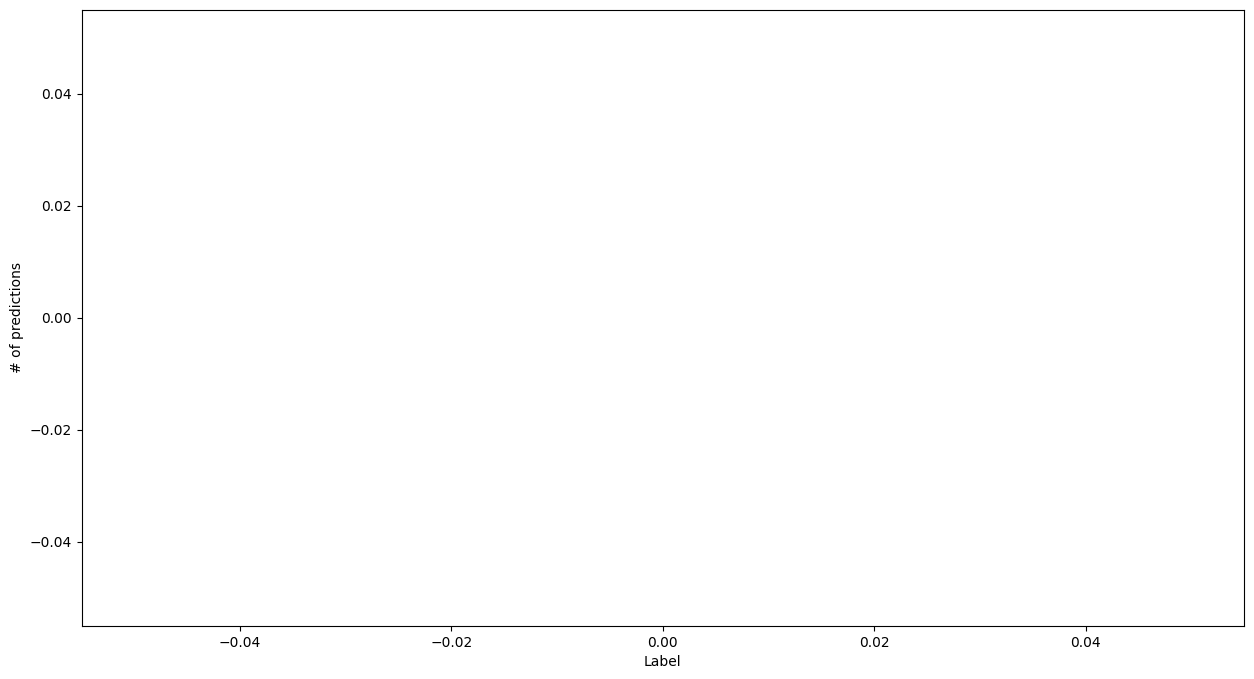

In [43]:
for model in created_models:
    confusion_matrix = display_conf_matrix(model)
    display_conf_matrix_without_unknown(confusion_matrix)
    display_histogram(model)
    display_histogram_without_unknown(model)

## Predicting labels with the model

Next, we will use our model to predict labels for the test sounds. The results, including each sound's filename and its predicted label, will be saved to a CSV file.

In [44]:
def verify_model_prediction(model):
    y_pred = model.predict(submission_spectrogram_ds)
    y_pred = tf.argmax(y_pred, axis=1)
    label_mapping = {index: value for index, value in enumerate(label_names)}
    label_texts = [label_mapping[label] for label in y_pred.numpy()]
    return label_texts

In [45]:
def plot_labels(label_texts):
    plt.figure(figsize=(15, 8))
    sns.histplot(label_texts)
    plt.xlabel('Label')
    plt.ylabel('# of predictions')
    plt.show()

In [48]:
def result_data_frame(label_texts):
    result_df = pd.DataFrame(label_texts, columns=['label'])

    file_names = sorted([path.name for path in test_dir.glob("*/*")])
    result_df["file"] = file_names

    result_df = result_df[['file', 'label']]
    result_df.to_csv('submission.csv', index=False)
    return result_df

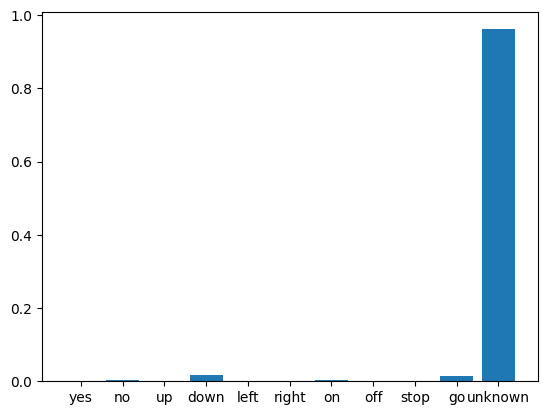

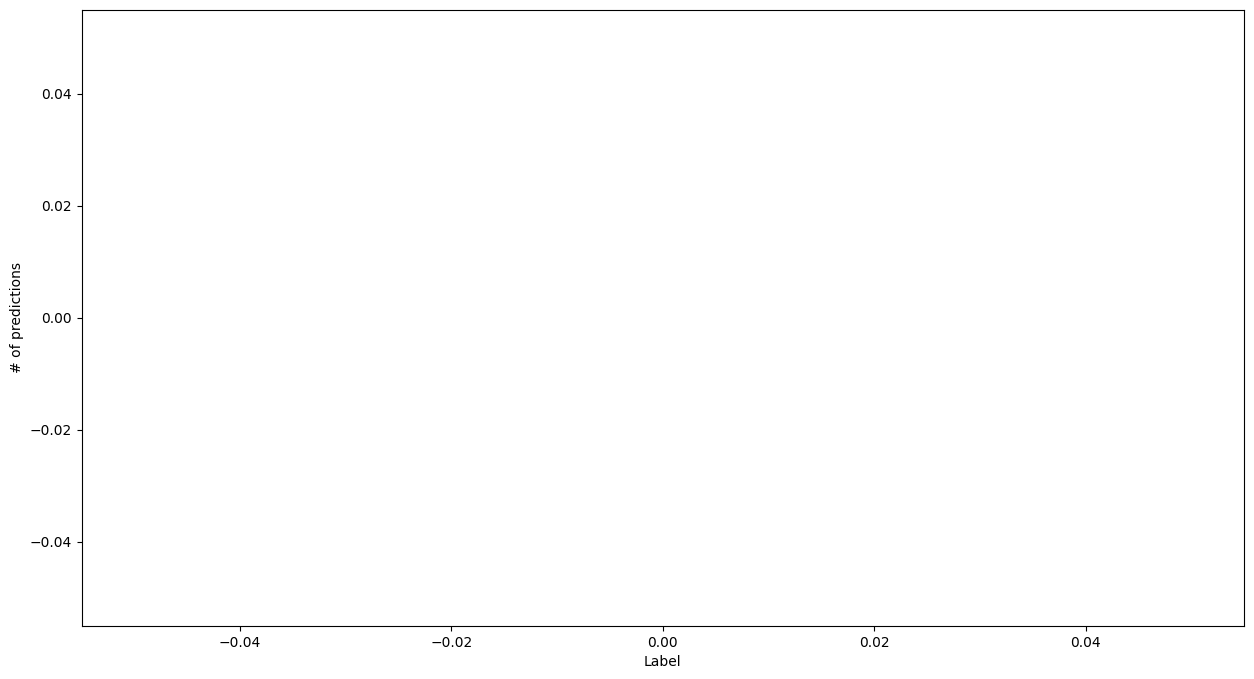

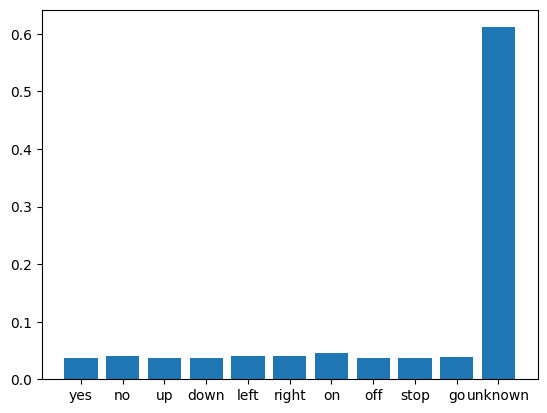

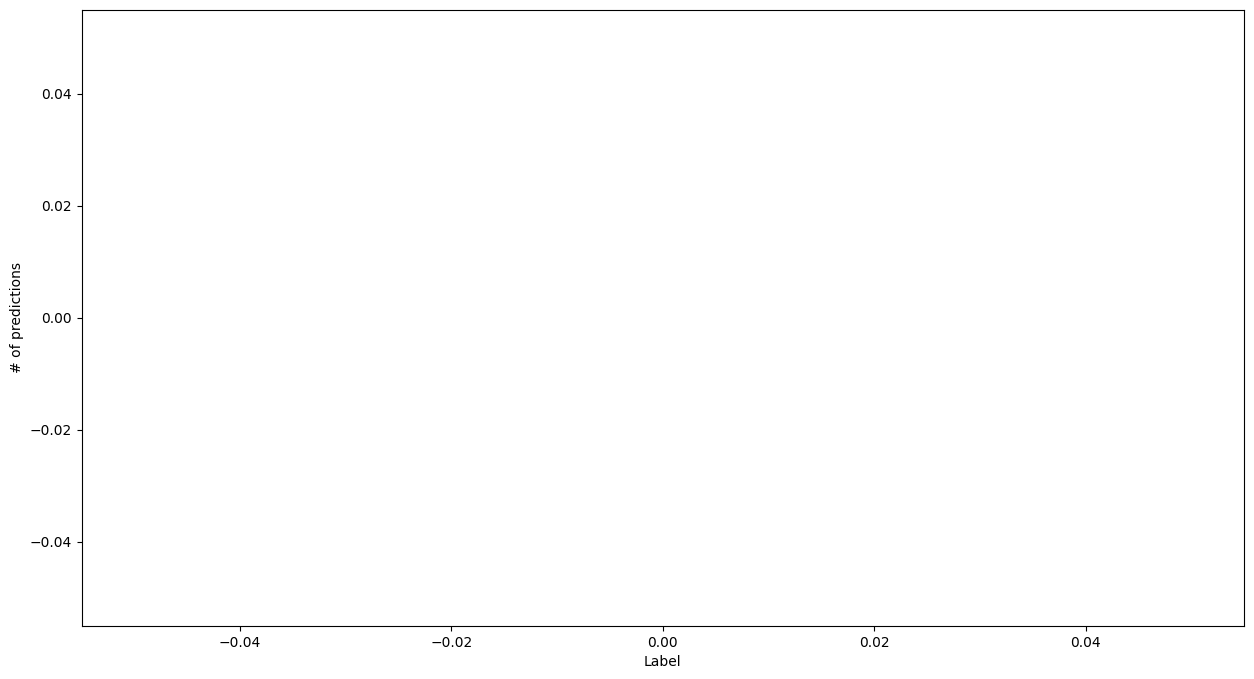

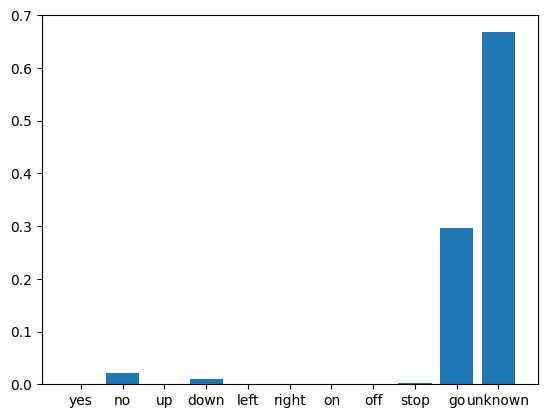

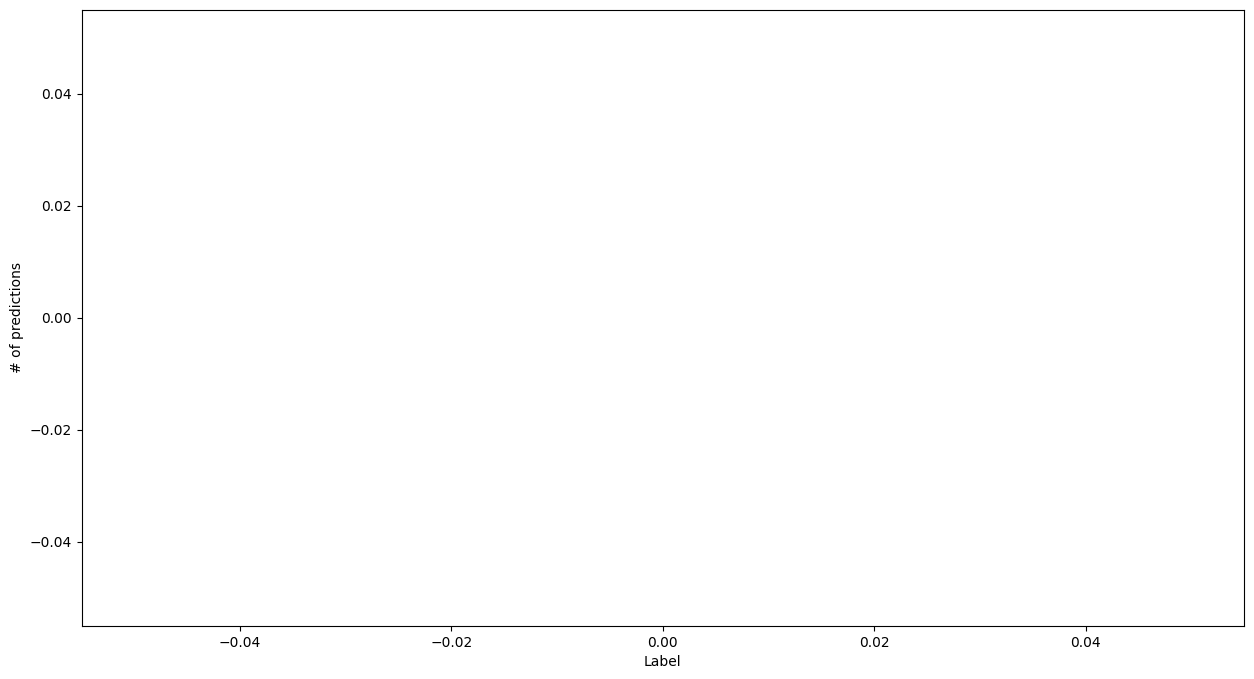

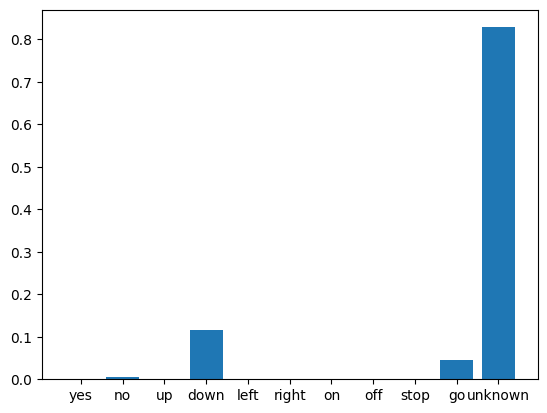

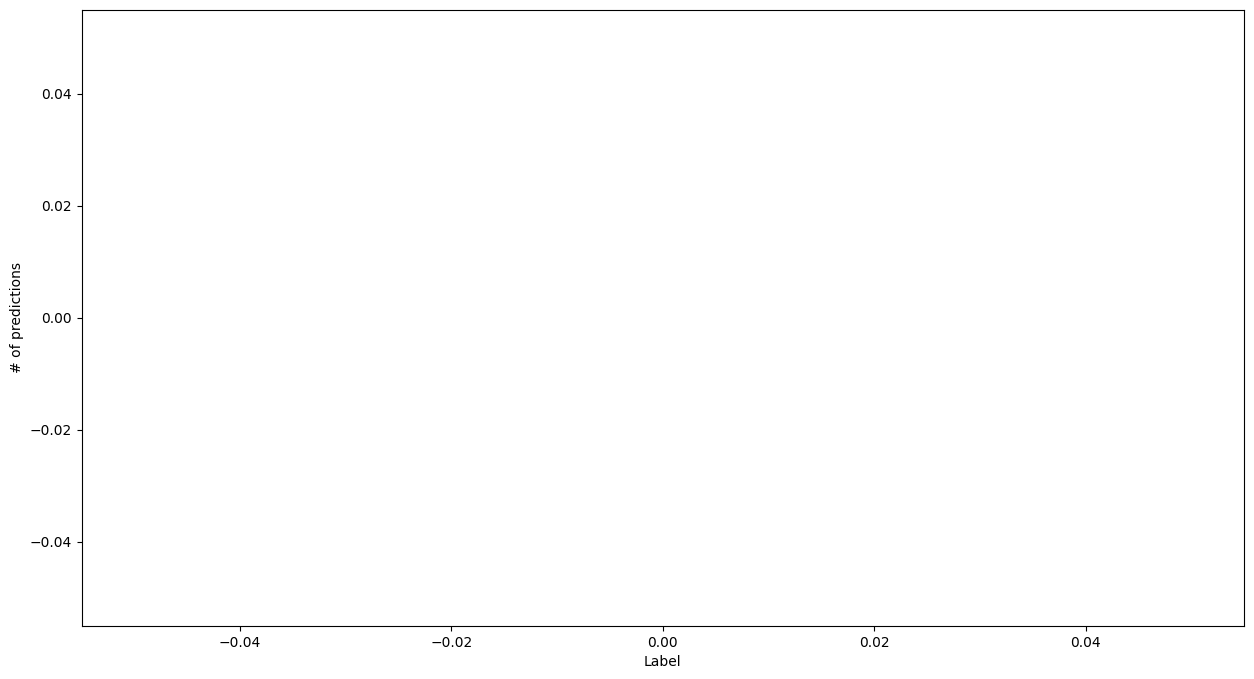

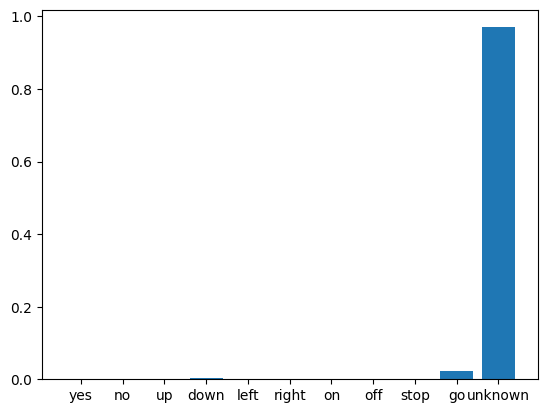

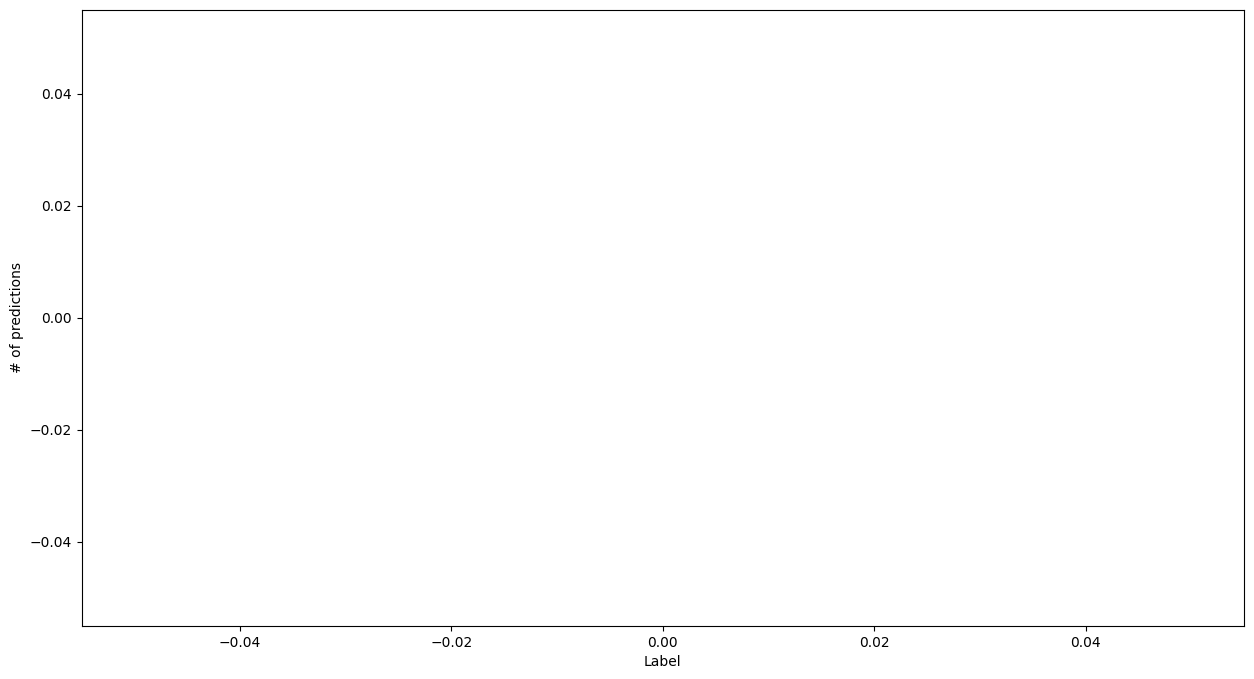

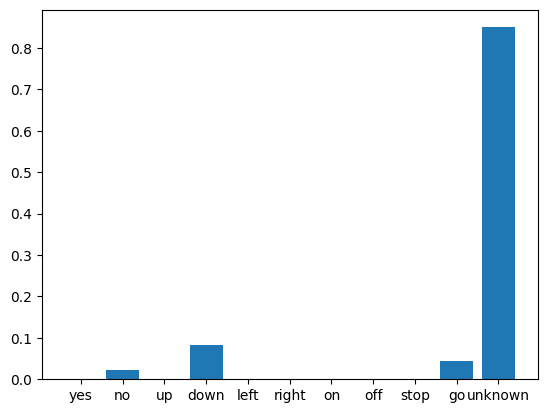

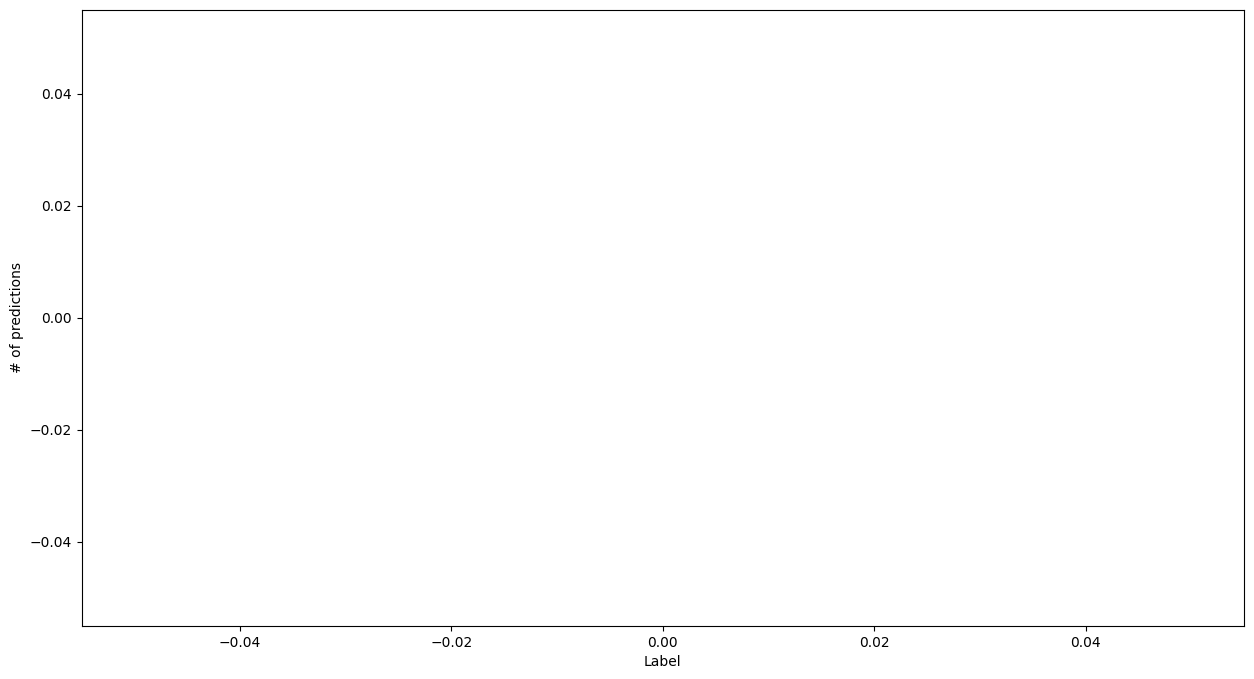

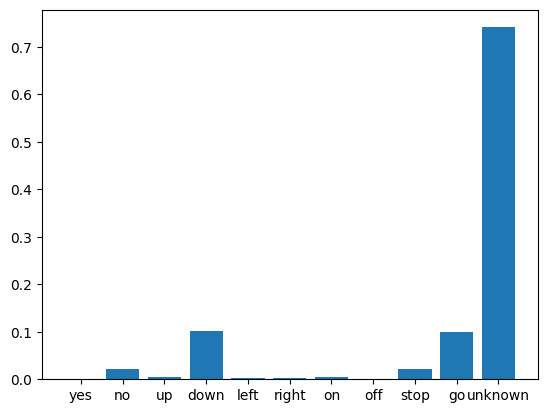

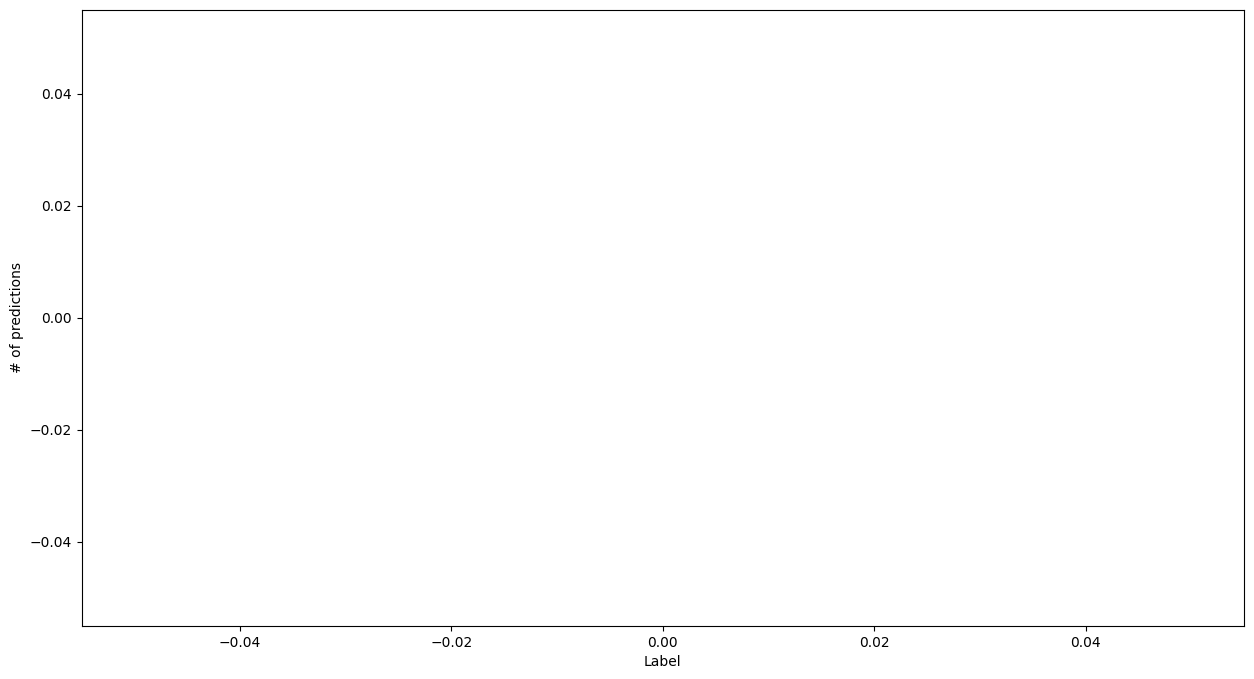

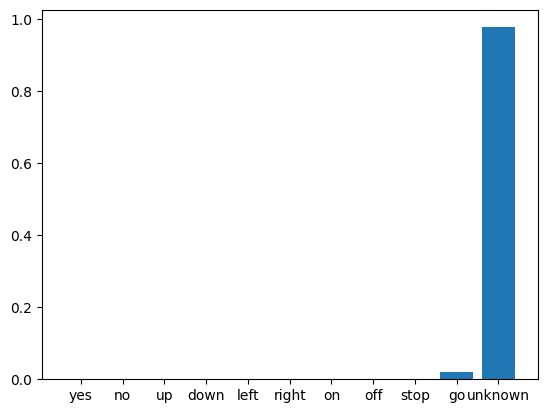

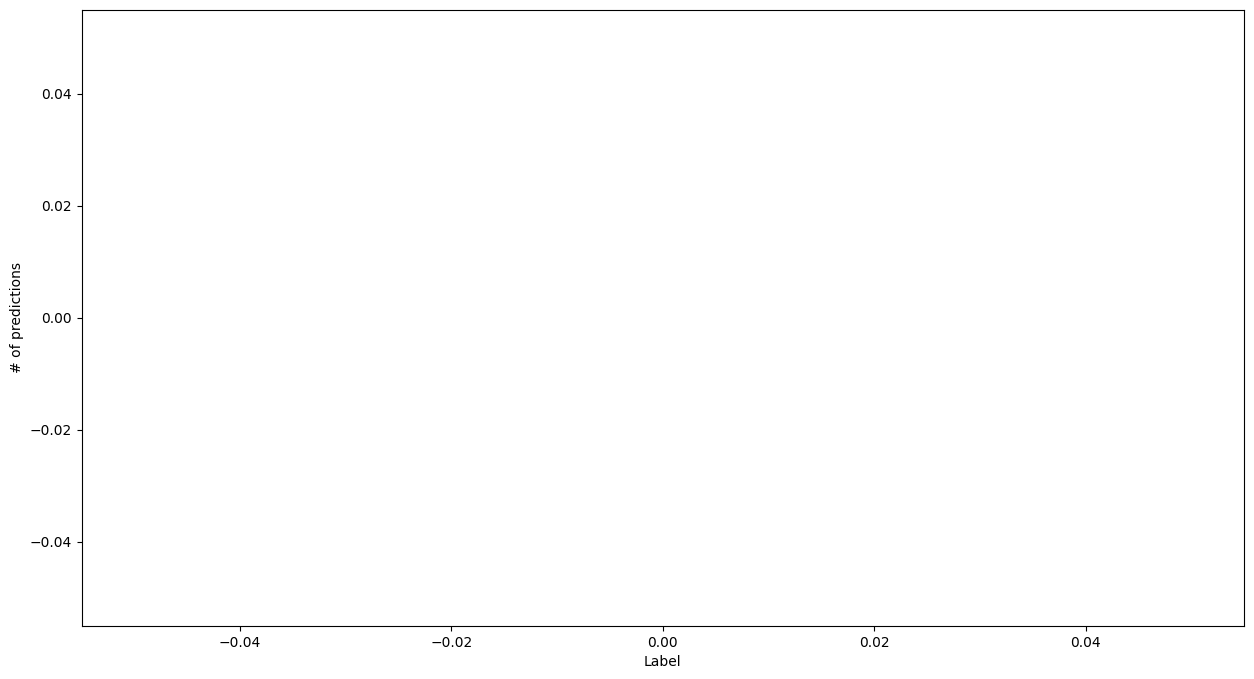

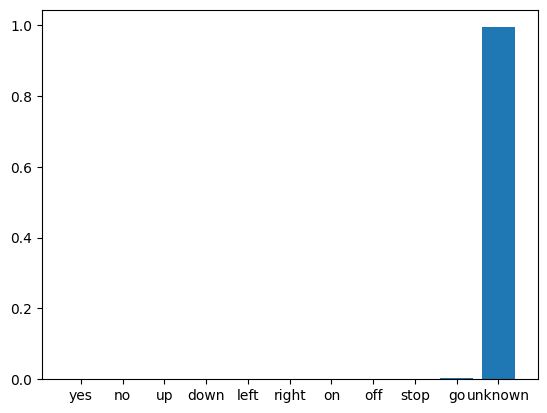

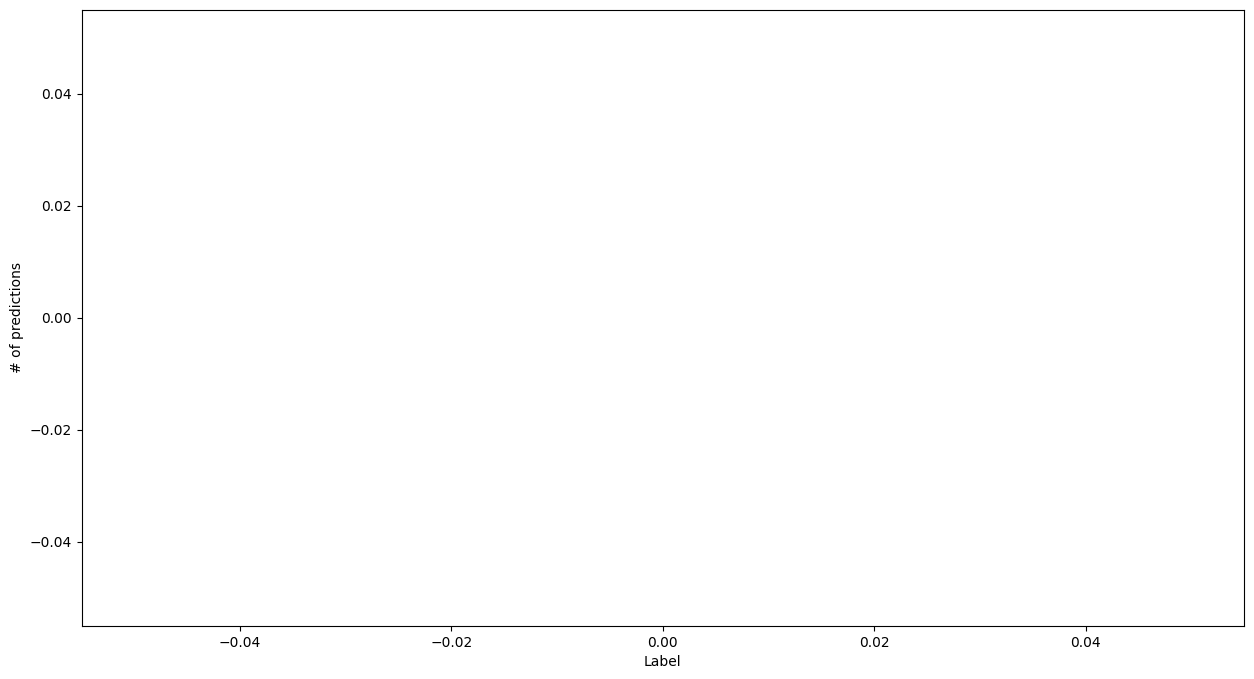

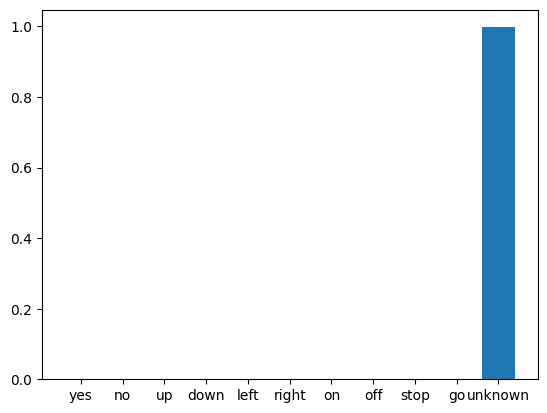

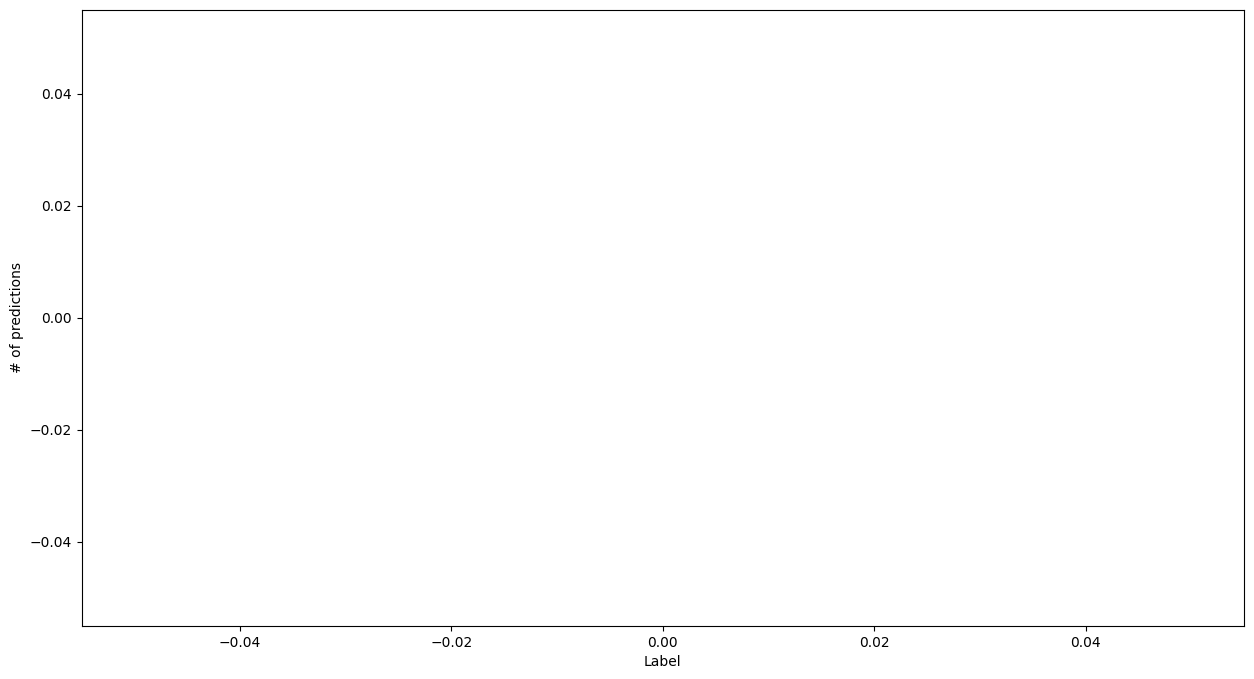

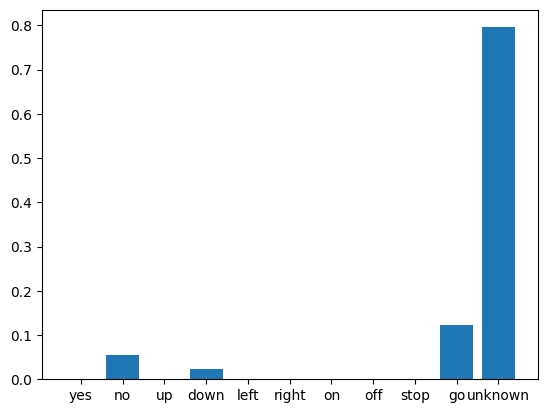

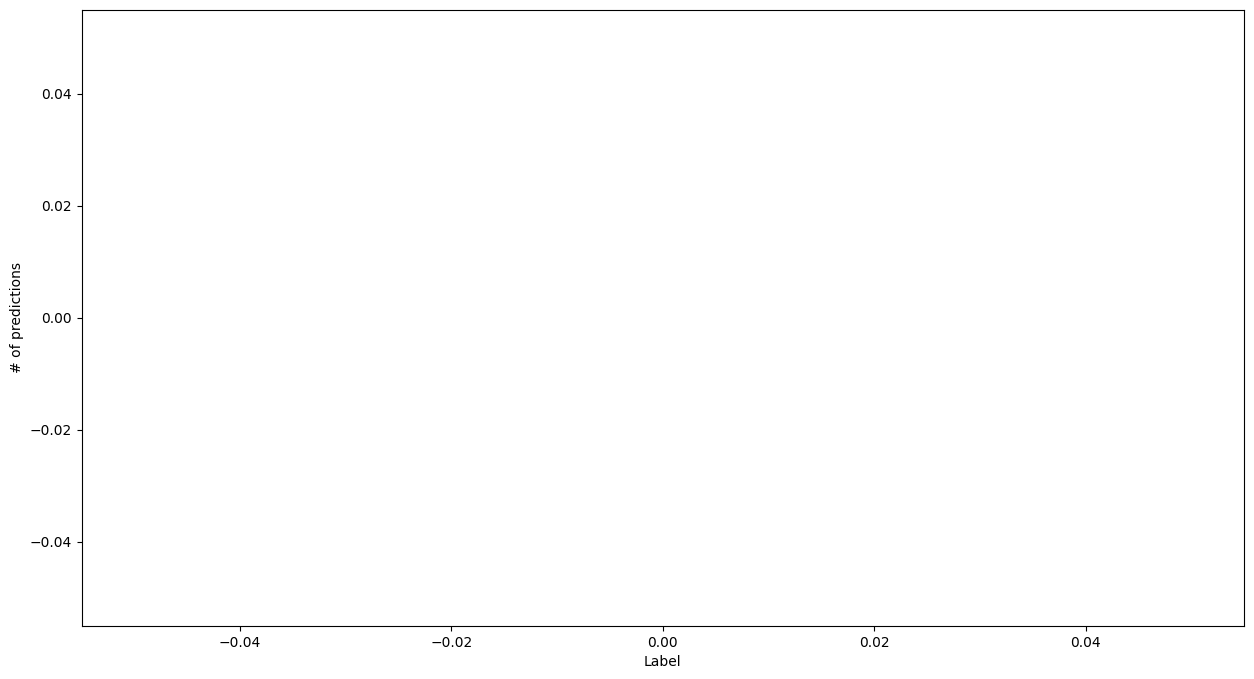

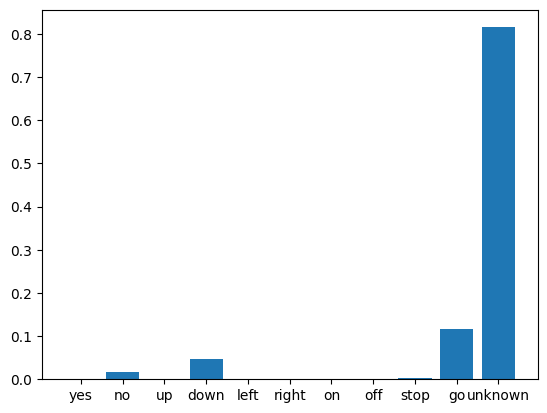

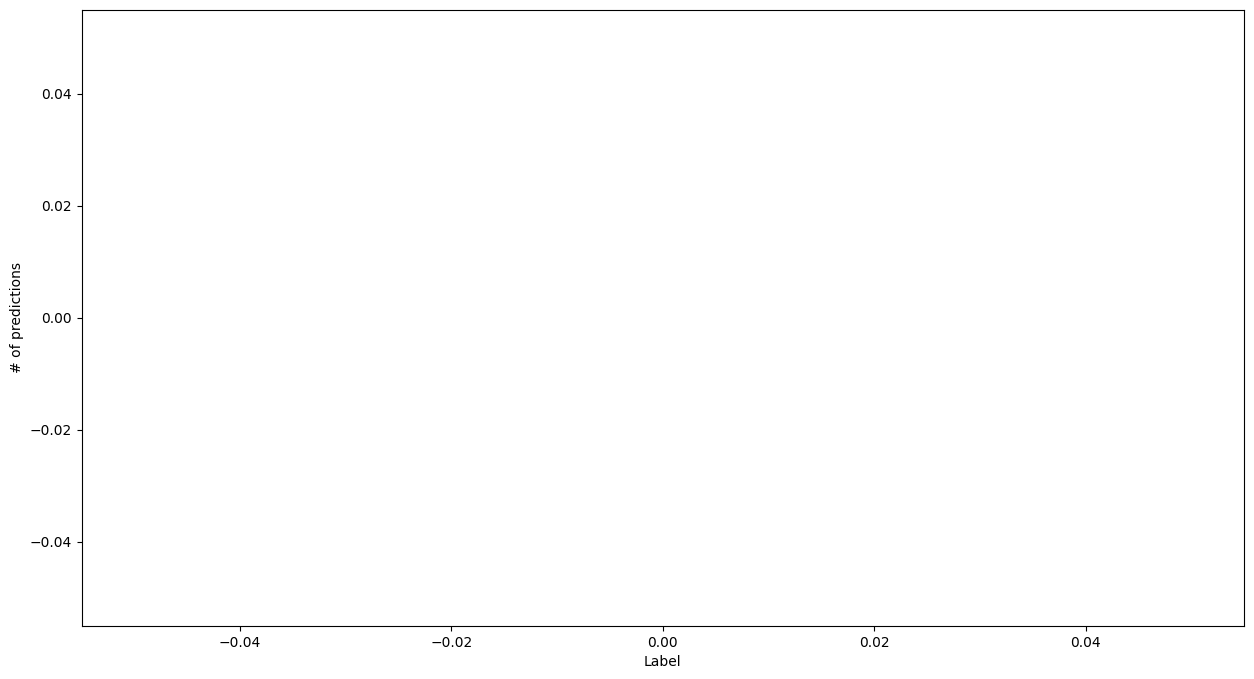

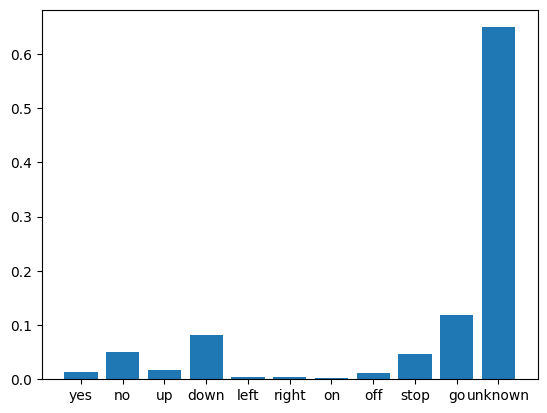

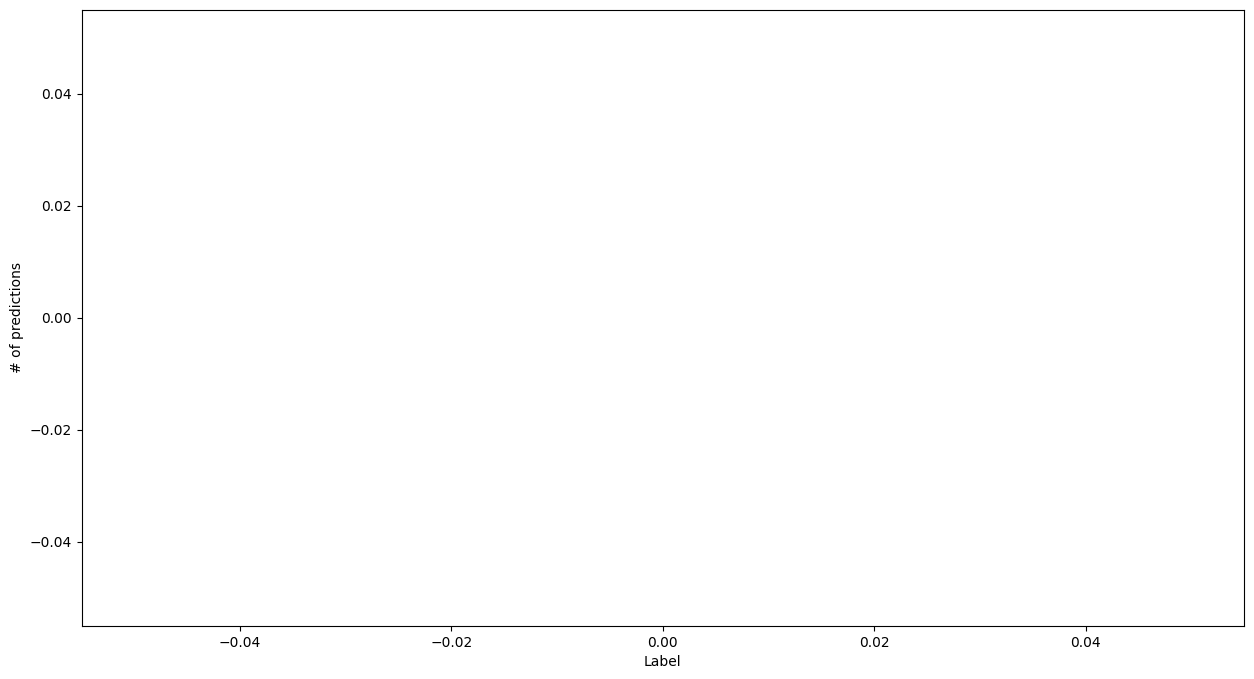

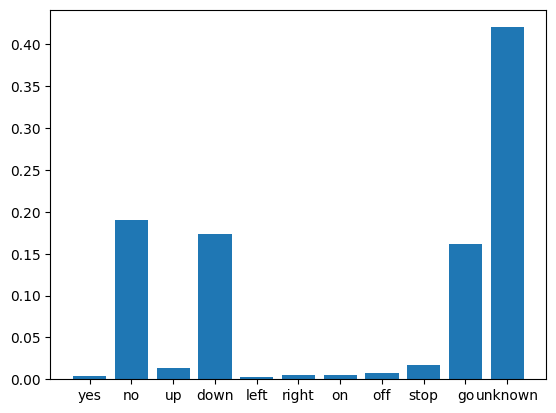

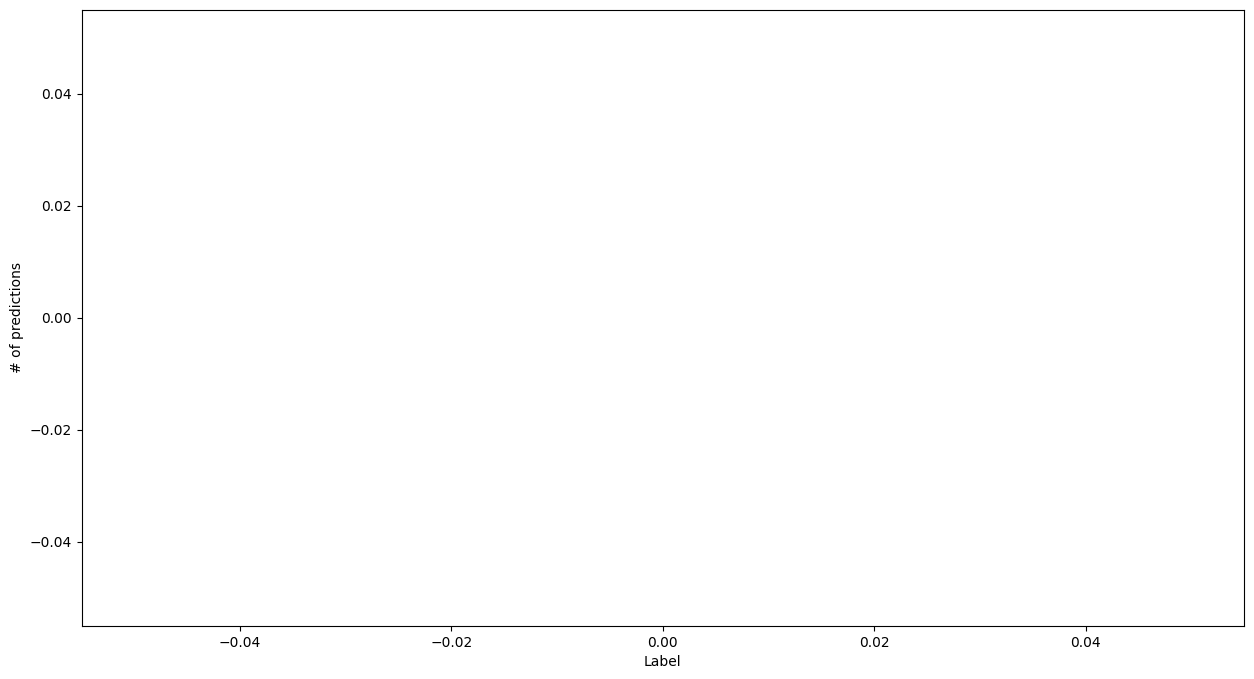

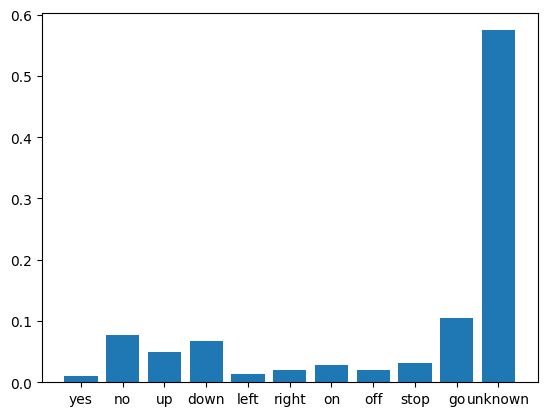

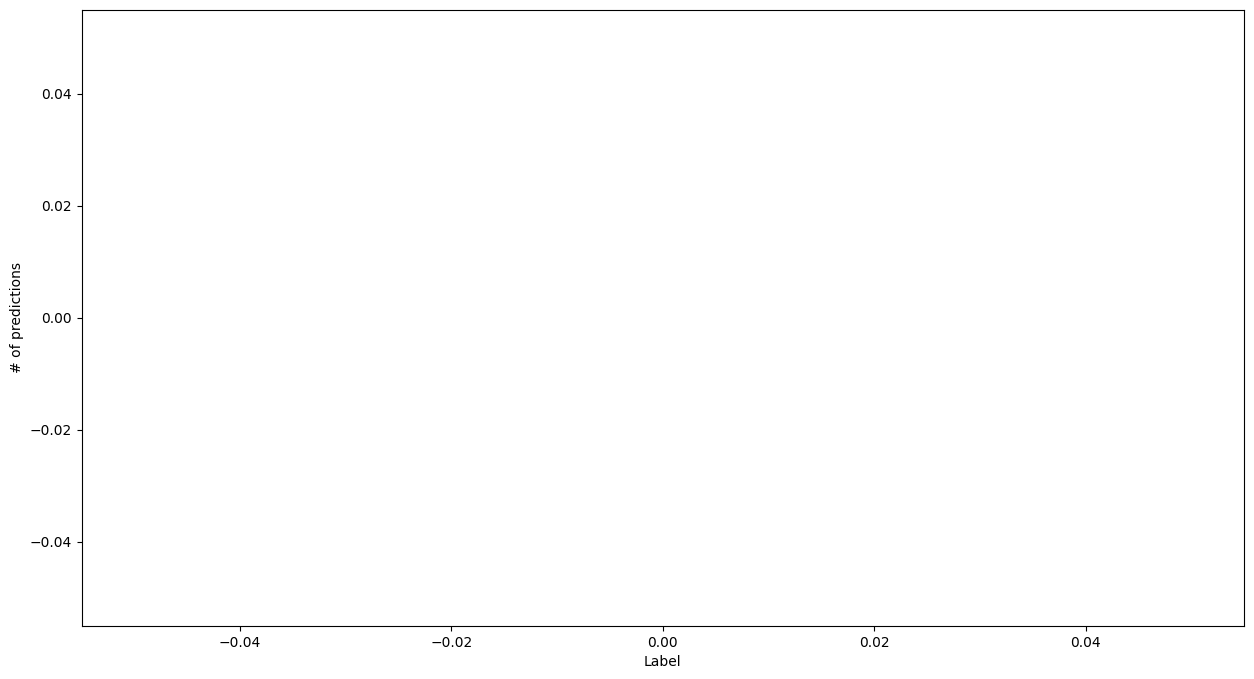

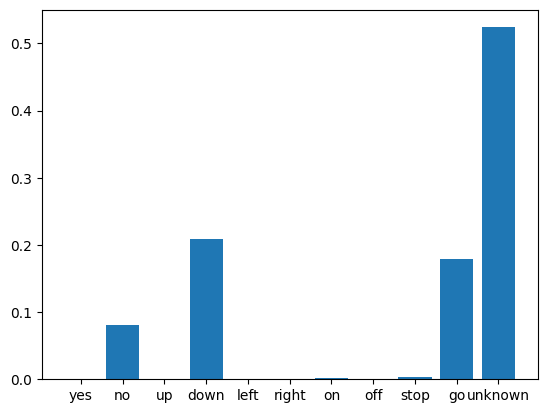

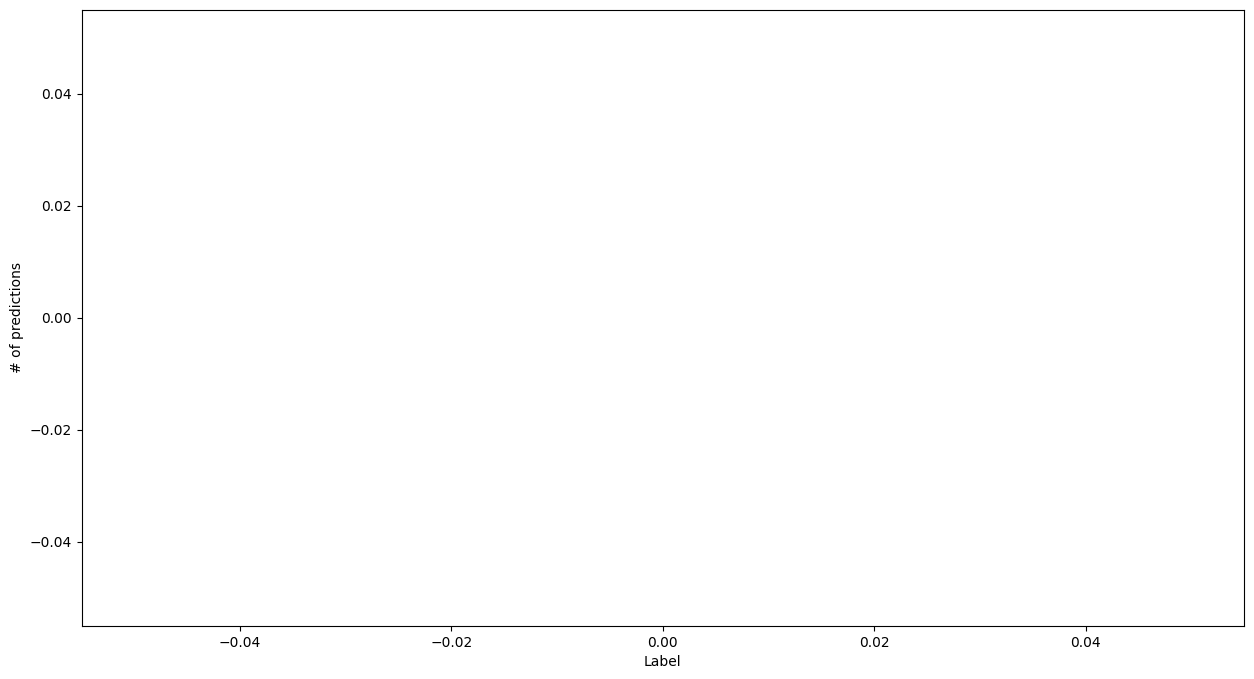

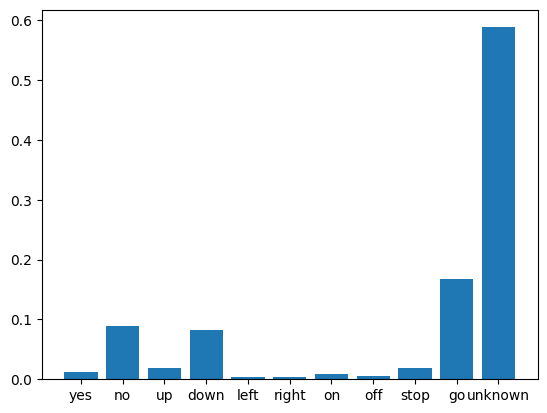

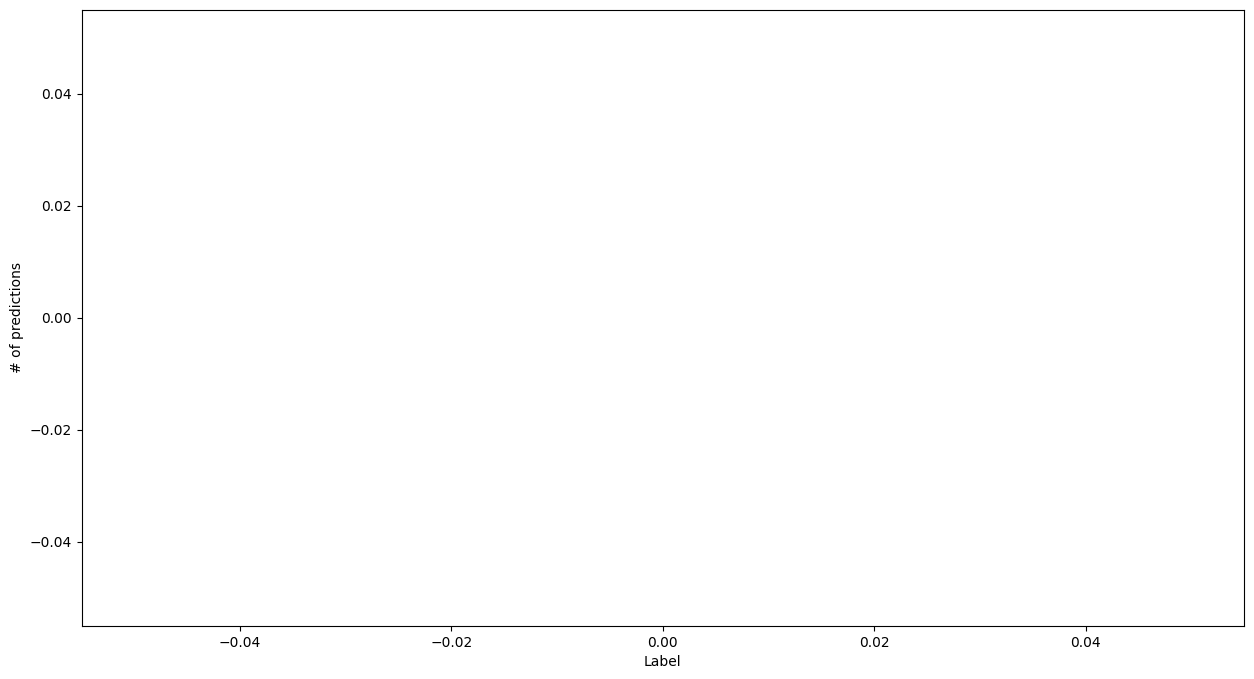

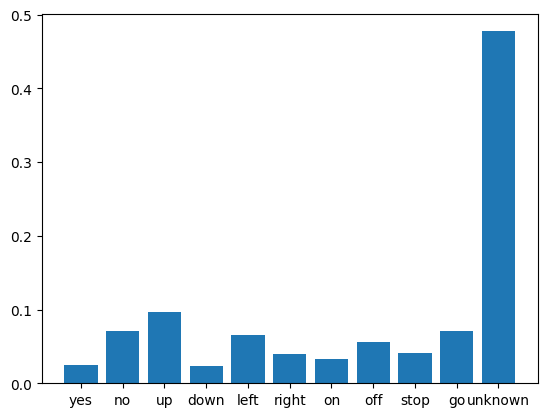

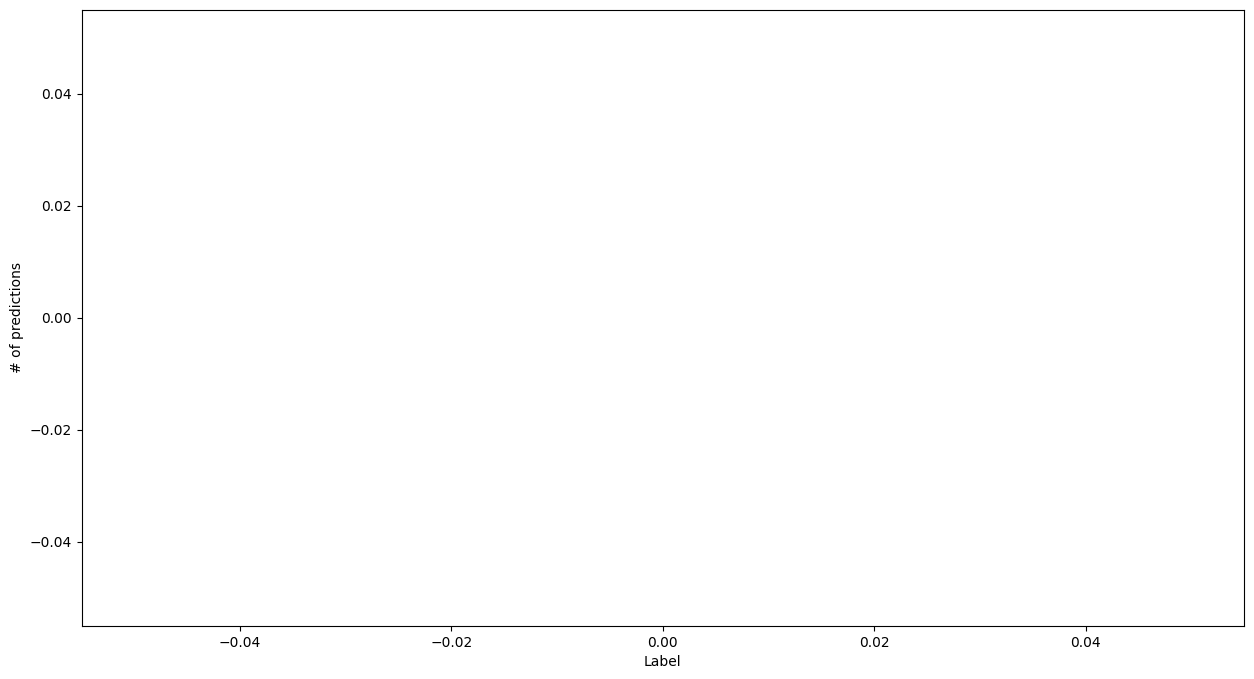

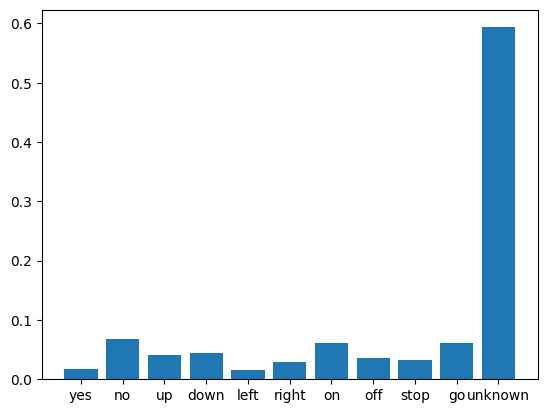

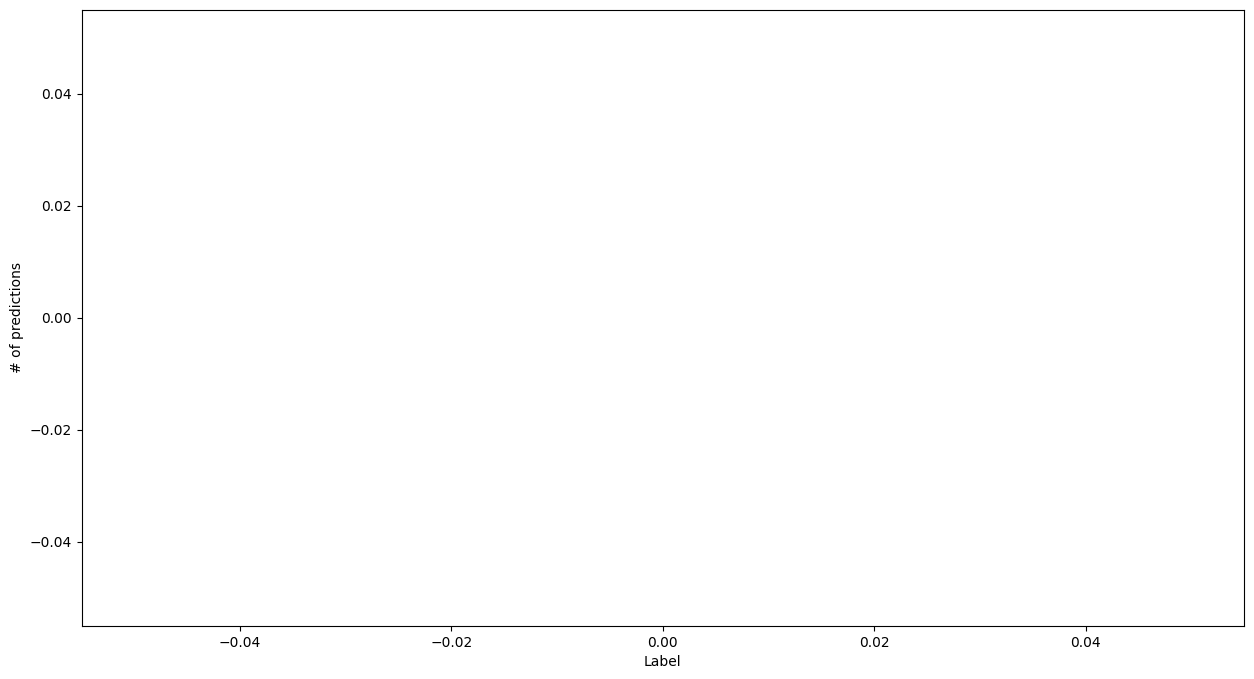

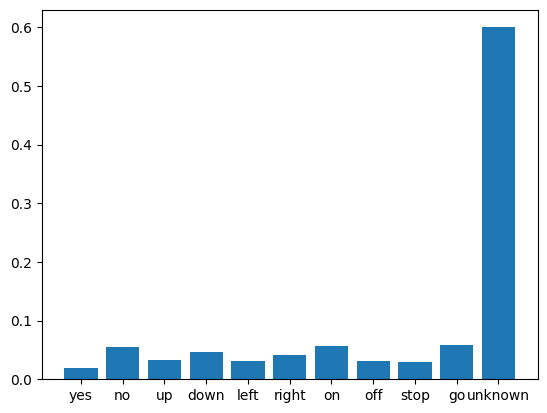

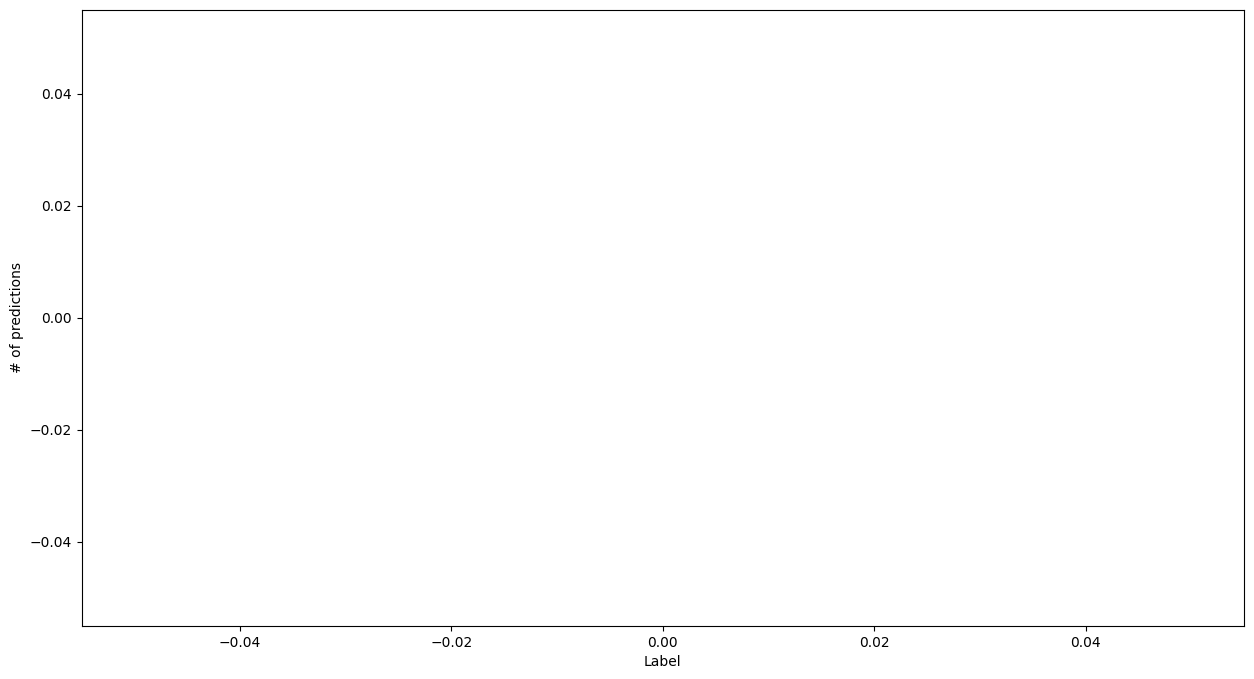

In [51]:
for model in created_models:
    label_texts = verify_model_prediction(model)
    plot_labels(label_texts)
    result_df = result_data_frame(label_texts)
    result_df

## Verification of models prediction

Let's select a sound and verify its predicted label.

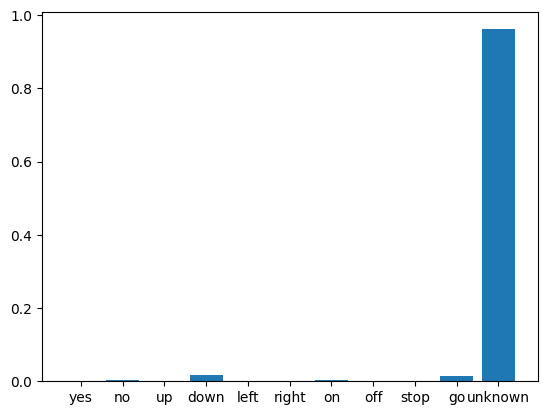

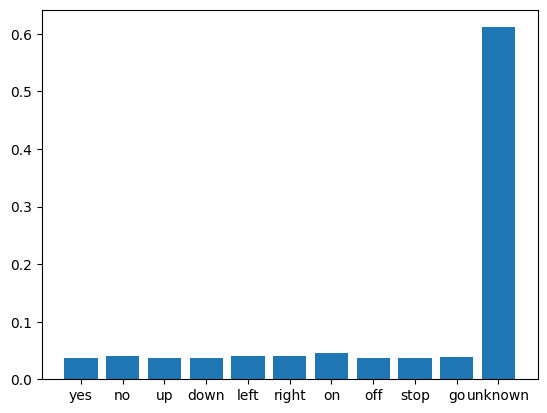

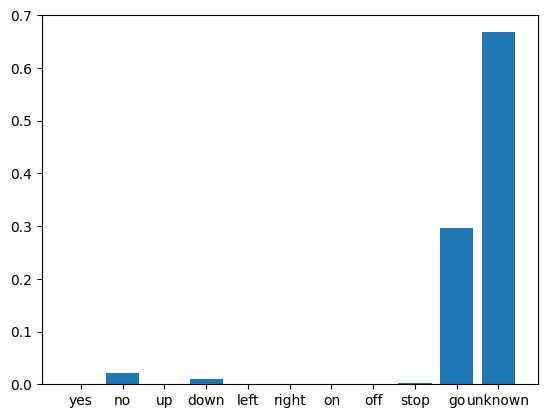

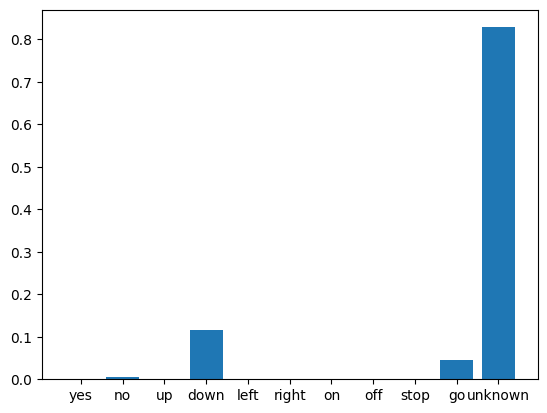

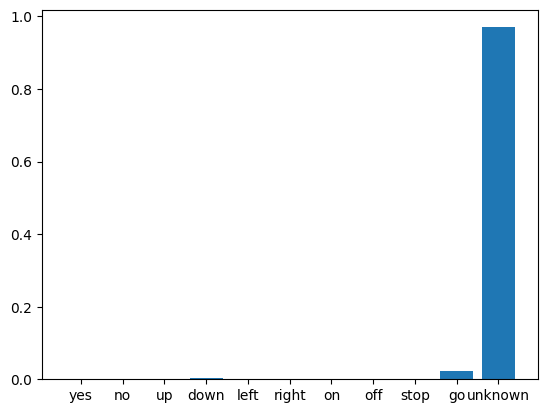

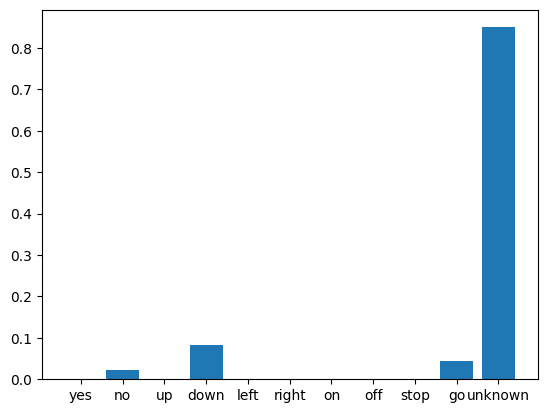

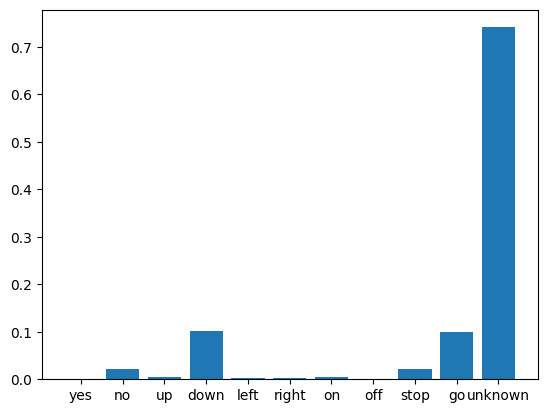

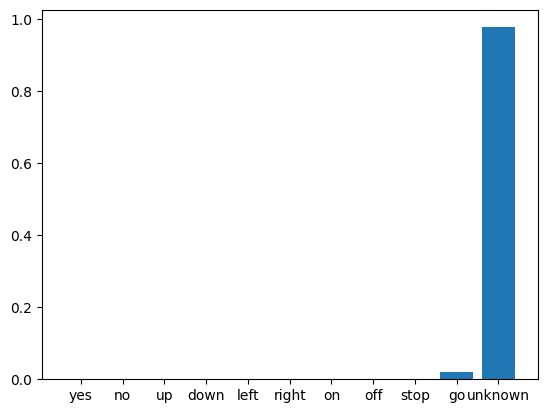

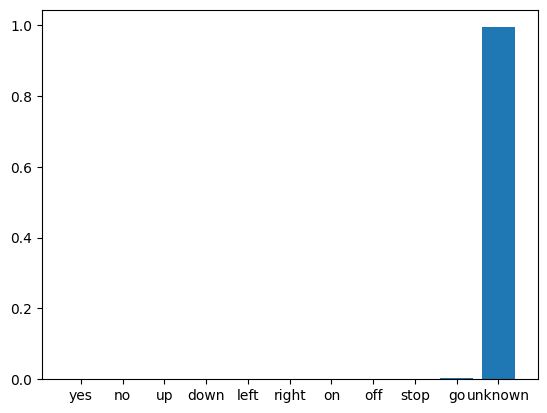

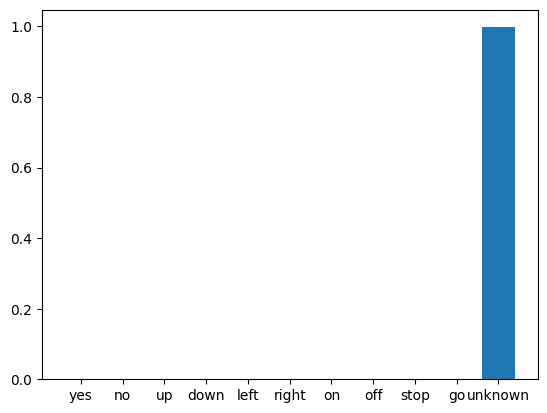

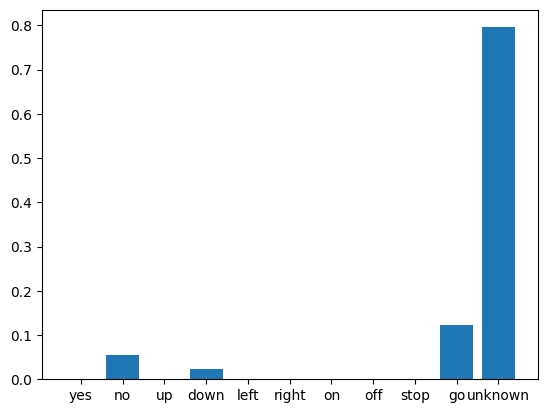

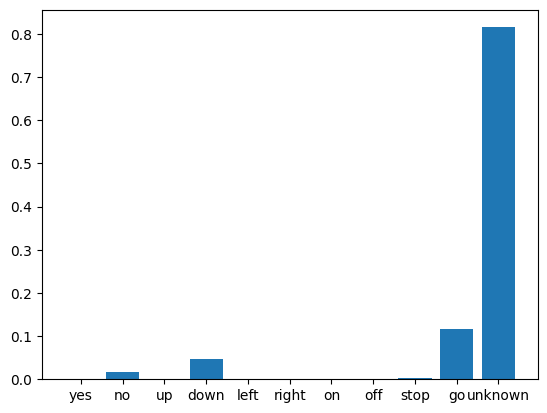

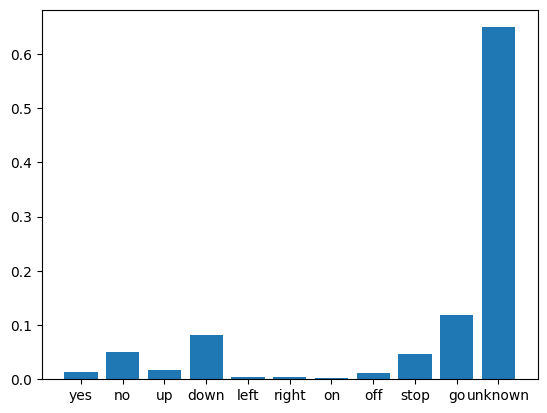

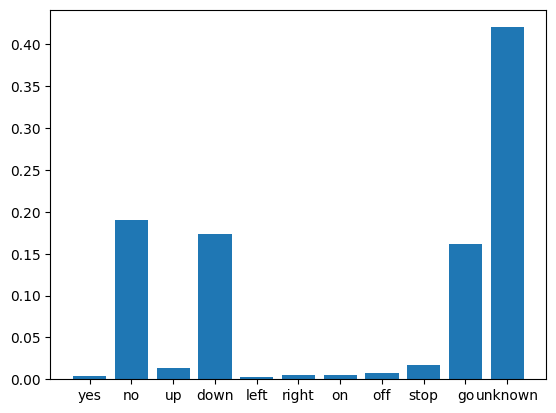

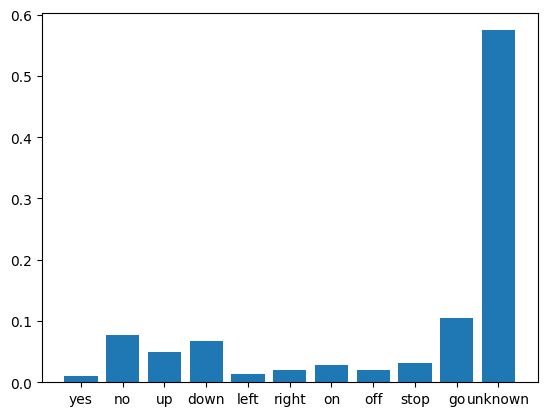

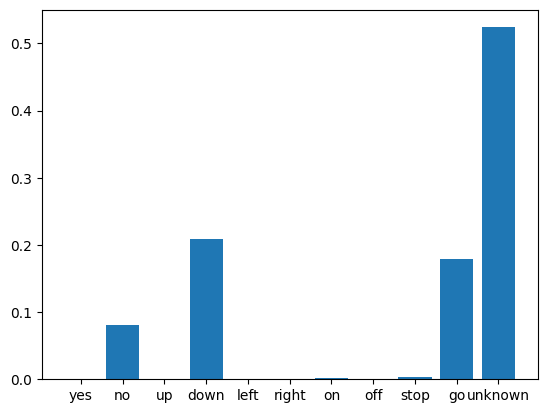

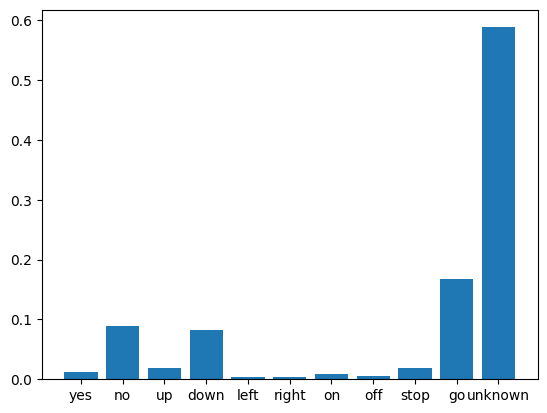

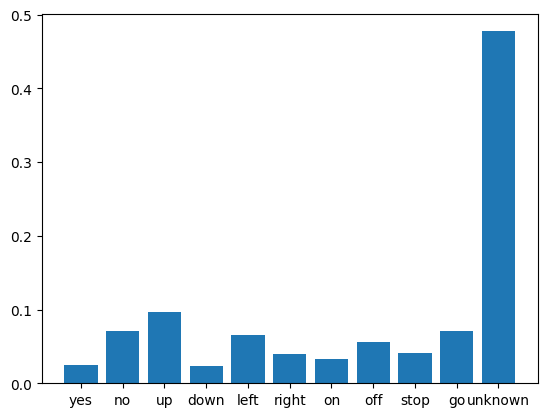

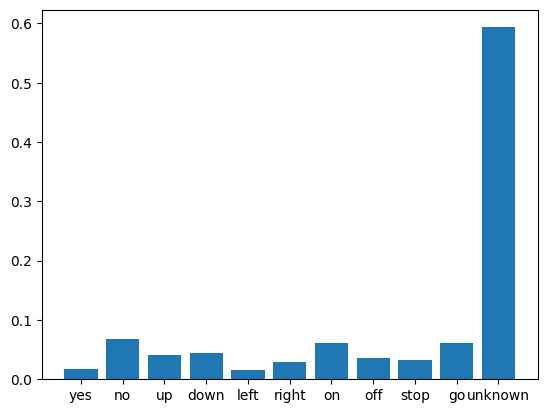

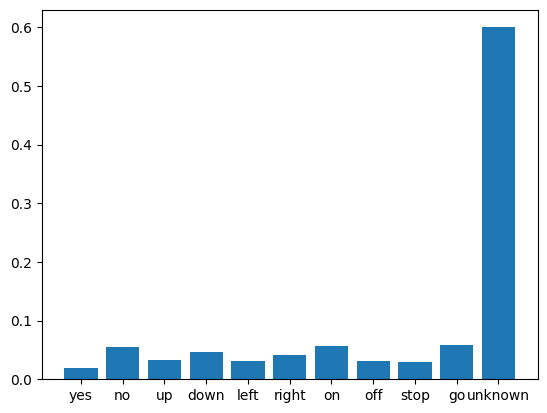

In [53]:
def verify_model_prediction(model):
    x = test_dir/'audio\clip_00082a7d6.wav' 
    x = tf.io.read_file(str(x))
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = get_spectrogram(x)
    x = x[tf.newaxis,...]

    prediction = model(x)
    plt.bar(label_names, tf.nn.softmax(prediction[0]))
    plt.show()

    display.display(display.Audio(waveform, rate=16000))

for model in created_models:
    verify_model_prediction(model)